In [1]:
import os
import glob
import random
import multiprocessing
import copy
import pprint
from pathlib import Path
import time
from datetime import datetime
from typing import Optional, Union, Tuple

import enum
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
from skimage.util import montage
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy import stats
import nrrd
import torch
import torchio as tio
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision.ops.focal_loss import sigmoid_focal_loss
from unet import UNet
from torchinfo import summary


seed = 2022

random.seed(seed)
torch.manual_seed(seed)
num_workers = multiprocessing.cpu_count()

path_data = os.path.join(os.getcwd(), '..', 'data')
path_eda = os.path.join(path_data, 'eda')
path_segmentation = os.path.join(path_data, 'segmentation_xyz')
path_cropped = os.path.join(path_data, 'segmentation_xyz_cropped')

path_saved_models = os.path.join(os.getcwd(), '..', 'saved_models')

if not os.path.isdir(path_saved_models):
    os.mkdir(path_saved_models)

In [2]:
def load_image(path):
    
    data, header = nrrd.read(path)
    data = data.astype(np.float32)
    affine = np.eye(4)
    
    return data, affine


class Visualizer:
    
    def montage_nrrd(self, image):
        if len(image.shape) > 2:
            return montage(image)
        else:
            warnings.warn('Pass a 3D volume', RuntimeWarning)
            return image
        
    def visualize(self, image, mask=None):
        
        if mask is None:
            fig, axes = plt.subplots(1, 1, figsize=(10, 10))
            axes.imshow(self.montage_nrrd(image))
            axes.set_axis_off()
        else:
            fig, axes = plt.subplots(1, 2, figsize=(40, 40))
        
            for i, data in enumerate([image, mask]):
                axes[i].imshow(self.montage_nrrd(data))
                axes[i].set_axis_off()
                
                
vis = Visualizer()

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = (2, 3, 4)


class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    

def prepare_batch(batch, device):
    
    inputs = batch['spect'][tio.DATA].to(device)
    targets = batch['left_ventricle'][tio.DATA].to(device)
    
    return inputs, targets


def get_dice_score(output, target, epsilon=1e-9):
    
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    
    return dice_score


def get_dice_loss(output, target):

    return 1 - get_dice_score(output, target)


def get_model_and_optimizer(device):

    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    
    return model, optimizer


def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler):
    
    is_training = action == Action.TRAIN
    epoch_losses = []
    precisions, recalls, ious = [], [], []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
    
        with torch.set_grad_enabled(is_training):
        
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            
            if is_training:
            
                batch_loss.backward()
                optimizer.step()
            
            epoch_losses.append(batch_loss.item())
            
            prec, rec, iou = compute_metrics(probabilities, targets)
            precisions.append(prec)
            recalls.append(rec)
            ious.append(iou)
    
    if scheduler is not None:
        scheduler.step()
    epoch_losses = np.array(epoch_losses).mean()
    
    print(
        f'{action.value} mean loss: {epoch_losses.mean():0.3f}'
        f'\tPrecision: {np.array(precisions).mean():.2f}'
        f'\tRecall: {np.array(recalls).mean():.2f}\tIoU: {np.array(ious).mean():.2f}'
    )
    
    return time.time(), epoch_losses


def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler):
    
    train_losses = []
    val_losses = []
    
    for epoch_idx in range(1, num_epochs + 1):
    
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer, scheduler))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer, scheduler))
    
    return np.array(train_losses), np.array(val_losses)


def plot_times(axis, losses, label):
    
    times, losses = losses.transpose(1, 0)
    times = [datetime.fromtimestamp(x) for x in times]
    axis.plot(times, losses.flatten(), label=label)
    
    
def plot_epochs(axis, losses, label):
    
    _, losses = losses.transpose(1, 0)
    epochs = [i for i in range(1, len(losses.flatten()) + 1)]
    axis.plot(epochs, losses.flatten())
    
    
def get_model_and_optimizer(device):

    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='instance',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
        dropout=0.3
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    
    return model, optimizer


def compute_metrics(prediction, target):
    
    pred = prediction.argmax(dim=1)
    targ = target.argmax(dim=1)
    p1 = 1 - pred
    g1 = 1 - targ
    
    tp = (targ * pred).sum(dim=(1, 2, 3))
    fp = (pred * g1).sum(dim=(1, 2, 3))
    fn = (p1 * targ).sum(dim=(1, 2, 3))
    
    precision = (tp / (tp + fp)).mean().cpu().numpy().item()
    recall = (tp / (tp + fn)).mean().cpu().numpy().item()
    iou = (tp / (tp + fp + fn)).mean().cpu().numpy().item()
    
    return precision, recall, iou

In [4]:
df = pd.read_csv(os.path.join(path_eda, 'spect_data.csv'))

df.head()

image  image_slices  image_height  image_width                 mask  \
0  1.nrrd            62            64           64  1_Segmentation.nrrd   
1  2.nrrd            64            64           64  2_Segmentation.nrrd   
2  3.nrrd            64            64           64  3_Segmentation.nrrd   
3  4.nrrd            64            64           64                  NaN   
4  5.nrrd           128           128          128  5_Segmentation.nrrd   

   mask_slices  mask_height  mask_width  slices_positive  \
0         62.0         64.0        64.0             11.0   
1         64.0         64.0        64.0              9.0   
2         64.0         64.0        64.0             12.0   
3          NaN          NaN         NaN              NaN   
4        128.0        128.0       128.0             22.0   

   positive_pixels_ratio  positive_ratio positive_slice_ratio  
0               0.002788        0.177419               0.18 %  
1               0.001781        0.140625               0.14 %  
2               0.006973        0.187500               0.19 %  
3                    NaN             NaN                  NaN  
4               0.001923        0.171875               0.17 %

In [5]:
subjects = []

segmentations = list(df.loc[(df['mask'].notnull()), ['image', 'mask']].to_records(index=False))
segmentations = list(map(
    lambda x: (
        os.path.join(path_segmentation, x[0]),
        os.path.join(path_segmentation, x[1])
    ), 
    segmentations
))

for image_path, label_path in segmentations:

    subject = tio.Subject(
        spect=tio.ScalarImage(image_path, reader=load_image),
        left_ventricle=tio.LabelMap(label_path, reader=load_image)
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)
print(f"Dataset size: {len(dataset)} subjects")

Dataset size: 10 subjects


In [6]:
target_shape = (128, 128, 32)

training_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape, mask_name="left_ventricle"),
    tio.ZNormalization(),
    tio.OneHot()
])

validation_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape, mask_name="left_ventricle"),
    tio.ZNormalization(),
    tio.OneHot()
])

In [7]:
training_split_ratio = 0.6

num_subjects = len(dataset)

num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
validation_set = tio.SubjectsDataset(validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 6 subjects
Validation set: 4 subjects


In [8]:
training_batch_size = 2
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0,
)

In [23]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 100

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=0.0
).to(device)

model.encoder.load_state_dict(encoder_weights)


for name, param in model.named_parameters():
    
    if name.startswith('encoder'):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        
"""
for name, param in model.named_parameters():
    
    if name.startswith('encoder') and 'blocks.1.' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
"""
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Training mean loss: 0.629	Precision: 0.05	Recall: 0.74	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.591	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.603	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.581	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.597	Precision: 0.08	Recall: 1.00	IoU: 0.08
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.575	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.593	Precision: 0.09	Recall: 1.00	IoU: 0.09
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.571	Precision: 0.22	Recall: 1.00	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.589	Precision: 0.10	Recall: 1.00	IoU: 0.10
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.567	Precision: 0.24	Recall: 0.99	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.586	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.564	Precision: 0.27	Recall: 0.99	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.584	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.561	Precision: 0.25	Recall: 1.00	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.581	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.558	Precision: 0.25	Recall: 1.00	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.578	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.555	Precision: 0.29	Recall: 0.99	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.575	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.552	Precision: 0.29	Recall: 0.99	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.573	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.550	Precision: 0.28	Recall: 1.00	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.571	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.547	Precision: 0.29	Recall: 1.00	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.568	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.30	Recall: 1.00	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.565	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.541	Precision: 0.31	Recall: 1.00	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.563	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.538	Precision: 0.32	Recall: 1.00	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.561	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.536	Precision: 0.29	Recall: 1.00	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.558	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.533	Precision: 0.32	Recall: 1.00	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.556	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.35	Recall: 0.99	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.31	Recall: 1.00	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.553	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.526	Precision: 0.32	Recall: 1.00	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.549	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.523	Precision: 0.35	Recall: 1.00	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.520	Precision: 0.34	Recall: 1.00	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.545	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.518	Precision: 0.36	Recall: 1.00	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.543	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.515	Precision: 0.34	Recall: 1.00	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.541	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.35	Recall: 1.00	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.539	Precision: 0.22	Recall: 1.00	IoU: 0.22
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.510	Precision: 0.38	Recall: 1.00	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Precision: 0.22	Recall: 1.00	IoU: 0.22
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.507	Precision: 0.39	Recall: 0.99	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.534	Precision: 0.22	Recall: 1.00	IoU: 0.22
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.504	Precision: 0.39	Recall: 0.99	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.532	Precision: 0.22	Recall: 1.00	IoU: 0.22
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.40	Recall: 1.00	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.530	Precision: 0.26	Recall: 0.98	IoU: 0.26
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.500	Precision: 0.37	Recall: 0.99	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.529	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.498	Precision: 0.37	Recall: 0.99	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527	Precision: 0.22	Recall: 0.99	IoU: 0.21
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.40	Recall: 0.99	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.525	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.493	Precision: 0.37	Recall: 1.00	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.522	Precision: 0.22	Recall: 1.00	IoU: 0.22
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.490	Precision: 0.40	Recall: 0.99	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521	Precision: 0.22	Recall: 0.99	IoU: 0.22
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.488	Precision: 0.39	Recall: 0.99	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.519	Precision: 0.21	Recall: 1.00	IoU: 0.21
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.38	Recall: 1.00	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516	Precision: 0.26	Recall: 0.99	IoU: 0.26
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.42	Recall: 0.96	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.517	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.33	Recall: 0.99	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515	Precision: 0.17	Recall: 0.99	IoU: 0.17
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.479	Precision: 0.34	Recall: 1.00	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.39	Recall: 0.99	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.508	Precision: 0.24	Recall: 0.99	IoU: 0.24
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.43	Recall: 0.98	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506	Precision: 0.25	Recall: 1.00	IoU: 0.25
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.469	Precision: 0.41	Recall: 1.00	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505	Precision: 0.23	Recall: 1.00	IoU: 0.23
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.467	Precision: 0.40	Recall: 1.00	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504	Precision: 0.27	Recall: 0.99	IoU: 0.27
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.44	Recall: 0.99	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501	Precision: 0.25	Recall: 0.99	IoU: 0.25
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.462	Precision: 0.41	Recall: 1.00	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.499	Precision: 0.24	Recall: 0.99	IoU: 0.24
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.459	Precision: 0.42	Recall: 1.00	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.498	Precision: 0.26	Recall: 0.98	IoU: 0.26
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.456	Precision: 0.44	Recall: 0.99	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.495	Precision: 0.25	Recall: 0.98	IoU: 0.25
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.453	Precision: 0.44	Recall: 0.99	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.493	Precision: 0.27	Recall: 0.96	IoU: 0.26
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.46	Recall: 0.99	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.490	Precision: 0.28	Recall: 0.98	IoU: 0.27
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.447	Precision: 0.44	Recall: 1.00	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.488	Precision: 0.29	Recall: 0.97	IoU: 0.29
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.47	Recall: 0.98	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.487	Precision: 0.29	Recall: 0.98	IoU: 0.29
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.443	Precision: 0.42	Recall: 1.00	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.486	Precision: 0.28	Recall: 0.95	IoU: 0.27
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.441	Precision: 0.44	Recall: 0.99	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.25	Recall: 0.99	IoU: 0.25
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.438	Precision: 0.40	Recall: 1.00	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.481	Precision: 0.26	Recall: 0.98	IoU: 0.26
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.436	Precision: 0.46	Recall: 0.97	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.478	Precision: 0.29	Recall: 0.97	IoU: 0.29
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.431	Precision: 0.47	Recall: 0.99	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.480	Precision: 0.28	Recall: 0.90	IoU: 0.27
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.45	Recall: 0.98	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Precision: 0.23	Recall: 0.99	IoU: 0.23
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.426	Precision: 0.42	Recall: 1.00	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Precision: 0.28	Recall: 0.97	IoU: 0.28
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.423	Precision: 0.47	Recall: 0.98	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469	Precision: 0.28	Recall: 0.98	IoU: 0.28
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.418	Precision: 0.47	Recall: 0.99	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.470	Precision: 0.34	Recall: 0.91	IoU: 0.32
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.416	Precision: 0.50	Recall: 0.99	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.26	Recall: 0.96	IoU: 0.26
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.412	Precision: 0.48	Recall: 0.99	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.464	Precision: 0.36	Recall: 0.91	IoU: 0.35
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.408	Precision: 0.52	Recall: 0.98	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.460	Precision: 0.31	Recall: 0.94	IoU: 0.30
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.405	Precision: 0.50	Recall: 0.99	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.463	Precision: 0.35	Recall: 0.85	IoU: 0.33
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.401	Precision: 0.53	Recall: 0.99	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.460	Precision: 0.33	Recall: 0.86	IoU: 0.32
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.52	Recall: 0.99	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.461	Precision: 0.34	Recall: 0.81	IoU: 0.32
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.393	Precision: 0.54	Recall: 0.99	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.454	Precision: 0.34	Recall: 0.85	IoU: 0.32
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: 0.54	Recall: 0.99	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.451	Precision: 0.33	Recall: 0.87	IoU: 0.32
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.386	Precision: 0.52	Recall: 0.99	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.34	Recall: 0.79	IoU: 0.32
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: 0.54	Recall: 0.98	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.31	Recall: 0.88	IoU: 0.31
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.380	Precision: 0.51	Recall: 0.99	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.461	Precision: 0.29	Recall: 0.66	IoU: 0.26
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.382	Precision: 0.55	Recall: 0.95	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.452	Precision: 0.18	Recall: 0.99	IoU: 0.18
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: 0.35	Recall: 1.00	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.445	Precision: 0.21	Recall: 0.98	IoU: 0.21
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.384	Precision: 0.44	Recall: 0.96	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.435	Precision: 0.29	Recall: 0.97	IoU: 0.29
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.375	Precision: 0.49	Recall: 0.96	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.435	Precision: 0.28	Recall: 0.97	IoU: 0.28
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.372	Precision: 0.48	Recall: 0.94	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.430	Precision: 0.29	Recall: 0.96	IoU: 0.29
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.365	Precision: 0.50	Recall: 0.98	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.430	Precision: 0.31	Recall: 0.92	IoU: 0.30
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: 0.52	Recall: 0.98	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.424	Precision: 0.31	Recall: 0.93	IoU: 0.31
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: 0.55	Recall: 0.96	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.422	Precision: 0.34	Recall: 0.91	IoU: 0.33
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.53	Recall: 0.98	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.421	Precision: 0.33	Recall: 0.90	IoU: 0.32
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.346	Precision: 0.53	Recall: 0.98	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.34	Recall: 0.90	IoU: 0.33
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.341	Precision: 0.55	Recall: 0.98	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.433	Precision: 0.33	Recall: 0.74	IoU: 0.30
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: 0.55	Recall: 0.98	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.415	Precision: 0.31	Recall: 0.91	IoU: 0.30
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: 0.56	Recall: 0.96	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.414	Precision: 0.31	Recall: 0.85	IoU: 0.30
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.332	Precision: 0.55	Recall: 0.98	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.412	Precision: 0.33	Recall: 0.80	IoU: 0.32
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.58	Recall: 0.96	IoU: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.33	Recall: 0.83	IoU: 0.32
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.321	Precision: 0.56	Recall: 0.98	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.34	Recall: 0.81	IoU: 0.32
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: 0.60	Recall: 0.96	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.402	Precision: 0.38	Recall: 0.79	IoU: 0.36
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: 0.59	Recall: 0.98	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.399	Precision: 0.36	Recall: 0.79	IoU: 0.34
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.305	Precision: 0.61	Recall: 0.97	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.413	Precision: 0.38	Recall: 0.64	IoU: 0.33
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.62	Recall: 0.97	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.403	Precision: 0.38	Recall: 0.68	IoU: 0.35
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.62	Recall: 0.97	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.38	Recall: 0.65	IoU: 0.33
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.66	Recall: 0.94	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.385	Precision: 0.31	Recall: 0.88	IoU: 0.30
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.299	Precision: 0.52	Recall: 0.98	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.379	Precision: 0.41	Recall: 0.78	IoU: 0.38
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.291	Precision: 0.62	Recall: 0.94	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.37	Recall: 0.74	IoU: 0.34
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.280	Precision: 0.64	Recall: 0.96	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.396	Precision: 0.42	Recall: 0.61	IoU: 0.36
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.279	Precision: 0.61	Recall: 0.96	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.41	Recall: 0.66	IoU: 0.38
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.70	Recall: 0.96	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.383	Precision: 0.47	Recall: 0.62	IoU: 0.41
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.265	Precision: 0.66	Recall: 0.96	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.367	Precision: 0.41	Recall: 0.73	IoU: 0.38


No handles with labels found to put in legend.


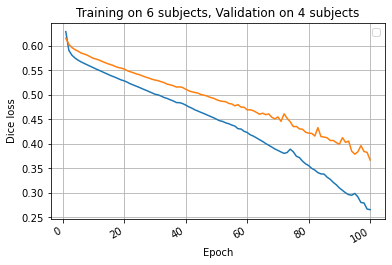

In [25]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

  0%|          | 0/1 [00:00<?, ?it/s]

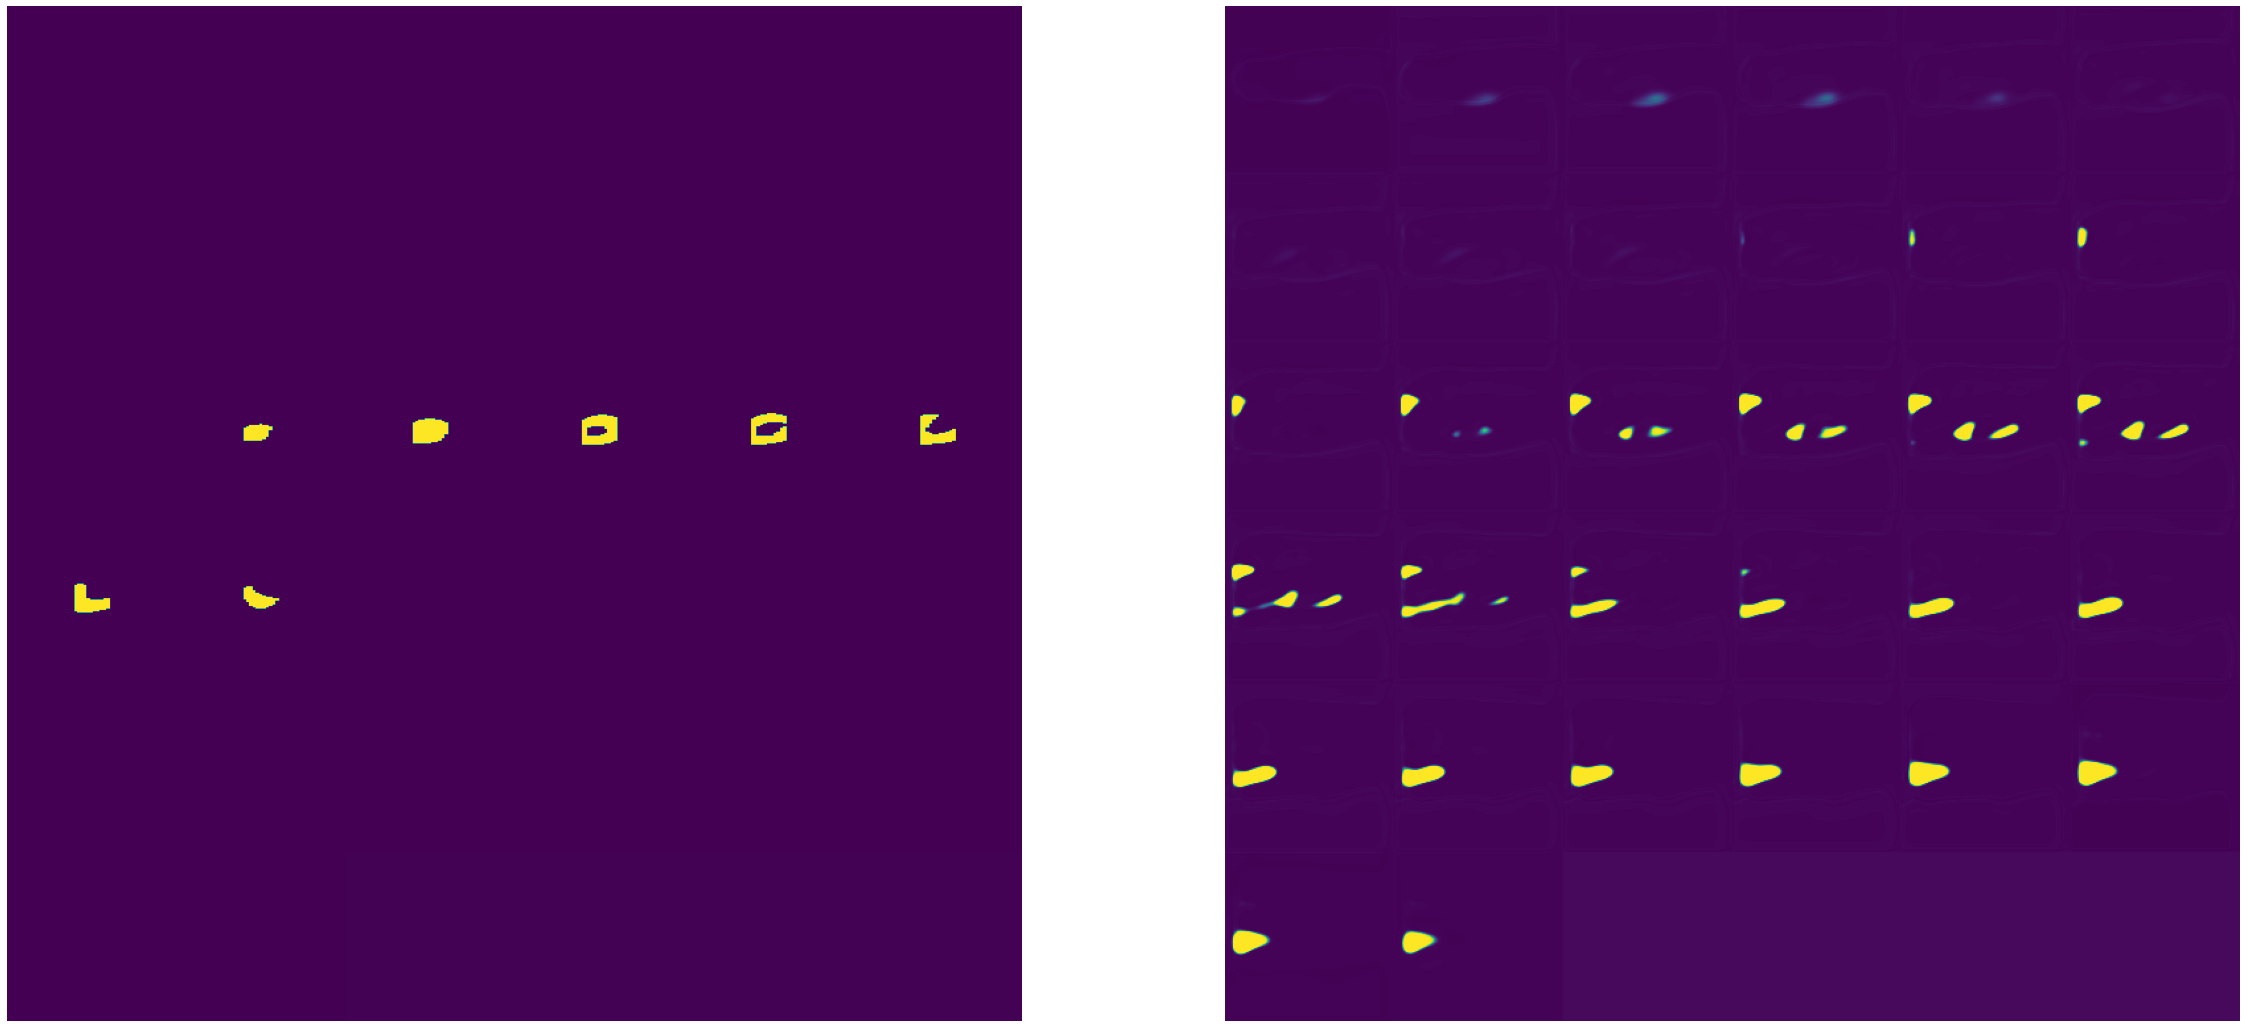

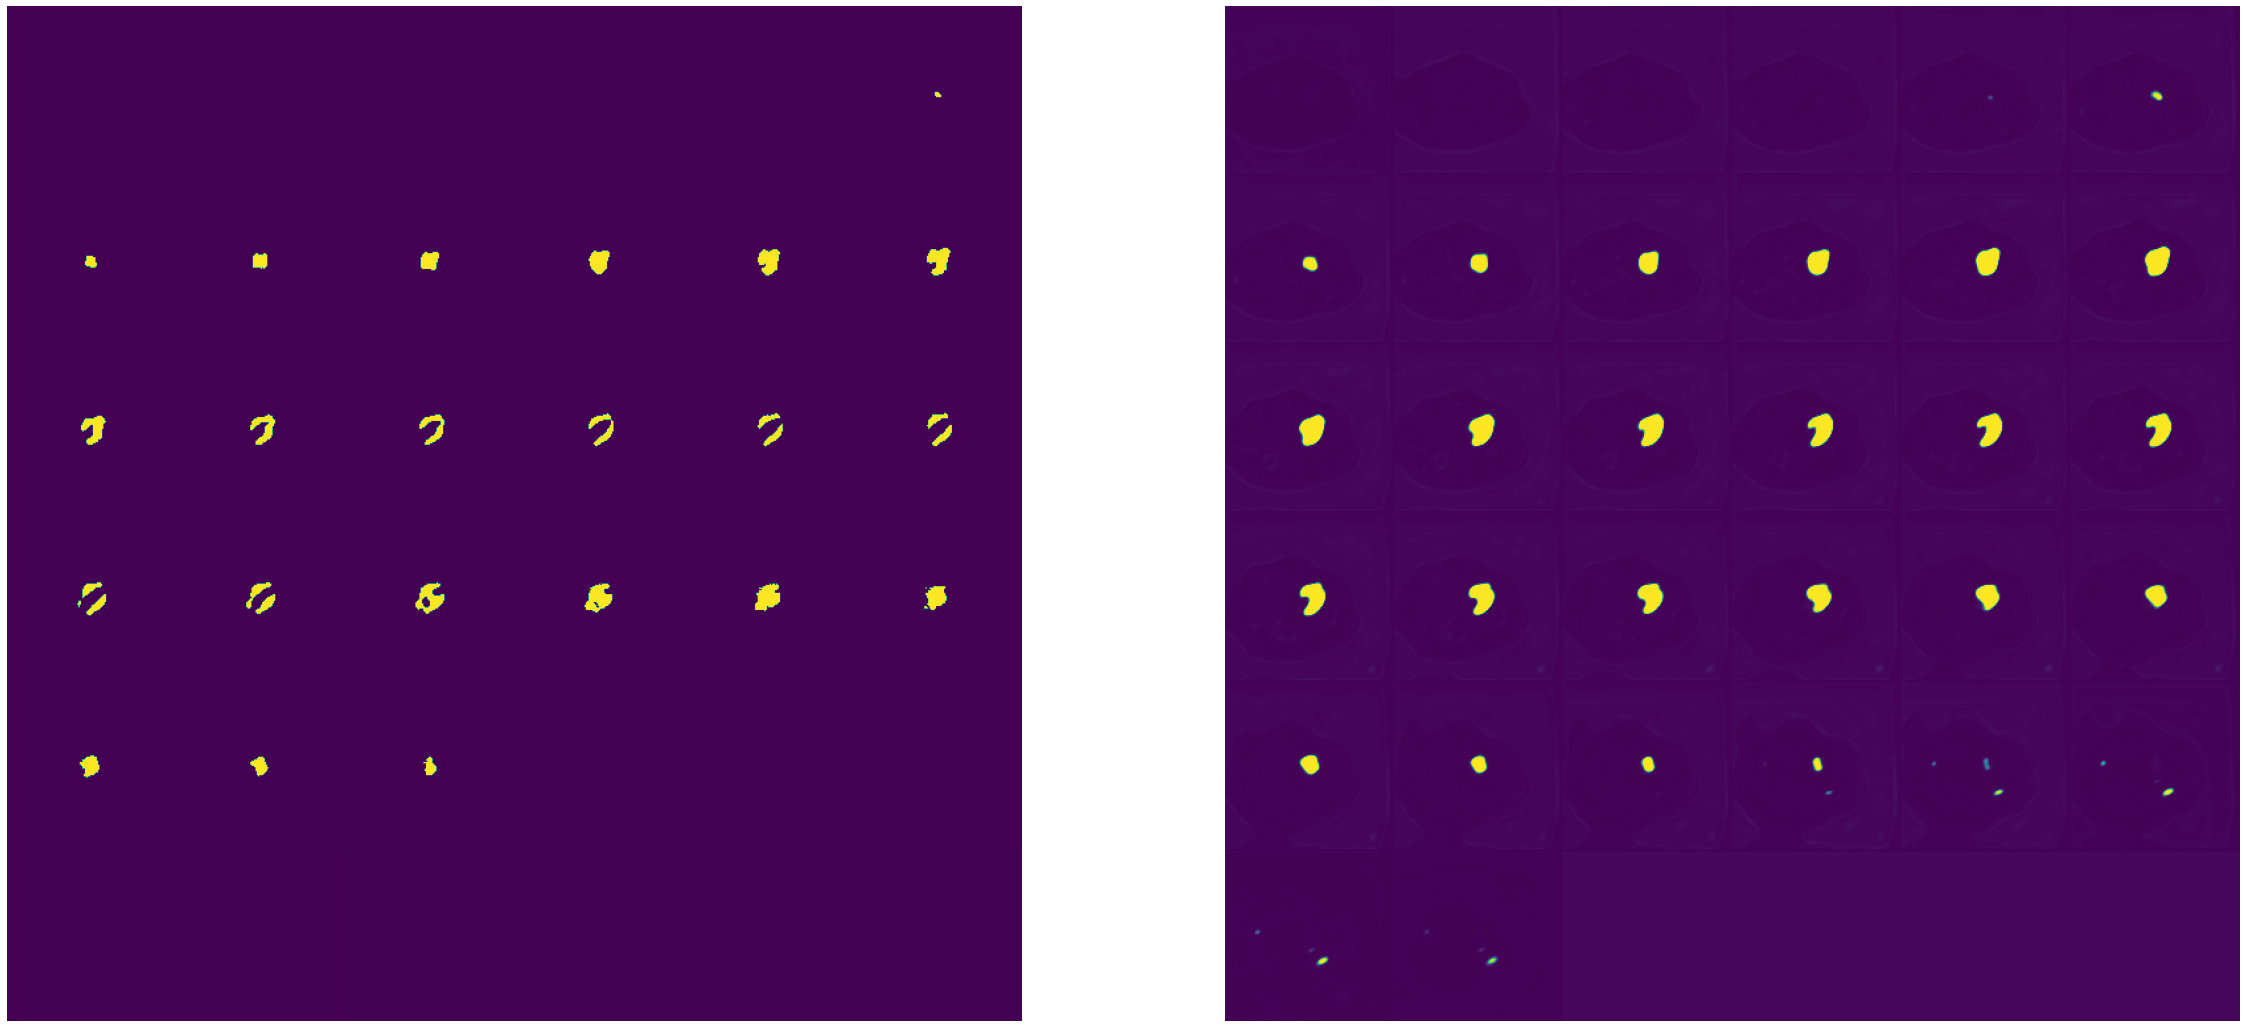

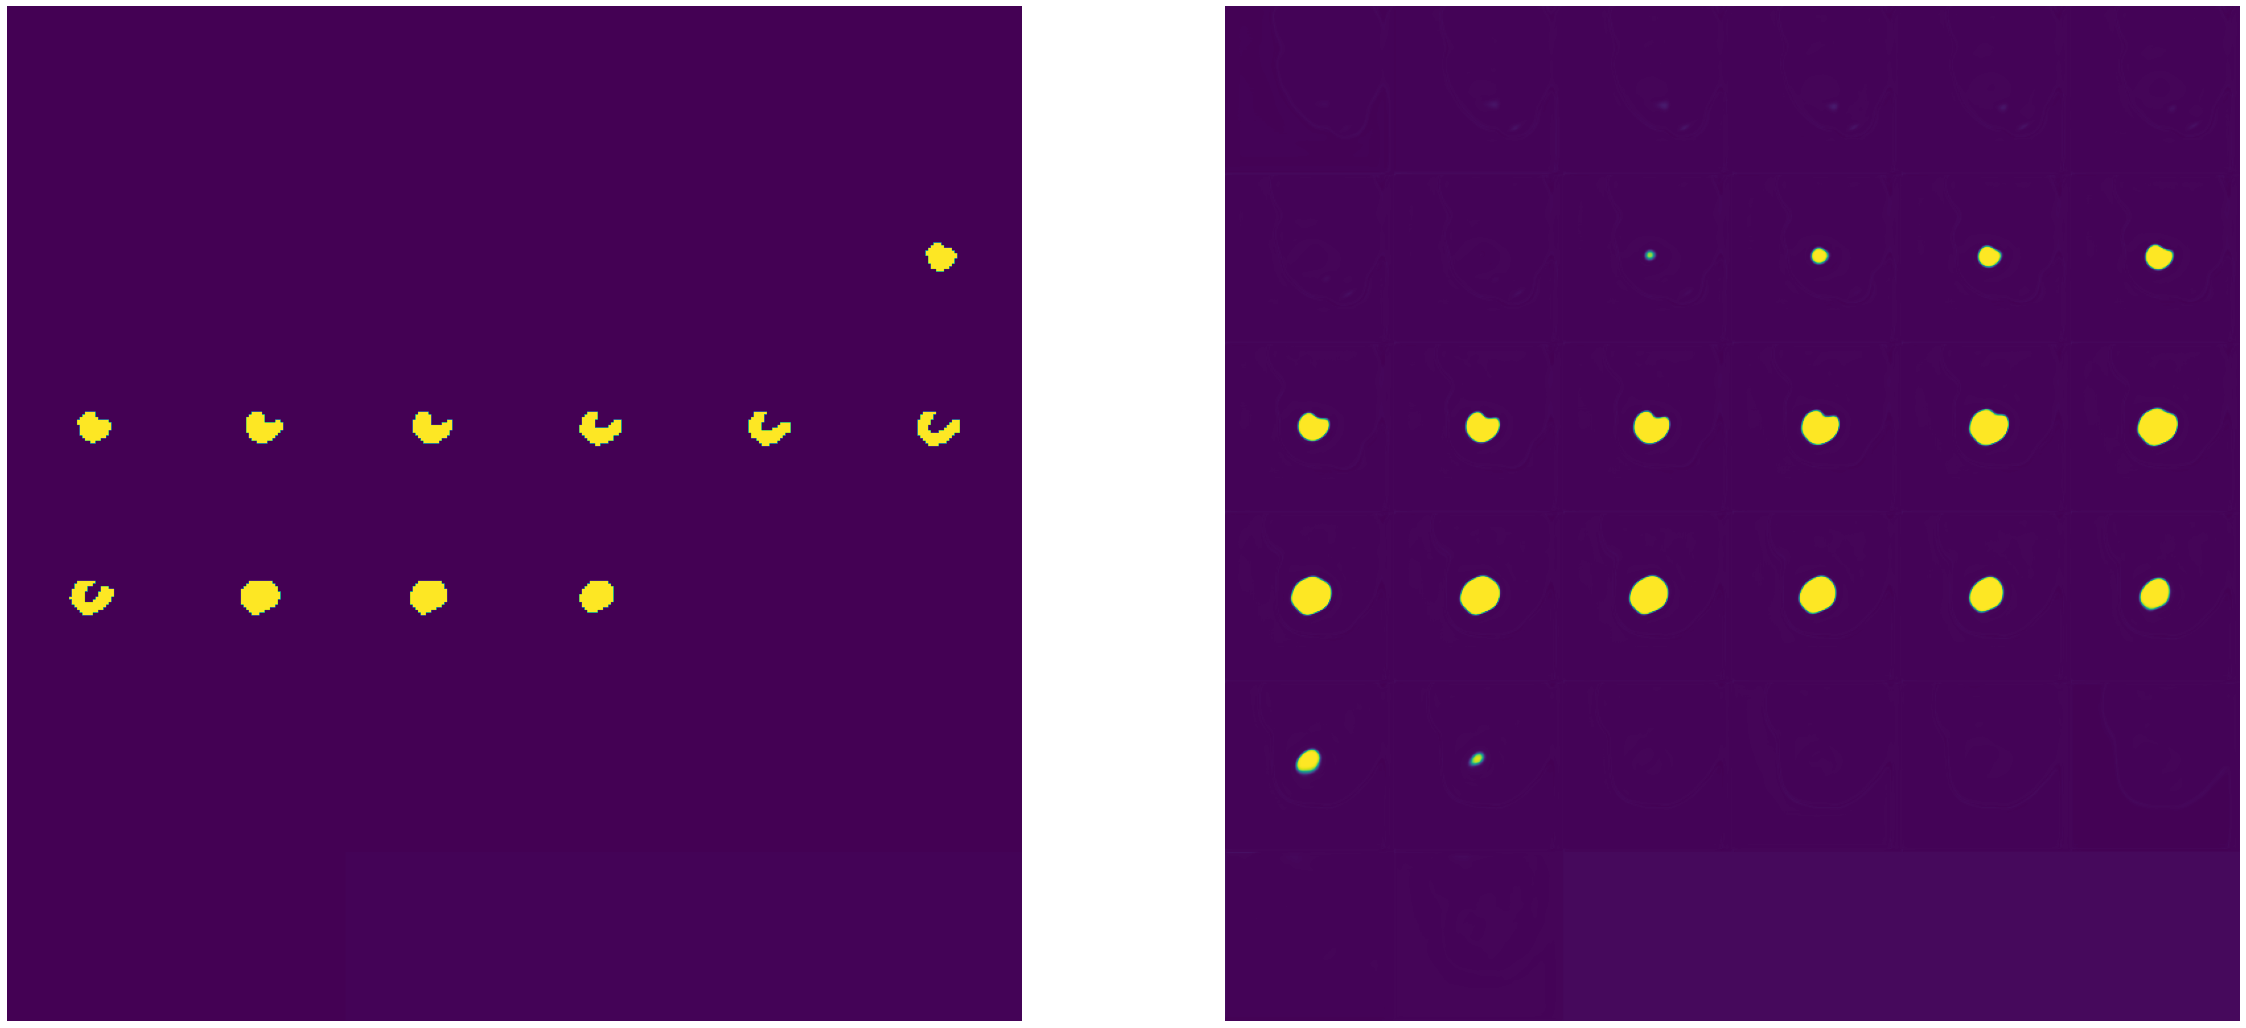

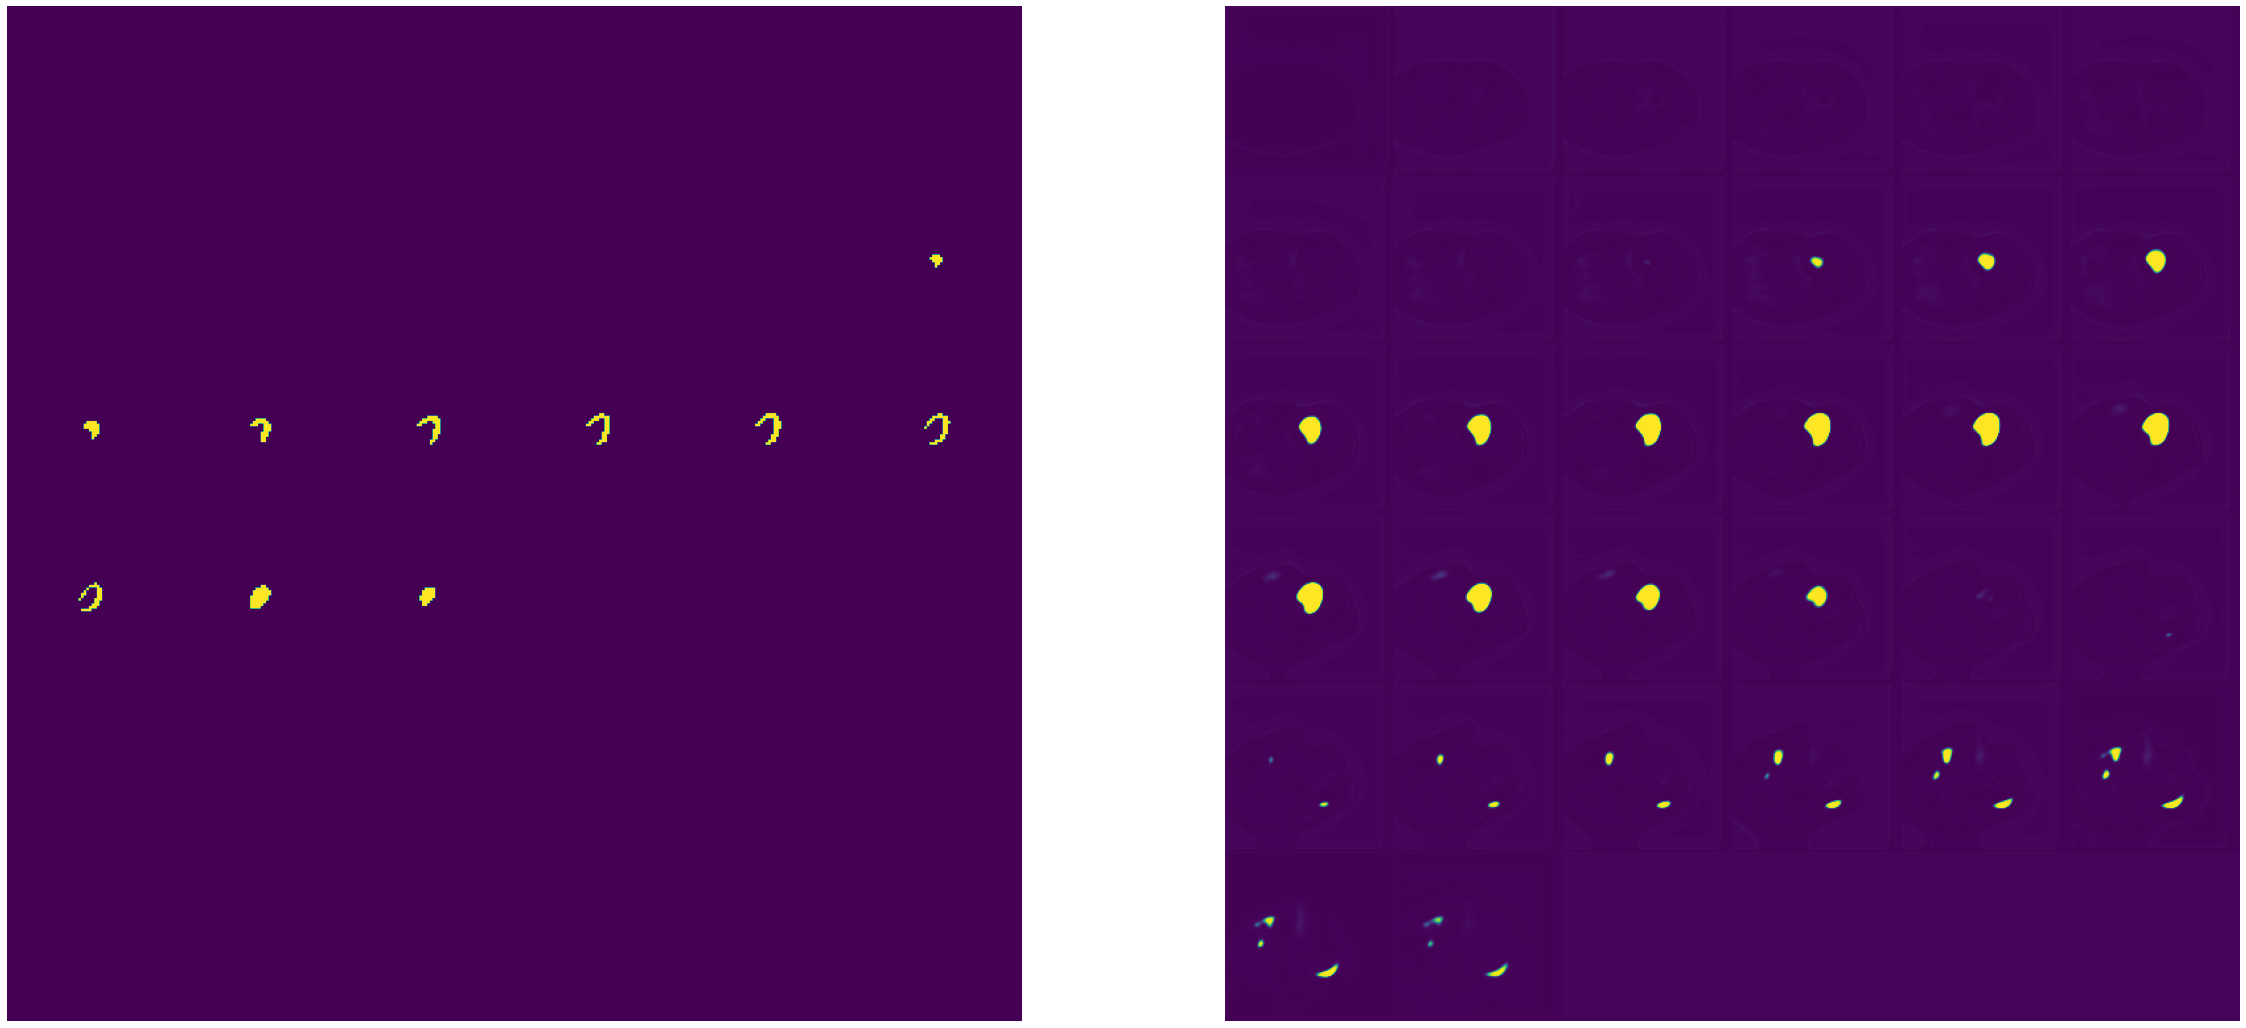

In [30]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

In [31]:
precision, recall, iou = compute_metrics(predictions, targets)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.4134
Recall: 0.7289
IoU: 0.3849


C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


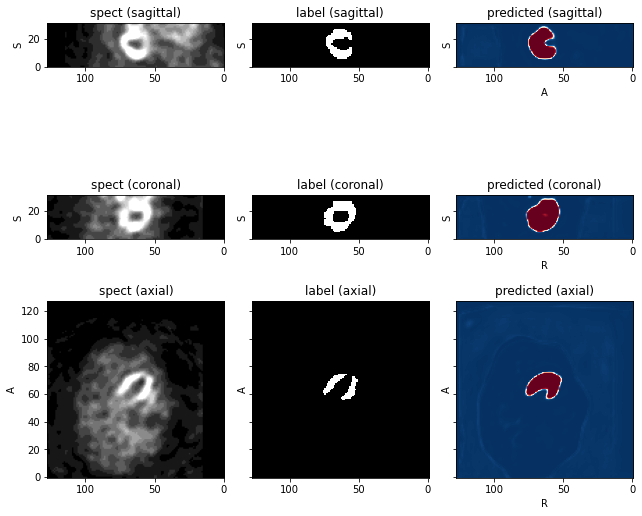

In [26]:
batch = next(iter(validation_loader))

model.eval()

inputs, targets = prepare_batch(batch, device)
FIRST = 1
FOREGROUND = 1

with torch.no_grad():

    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()

affine = batch['spect'][tio.AFFINE][0].numpy()

subject = tio.Subject(
    spect=tio.ScalarImage(tensor=batch['spect'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['left_ventricle'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

In [36]:
target_shape = (128, 128, 32)
max_displacement = (8, 8, 0)
num_control_points = 10

downsampling_factor = 3
original_spacing = 1
target_spacing = downsampling_factor / original_spacing  # in mm

patch_dim = 28
gap = 14


training_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape, mask_name="left_ventricle"),
    tio.ZNormalization(),
    tio.RandomFlip(axes=(0, 1, 2), p=0.5),
    tio.OneOf({
        tio.RandomAnisotropy(): 0.5,
        tio.RandomBlur(): 0.5,
        tio.RandomNoise(): 0.5,  
    }, p=0.5),
    tio.OneOf({
        tio.RandomAffine(): 0.5,
        tio.RandomElasticDeformation(max_displacement=max_displacement): 0.5,
        tio.RandomElasticDeformation(
            max_displacement=max_displacement,
            num_control_points=num_control_points
        ): 0.5,
        tio.RandomMotion(num_transforms=4, image_interpolation='linear'): 0.5
    }, p=0.8),
    tio.OneHot()
])

validation_transform = tio.Compose([
    tio.CropOrPad(target_shape=target_shape, mask_name="left_ventricle"),
    tio.ZNormalization(),
    tio.OneHot()
])

In [37]:
training_split_ratio = 0.6

num_subjects = len(dataset)

num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = (num_training_subjects, num_validation_subjects)
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(training_subjects, transform=training_transform)
validation_set = tio.SubjectsDataset(validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 6 subjects
Validation set: 4 subjects


In [38]:
training_batch_size = 2
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0,
)

In [35]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 500

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=0.0
).to(device)

model.encoder.load_state_dict(encoder_weights)


for name, param in model.named_parameters():
    
    if name.startswith('encoder'):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
        
"""
for name, param in model.named_parameters():
    
    if name.startswith('encoder') and 'blocks.1.' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
"""
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.650	Precision: 0.03	Recall: 0.94	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.615	Precision: 0.08	Recall: 1.00	IoU: 0.08
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.621	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.608	Precision: 0.09	Recall: 1.00	IoU: 0.09
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.615	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.602	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.609	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.597	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.605	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.593	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.601	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.590	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.598	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.587	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.594	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.583	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.591	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.580	Precision: 0.18	Recall: 0.99	IoU: 0.18
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.587	Precision: 0.12	Recall: 0.99	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.576	Precision: 0.19	Recall: 0.99	IoU: 0.19
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.583	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.574	Precision: 0.21	Recall: 0.97	IoU: 0.20
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.580	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.571	Precision: 0.23	Recall: 0.97	IoU: 0.21
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.578	Precision: 0.15	Recall: 0.94	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.568	Precision: 0.22	Recall: 0.95	IoU: 0.20
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.574	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.565	Precision: 0.25	Recall: 0.95	IoU: 0.24
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.571	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.561	Precision: 0.25	Recall: 0.95	IoU: 0.23
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.568	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.558	Precision: 0.26	Recall: 0.95	IoU: 0.24
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.565	Precision: 0.18	Recall: 0.99	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.557	Precision: 0.27	Recall: 0.93	IoU: 0.24
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.563	Precision: 0.20	Recall: 1.00	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.554	Precision: 0.27	Recall: 0.92	IoU: 0.24
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.560	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.551	Precision: 0.29	Recall: 0.93	IoU: 0.26
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.556	Precision: 0.22	Recall: 1.00	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.548	Precision: 0.30	Recall: 0.93	IoU: 0.27
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.556	Precision: 0.19	Recall: 0.97	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.545	Precision: 0.28	Recall: 0.95	IoU: 0.26
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.552	Precision: 0.20	Recall: 0.99	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544	Precision: 0.30	Recall: 0.92	IoU: 0.27
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.550	Precision: 0.21	Recall: 0.99	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.543	Precision: 0.31	Recall: 0.90	IoU: 0.26
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.546	Precision: 0.23	Recall: 1.00	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.540	Precision: 0.31	Recall: 0.90	IoU: 0.26
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.24	Recall: 1.00	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.538	Precision: 0.33	Recall: 0.90	IoU: 0.28
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.542	Precision: 0.24	Recall: 0.99	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Precision: 0.32	Recall: 0.90	IoU: 0.27
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.539	Precision: 0.24	Recall: 1.00	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.533	Precision: 0.32	Recall: 0.89	IoU: 0.27
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.538	Precision: 0.25	Recall: 0.95	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.530	Precision: 0.35	Recall: 0.91	IoU: 0.30
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.536	Precision: 0.24	Recall: 0.95	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.528	Precision: 0.31	Recall: 0.91	IoU: 0.26
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.533	Precision: 0.24	Recall: 0.99	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527	Precision: 0.33	Recall: 0.89	IoU: 0.27
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.25	Recall: 1.00	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.525	Precision: 0.36	Recall: 0.89	IoU: 0.30
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.27	Recall: 0.99	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521	Precision: 0.29	Recall: 0.92	IoU: 0.25
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.19	Recall: 0.97	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.519	Precision: 0.26	Recall: 0.94	IoU: 0.24
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.526	Precision: 0.20	Recall: 1.00	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515	Precision: 0.28	Recall: 0.94	IoU: 0.25
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.523	Precision: 0.23	Recall: 1.00	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.517	Precision: 0.35	Recall: 0.89	IoU: 0.29
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.519	Precision: 0.28	Recall: 0.99	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.34	Recall: 0.91	IoU: 0.29
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.519	Precision: 0.24	Recall: 0.99	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.511	Precision: 0.34	Recall: 0.91	IoU: 0.29
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.515	Precision: 0.27	Recall: 0.98	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.508	Precision: 0.34	Recall: 0.90	IoU: 0.28
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.515	Precision: 0.26	Recall: 0.97	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.507	Precision: 0.38	Recall: 0.90	IoU: 0.32
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.27	Recall: 0.99	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.39	Recall: 0.91	IoU: 0.33
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.509	Precision: 0.30	Recall: 0.98	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.40	Recall: 0.88	IoU: 0.33
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.506	Precision: 0.31	Recall: 0.99	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.38	Recall: 0.87	IoU: 0.31
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.504	Precision: 0.29	Recall: 1.00	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.499	Precision: 0.39	Recall: 0.87	IoU: 0.32
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.502	Precision: 0.32	Recall: 0.99	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.498	Precision: 0.41	Recall: 0.86	IoU: 0.33
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.503	Precision: 0.31	Recall: 0.98	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.497	Precision: 0.39	Recall: 0.86	IoU: 0.31
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.497	Precision: 0.31	Recall: 0.99	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.494	Precision: 0.42	Recall: 0.86	IoU: 0.33
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.497	Precision: 0.32	Recall: 0.98	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489	Precision: 0.40	Recall: 0.89	IoU: 0.33
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.27	Recall: 0.94	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489	Precision: 0.35	Recall: 0.89	IoU: 0.29
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.27	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.491	Precision: 0.31	Recall: 0.86	IoU: 0.24
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.490	Precision: 0.28	Recall: 0.98	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.485	Precision: 0.37	Recall: 0.88	IoU: 0.30
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.488	Precision: 0.29	Recall: 0.98	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.45	Recall: 0.87	IoU: 0.35
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.486	Precision: 0.32	Recall: 0.98	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.35	Recall: 0.87	IoU: 0.28
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.29	Recall: 1.00	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.480	Precision: 0.33	Recall: 0.87	IoU: 0.27
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.479	Precision: 0.29	Recall: 0.96	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.477	Precision: 0.36	Recall: 0.87	IoU: 0.29
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.478	Precision: 0.30	Recall: 1.00	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Precision: 0.41	Recall: 0.87	IoU: 0.33
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.477	Precision: 0.33	Recall: 0.99	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.476	Precision: 0.45	Recall: 0.84	IoU: 0.35
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.33	Recall: 0.90	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469	Precision: 0.40	Recall: 0.86	IoU: 0.32
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.471	Precision: 0.33	Recall: 0.98	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469	Precision: 0.42	Recall: 0.86	IoU: 0.33
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.37	Recall: 0.98	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.465	Precision: 0.41	Recall: 0.87	IoU: 0.32
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.469	Precision: 0.32	Recall: 0.99	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.46	Recall: 0.84	IoU: 0.35
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.34	Recall: 0.97	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.465	Precision: 0.39	Recall: 0.84	IoU: 0.30
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.459	Precision: 0.36	Recall: 0.98	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Precision: 0.45	Recall: 0.81	IoU: 0.34
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.38	Recall: 0.97	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.44	Recall: 0.87	IoU: 0.35
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.33	Recall: 0.97	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.39	Recall: 0.87	IoU: 0.31
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.34	Recall: 0.99	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.38	Recall: 0.85	IoU: 0.30
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.451	Precision: 0.35	Recall: 0.98	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.452	Precision: 0.44	Recall: 0.84	IoU: 0.35
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.34	Recall: 0.92	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.444	Precision: 0.45	Recall: 0.85	IoU: 0.36
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.444	Precision: 0.36	Recall: 0.99	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.448	Precision: 0.52	Recall: 0.82	IoU: 0.39
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.439	Precision: 0.42	Recall: 0.98	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.447	Precision: 0.53	Recall: 0.81	IoU: 0.39
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.442	Precision: 0.39	Recall: 0.85	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.34	Recall: 0.88	IoU: 0.28
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.440	Precision: 0.27	Recall: 0.98	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.40	Recall: 0.84	IoU: 0.31
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.433	Precision: 0.35	Recall: 0.96	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.435	Precision: 0.48	Recall: 0.84	IoU: 0.37
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: 0.39	Recall: 0.96	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.432	Precision: 0.50	Recall: 0.84	IoU: 0.38
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.431	Precision: 0.36	Recall: 0.87	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.431	Precision: 0.43	Recall: 0.85	IoU: 0.33
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.424	Precision: 0.38	Recall: 0.98	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.431	Precision: 0.49	Recall: 0.82	IoU: 0.37
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.419	Precision: 0.39	Recall: 0.98	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.417	Precision: 0.50	Recall: 0.86	IoU: 0.39
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.421	Precision: 0.37	Recall: 0.87	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.420	Precision: 0.48	Recall: 0.83	IoU: 0.37
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.413	Precision: 0.37	Recall: 0.96	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.422	Precision: 0.45	Recall: 0.82	IoU: 0.35
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.402	Precision: 0.43	Recall: 0.98	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.420	Precision: 0.54	Recall: 0.81	IoU: 0.41
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.47	Recall: 0.98	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Precision: 0.54	Recall: 0.83	IoU: 0.41
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.402	Precision: 0.41	Recall: 0.96	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.412	Precision: 0.47	Recall: 0.83	IoU: 0.36
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.40	Recall: 0.95	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Precision: 0.46	Recall: 0.81	IoU: 0.36
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.400	Precision: 0.37	Recall: 0.90	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.403	Precision: 0.48	Recall: 0.82	IoU: 0.37
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.399	Precision: 0.38	Recall: 0.89	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.395	Precision: 0.51	Recall: 0.84	IoU: 0.40
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.390	Precision: 0.39	Recall: 0.92	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.394	Precision: 0.52	Recall: 0.83	IoU: 0.40
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.385	Precision: 0.40	Recall: 0.96	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.408	Precision: 0.50	Recall: 0.74	IoU: 0.34
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.385	Precision: 0.40	Recall: 0.92	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.380	Precision: 0.43	Recall: 0.88	IoU: 0.35
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: 0.32	Recall: 0.92	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.381	Precision: 0.52	Recall: 0.81	IoU: 0.41
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: 0.40	Recall: 0.84	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.382	Precision: 0.54	Recall: 0.81	IoU: 0.41
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.364	Precision: 0.47	Recall: 0.93	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.382	Precision: 0.52	Recall: 0.82	IoU: 0.39
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.45	Recall: 0.97	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.380	Precision: 0.53	Recall: 0.81	IoU: 0.39
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.356	Precision: 0.45	Recall: 0.91	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.375	Precision: 0.54	Recall: 0.81	IoU: 0.39
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.48	Recall: 0.91	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.368	Precision: 0.50	Recall: 0.83	IoU: 0.38
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.347	Precision: 0.41	Recall: 0.95	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.56	Recall: 0.81	IoU: 0.41
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.50	Recall: 0.89	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.361	Precision: 0.56	Recall: 0.79	IoU: 0.41
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: 0.44	Recall: 0.93	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.369	Precision: 0.48	Recall: 0.75	IoU: 0.35
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.337	Precision: 0.45	Recall: 0.89	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Precision: 0.57	Recall: 0.75	IoU: 0.41
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.49	Recall: 0.91	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.55	Recall: 0.84	IoU: 0.43
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.46	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.337	Precision: 0.60	Recall: 0.81	IoU: 0.45
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: 0.50	Recall: 0.93	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.63	Recall: 0.79	IoU: 0.46
Starting epoch 101


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.299	Precision: 0.58	Recall: 0.92	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.60	Recall: 0.78	IoU: 0.44
Starting epoch 102


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.52	Recall: 0.96	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Precision: 0.66	Recall: 0.76	IoU: 0.48
Starting epoch 103


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.60	Recall: 0.88	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318	Precision: 0.60	Recall: 0.80	IoU: 0.46
Starting epoch 104


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.43	Recall: 0.80	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318	Precision: 0.58	Recall: 0.80	IoU: 0.44
Starting epoch 105


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: 0.57	Recall: 0.91	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.321	Precision: 0.71	Recall: 0.72	IoU: 0.49
Starting epoch 106


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: 0.56	Recall: 0.74	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.44	Recall: 0.87	IoU: 0.35
Starting epoch 107


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.35	Recall: 0.97	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.323	Precision: 0.55	Recall: 0.78	IoU: 0.42
Starting epoch 108


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.309	Precision: 0.50	Recall: 0.84	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316	Precision: 0.50	Recall: 0.83	IoU: 0.39
Starting epoch 109


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.294	Precision: 0.45	Recall: 0.97	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.69	Recall: 0.71	IoU: 0.47
Starting epoch 110


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: 0.53	Recall: 0.86	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.313	Precision: 0.58	Recall: 0.79	IoU: 0.42
Starting epoch 111


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.48	Recall: 0.84	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.60	Recall: 0.78	IoU: 0.44
Starting epoch 112


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.263	Precision: 0.57	Recall: 0.91	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.67	Recall: 0.74	IoU: 0.48
Starting epoch 113


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.58	Recall: 0.88	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.62	Recall: 0.79	IoU: 0.46
Starting epoch 114


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.56	Recall: 0.93	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.282	Precision: 0.68	Recall: 0.77	IoU: 0.50
Starting epoch 115


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.234	Precision: 0.66	Recall: 0.87	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.284	Precision: 0.73	Recall: 0.70	IoU: 0.50
Starting epoch 116


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.231	Precision: 0.62	Recall: 0.90	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.274	Precision: 0.70	Recall: 0.74	IoU: 0.50
Starting epoch 117


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.229	Precision: 0.66	Recall: 0.90	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.278	Precision: 0.76	Recall: 0.69	IoU: 0.51
Starting epoch 118


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.58	Recall: 0.80	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.268	Precision: 0.62	Recall: 0.80	IoU: 0.47
Starting epoch 119


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.251	Precision: 0.52	Recall: 0.86	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.330	Precision: 0.54	Recall: 0.53	IoU: 0.31
Starting epoch 120


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.55	Recall: 0.72	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.320	Precision: 0.48	Recall: 0.67	IoU: 0.31
Starting epoch 121


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.252	Precision: 0.50	Recall: 0.88	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.279	Precision: 0.60	Recall: 0.72	IoU: 0.43
Starting epoch 122


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.235	Precision: 0.56	Recall: 0.86	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.269	Precision: 0.77	Recall: 0.65	IoU: 0.51
Starting epoch 123


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.219	Precision: 0.70	Recall: 0.83	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.253	Precision: 0.65	Recall: 0.76	IoU: 0.49
Starting epoch 124


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.226	Precision: 0.54	Recall: 0.90	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.249	Precision: 0.67	Recall: 0.77	IoU: 0.50
Starting epoch 125


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.220	Precision: 0.60	Recall: 0.83	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.259	Precision: 0.73	Recall: 0.68	IoU: 0.49
Starting epoch 126


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.211	Precision: 0.62	Recall: 0.84	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.262	Precision: 0.65	Recall: 0.69	IoU: 0.45
Starting epoch 127


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.214	Precision: 0.59	Recall: 0.86	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.256	Precision: 0.75	Recall: 0.65	IoU: 0.49
Starting epoch 128


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.216	Precision: 0.70	Recall: 0.73	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.68	Recall: 0.78	IoU: 0.51
Starting epoch 129


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.223	Precision: 0.52	Recall: 0.90	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252	Precision: 0.58	Recall: 0.81	IoU: 0.45
Starting epoch 130


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.220	Precision: 0.52	Recall: 0.91	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.252	Precision: 0.72	Recall: 0.68	IoU: 0.49
Starting epoch 131


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.194	Precision: 0.70	Recall: 0.80	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.76	Recall: 0.65	IoU: 0.50
Starting epoch 132


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.186	Precision: 0.68	Recall: 0.87	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.69	Recall: 0.67	IoU: 0.47
Starting epoch 133


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.233	Precision: 0.59	Recall: 0.73	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.257	Precision: 0.70	Recall: 0.64	IoU: 0.45
Starting epoch 134


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.185	Precision: 0.70	Recall: 0.83	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.72	Recall: 0.70	IoU: 0.51
Starting epoch 135


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.182	Precision: 0.64	Recall: 0.88	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.228	Precision: 0.69	Recall: 0.73	IoU: 0.50
Starting epoch 136


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.193	Precision: 0.69	Recall: 0.79	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.228	Precision: 0.70	Recall: 0.73	IoU: 0.50
Starting epoch 137


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.213	Precision: 0.55	Recall: 0.86	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.229	Precision: 0.63	Recall: 0.79	IoU: 0.48
Starting epoch 138


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.162	Precision: 0.65	Recall: 0.94	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.260	Precision: 0.80	Recall: 0.54	IoU: 0.44
Starting epoch 139


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.163	Precision: 0.81	Recall: 0.79	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.225	Precision: 0.74	Recall: 0.67	IoU: 0.50
Starting epoch 140


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.174	Precision: 0.69	Recall: 0.84	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.235	Precision: 0.62	Recall: 0.73	IoU: 0.45
Starting epoch 141


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.210	Precision: 0.56	Recall: 0.81	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.66	Recall: 0.72	IoU: 0.47
Starting epoch 142


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.153	Precision: 0.70	Recall: 0.91	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.72	Recall: 0.39	IoU: 0.32
Starting epoch 143


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.190	Precision: 0.70	Recall: 0.77	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.57	Recall: 0.75	IoU: 0.42
Starting epoch 144


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.187	Precision: 0.55	Recall: 0.94	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.67	Recall: 0.65	IoU: 0.44
Starting epoch 145


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.166	Precision: 0.73	Recall: 0.81	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.68	Recall: 0.46	IoU: 0.35
Starting epoch 146


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.162	Precision: 0.76	Recall: 0.77	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.74	Recall: 0.71	IoU: 0.52
Starting epoch 147


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.190	Precision: 0.59	Recall: 0.88	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.63	Recall: 0.76	IoU: 0.47
Starting epoch 148


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.178	Precision: 0.63	Recall: 0.85	IoU: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.82	Recall: 0.54	IoU: 0.47
Starting epoch 149


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.81	Recall: 0.77	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.75	Recall: 0.71	IoU: 0.52
Starting epoch 150


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.166	Precision: 0.65	Recall: 0.89	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.72	Recall: 0.75	IoU: 0.53
Starting epoch 151


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.161	Precision: 0.67	Recall: 0.88	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.267	Precision: 0.86	Recall: 0.47	IoU: 0.39
Starting epoch 152


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.162	Precision: 0.74	Recall: 0.80	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.81	Recall: 0.65	IoU: 0.53
Starting epoch 153


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.156	Precision: 0.69	Recall: 0.84	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.199	Precision: 0.75	Recall: 0.69	IoU: 0.53
Starting epoch 154


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.148	Precision: 0.77	Recall: 0.81	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.199	Precision: 0.70	Recall: 0.72	IoU: 0.52
Starting epoch 155


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.141	Precision: 0.68	Recall: 0.92	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251	Precision: 0.75	Recall: 0.53	IoU: 0.40
Starting epoch 156


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.70	Recall: 0.82	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251	Precision: 0.72	Recall: 0.54	IoU: 0.40
Starting epoch 157


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.139	Precision: 0.71	Recall: 0.87	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.65	Recall: 0.69	IoU: 0.46
Starting epoch 158


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.159	Precision: 0.65	Recall: 0.88	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.71	Recall: 0.65	IoU: 0.48
Starting epoch 159


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.148	Precision: 0.79	Recall: 0.75	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.77	Recall: 0.65	IoU: 0.50
Starting epoch 160


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.122	Precision: 0.76	Recall: 0.89	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.68	Recall: 0.73	IoU: 0.50
Starting epoch 161


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.148	Precision: 0.69	Recall: 0.84	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.78	Recall: 0.61	IoU: 0.49
Starting epoch 162


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.134	Precision: 0.79	Recall: 0.81	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.81	Recall: 0.54	IoU: 0.45
Starting epoch 163


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.68	Recall: 0.82	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.64	Recall: 0.70	IoU: 0.46
Starting epoch 164


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.136	Precision: 0.68	Recall: 0.92	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.80	Recall: 0.59	IoU: 0.48
Starting epoch 165


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.134	Precision: 0.80	Recall: 0.78	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.83	Recall: 0.63	IoU: 0.53
Starting epoch 166


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.129	Precision: 0.75	Recall: 0.85	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.75	Recall: 0.73	IoU: 0.55
Starting epoch 167


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.125	Precision: 0.73	Recall: 0.89	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.73	Recall: 0.74	IoU: 0.54
Starting epoch 168


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.143	Precision: 0.73	Recall: 0.82	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.82	Recall: 0.64	IoU: 0.54
Starting epoch 169


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.128	Precision: 0.75	Recall: 0.84	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.75	Recall: 0.69	IoU: 0.52
Starting epoch 170


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.141	Precision: 0.70	Recall: 0.83	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.79	Recall: 0.65	IoU: 0.52
Starting epoch 171


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: 0.74	Recall: 0.87	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.84	Recall: 0.57	IoU: 0.48
Starting epoch 172


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.129	Precision: 0.77	Recall: 0.82	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.69	Recall: 0.76	IoU: 0.52
Starting epoch 173


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.138	Precision: 0.67	Recall: 0.88	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.73	Recall: 0.70	IoU: 0.52
Starting epoch 174


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.148	Precision: 0.74	Recall: 0.77	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.179	Precision: 0.78	Recall: 0.68	IoU: 0.53
Starting epoch 175


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.134	Precision: 0.74	Recall: 0.82	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.84	Recall: 0.52	IoU: 0.44
Starting epoch 176


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.143	Precision: 0.69	Recall: 0.82	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.70	Recall: 0.69	IoU: 0.48
Starting epoch 177


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.141	Precision: 0.65	Recall: 0.89	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.72	Recall: 0.65	IoU: 0.47
Starting epoch 178


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.151	Precision: 0.70	Recall: 0.81	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.85	Recall: 0.57	IoU: 0.49
Starting epoch 179


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.149	Precision: 0.77	Recall: 0.73	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.65	Recall: 0.75	IoU: 0.48
Starting epoch 180


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.171	Precision: 0.58	Recall: 0.91	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.68	Recall: 0.70	IoU: 0.47
Starting epoch 181


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.135	Precision: 0.72	Recall: 0.84	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.75	Recall: 0.62	IoU: 0.47
Starting epoch 182


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.127	Precision: 0.77	Recall: 0.84	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.85	Recall: 0.55	IoU: 0.47
Starting epoch 183


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.137	Precision: 0.74	Recall: 0.79	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.80	Recall: 0.64	IoU: 0.51
Starting epoch 184


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.140	Precision: 0.69	Recall: 0.85	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.195	Precision: 0.70	Recall: 0.70	IoU: 0.49
Starting epoch 185


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.122	Precision: 0.69	Recall: 0.92	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.77	Recall: 0.56	IoU: 0.45
Starting epoch 186


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.156	Precision: 0.77	Recall: 0.70	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.79	Recall: 0.55	IoU: 0.46
Starting epoch 187


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.139	Precision: 0.70	Recall: 0.84	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.63	Recall: 0.77	IoU: 0.48
Starting epoch 188


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.191	Precision: 0.54	Recall: 0.82	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.66	Recall: 0.75	IoU: 0.49
Starting epoch 189


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.128	Precision: 0.72	Recall: 0.89	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.77	Recall: 0.55	IoU: 0.43
Starting epoch 190


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.186	Precision: 0.71	Recall: 0.62	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.75	Recall: 0.66	IoU: 0.49
Starting epoch 191


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.147	Precision: 0.65	Recall: 0.87	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Precision: 0.62	Recall: 0.79	IoU: 0.47
Starting epoch 192


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.170	Precision: 0.58	Recall: 0.89	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.67	Recall: 0.74	IoU: 0.49
Starting epoch 193


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.153	Precision: 0.67	Recall: 0.82	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.196	Precision: 0.84	Recall: 0.58	IoU: 0.51
Starting epoch 194


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.129	Precision: 0.82	Recall: 0.74	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.79	Recall: 0.64	IoU: 0.52
Starting epoch 195


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.135	Precision: 0.70	Recall: 0.86	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.73	Recall: 0.66	IoU: 0.49
Starting epoch 196


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.74	Recall: 0.91	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.77	Recall: 0.55	IoU: 0.44
Starting epoch 197


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.168	Precision: 0.71	Recall: 0.71	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.82	Recall: 0.54	IoU: 0.46
Starting epoch 198


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.127	Precision: 0.75	Recall: 0.84	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.71	Recall: 0.67	IoU: 0.49
Starting epoch 199


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.145	Precision: 0.67	Recall: 0.83	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.199	Precision: 0.80	Recall: 0.59	IoU: 0.49
Starting epoch 200


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.117	Precision: 0.78	Recall: 0.83	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.81	Recall: 0.63	IoU: 0.53
Starting epoch 201


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.75	Recall: 0.90	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.83	Recall: 0.60	IoU: 0.52
Starting epoch 202


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.80	Recall: 0.87	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.178	Precision: 0.84	Recall: 0.61	IoU: 0.54
Starting epoch 203


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.134	Precision: 0.72	Recall: 0.82	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.168	Precision: 0.82	Recall: 0.65	IoU: 0.55
Starting epoch 204


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.78	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.236	Precision: 0.85	Recall: 0.45	IoU: 0.41
Starting epoch 205


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.145	Precision: 0.76	Recall: 0.73	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.75	Recall: 0.66	IoU: 0.51
Starting epoch 206


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.137	Precision: 0.65	Recall: 0.91	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.70	Recall: 0.71	IoU: 0.51
Starting epoch 207


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.128	Precision: 0.70	Recall: 0.87	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Precision: 0.84	Recall: 0.54	IoU: 0.47
Starting epoch 208


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.135	Precision: 0.80	Recall: 0.74	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.81	Recall: 0.56	IoU: 0.47
Starting epoch 209


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.137	Precision: 0.71	Recall: 0.86	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.66	Recall: 0.75	IoU: 0.50
Starting epoch 210


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.136	Precision: 0.62	Recall: 0.97	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.189	Precision: 0.80	Recall: 0.60	IoU: 0.49
Starting epoch 211


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.126	Precision: 0.77	Recall: 0.79	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.83	Recall: 0.56	IoU: 0.47
Starting epoch 212


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.74	Recall: 0.91	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.173	Precision: 0.71	Recall: 0.76	IoU: 0.54
Starting epoch 213


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.103	Precision: 0.75	Recall: 0.93	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.180	Precision: 0.73	Recall: 0.71	IoU: 0.53
Starting epoch 214


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.147	Precision: 0.73	Recall: 0.79	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.82	Recall: 0.60	IoU: 0.50
Starting epoch 215


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.171	Precision: 0.69	Recall: 0.69	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.75	Recall: 0.66	IoU: 0.51
Starting epoch 216


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.121	Precision: 0.70	Recall: 0.89	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.76	Recall: 0.66	IoU: 0.51
Starting epoch 217


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.131	Precision: 0.72	Recall: 0.83	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.87	Recall: 0.48	IoU: 0.42
Starting epoch 218


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.81	Recall: 0.83	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.209	Precision: 0.86	Recall: 0.54	IoU: 0.46
Starting epoch 219


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.123	Precision: 0.73	Recall: 0.85	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.174	Precision: 0.79	Recall: 0.66	IoU: 0.53
Starting epoch 220


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.72	Recall: 0.90	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.178	Precision: 0.81	Recall: 0.63	IoU: 0.52
Starting epoch 221


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.77	Recall: 0.83	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.85	Recall: 0.57	IoU: 0.50
Starting epoch 222


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.78	Recall: 0.88	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.185	Precision: 0.81	Recall: 0.60	IoU: 0.51
Starting epoch 223


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.115	Precision: 0.75	Recall: 0.85	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.78	Recall: 0.60	IoU: 0.49
Starting epoch 224


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.121	Precision: 0.72	Recall: 0.86	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.199	Precision: 0.76	Recall: 0.59	IoU: 0.48
Starting epoch 225


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.138	Precision: 0.71	Recall: 0.79	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.72	Recall: 0.63	IoU: 0.48
Starting epoch 226


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.79	Recall: 0.85	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.71	Recall: 0.63	IoU: 0.48
Starting epoch 227


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.129	Precision: 0.72	Recall: 0.82	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.75	Recall: 0.66	IoU: 0.51
Starting epoch 228


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.136	Precision: 0.69	Recall: 0.83	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.84	Recall: 0.56	IoU: 0.49
Starting epoch 229


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.82	Recall: 0.79	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.78	Recall: 0.57	IoU: 0.47
Starting epoch 230


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.132	Precision: 0.69	Recall: 0.84	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.67	Recall: 0.71	IoU: 0.47
Starting epoch 231


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.131	Precision: 0.69	Recall: 0.87	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.77	Recall: 0.61	IoU: 0.47
Starting epoch 232


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: 0.80	Recall: 0.79	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.78	Recall: 0.58	IoU: 0.46
Starting epoch 233


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.125	Precision: 0.77	Recall: 0.79	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.67	Recall: 0.72	IoU: 0.48
Starting epoch 234


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.70	Recall: 0.92	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.64	Recall: 0.75	IoU: 0.48
Starting epoch 235


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.141	Precision: 0.64	Recall: 0.89	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.81	Recall: 0.55	IoU: 0.46
Starting epoch 236


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.83	Recall: 0.80	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.85	Recall: 0.51	IoU: 0.45
Starting epoch 237


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.81	Recall: 0.84	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.179	Precision: 0.74	Recall: 0.68	IoU: 0.51
Starting epoch 238


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: 0.68	Recall: 0.91	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.73	Recall: 0.66	IoU: 0.49
Starting epoch 239


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.75	Recall: 0.87	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.77	Recall: 0.56	IoU: 0.45
Starting epoch 240


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.82	Recall: 0.82	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.209	Precision: 0.78	Recall: 0.54	IoU: 0.44
Starting epoch 241


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.098	Precision: 0.81	Recall: 0.86	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.69	Recall: 0.70	IoU: 0.49
Starting epoch 242


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.132	Precision: 0.68	Recall: 0.86	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.177	Precision: 0.74	Recall: 0.69	IoU: 0.52
Starting epoch 243


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.77	Recall: 0.88	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.173	Precision: 0.82	Recall: 0.63	IoU: 0.53
Starting epoch 244


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: 0.77	Recall: 0.80	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.170	Precision: 0.73	Recall: 0.72	IoU: 0.53
Starting epoch 245


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.72	Recall: 0.90	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.172	Precision: 0.73	Recall: 0.70	IoU: 0.52
Starting epoch 246


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.75	Recall: 0.93	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.83	Recall: 0.55	IoU: 0.47
Starting epoch 247


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.161	Precision: 0.74	Recall: 0.65	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.180	Precision: 0.77	Recall: 0.65	IoU: 0.51
Starting epoch 248


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.76	Recall: 0.89	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.68	Recall: 0.71	IoU: 0.48
Starting epoch 249


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.127	Precision: 0.68	Recall: 0.87	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.71	Recall: 0.69	IoU: 0.49
Starting epoch 250


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.132	Precision: 0.71	Recall: 0.82	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.80	Recall: 0.63	IoU: 0.50
Starting epoch 251


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.126	Precision: 0.77	Recall: 0.79	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.79	Recall: 0.58	IoU: 0.46
Starting epoch 252


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.75	Recall: 0.82	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.74	Recall: 0.59	IoU: 0.45
Starting epoch 253


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.77	Recall: 0.86	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.76	Recall: 0.57	IoU: 0.44
Starting epoch 254


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.74	Recall: 0.90	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.211	Precision: 0.77	Recall: 0.55	IoU: 0.44
Starting epoch 255


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.78	Recall: 0.82	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.238	Precision: 0.82	Recall: 0.45	IoU: 0.39
Starting epoch 256


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.83	Recall: 0.82	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.209	Precision: 0.76	Recall: 0.56	IoU: 0.45
Starting epoch 257


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.80	Recall: 0.88	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.83	Recall: 0.47	IoU: 0.40
Starting epoch 258


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.149	Precision: 0.71	Recall: 0.75	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.79	Recall: 0.52	IoU: 0.42
Starting epoch 259


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.112	Precision: 0.75	Recall: 0.86	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.236	Precision: 0.78	Recall: 0.48	IoU: 0.39
Starting epoch 260


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.108	Precision: 0.80	Recall: 0.81	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.195	Precision: 0.82	Recall: 0.57	IoU: 0.47
Starting epoch 261


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.78	Recall: 0.85	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.73	Recall: 0.68	IoU: 0.50
Starting epoch 262


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.094	Precision: 0.76	Recall: 0.92	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.189	Precision: 0.73	Recall: 0.65	IoU: 0.49
Starting epoch 263


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.79	Recall: 0.87	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.229	Precision: 0.85	Recall: 0.45	IoU: 0.40
Starting epoch 264


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.88	Recall: 0.80	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.82	Recall: 0.48	IoU: 0.41
Starting epoch 265


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.78	Recall: 0.87	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.79	Recall: 0.56	IoU: 0.46
Starting epoch 266


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.74	Recall: 0.93	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.196	Precision: 0.84	Recall: 0.54	IoU: 0.47
Starting epoch 267


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.093	Precision: 0.81	Recall: 0.86	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.214	Precision: 0.88	Recall: 0.48	IoU: 0.43
Starting epoch 268


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.83	Recall: 0.78	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.185	Precision: 0.83	Recall: 0.58	IoU: 0.49
Starting epoch 269


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.77	Recall: 0.92	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.180	Precision: 0.74	Recall: 0.67	IoU: 0.50
Starting epoch 270


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.125	Precision: 0.69	Recall: 0.86	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.76	Recall: 0.64	IoU: 0.50
Starting epoch 271


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.093	Precision: 0.80	Recall: 0.86	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.82	Recall: 0.58	IoU: 0.49
Starting epoch 272


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.098	Precision: 0.80	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.82	Recall: 0.60	IoU: 0.50
Starting epoch 273


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.78	Recall: 0.90	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.189	Precision: 0.81	Recall: 0.58	IoU: 0.48
Starting epoch 274


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.76	Recall: 0.80	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.214	Precision: 0.83	Recall: 0.51	IoU: 0.44
Starting epoch 275


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.77	Recall: 0.85	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.82	Recall: 0.50	IoU: 0.43
Starting epoch 276


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.79	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.79	Recall: 0.56	IoU: 0.45
Starting epoch 277


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.080	Precision: 0.80	Recall: 0.92	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.78	Recall: 0.55	IoU: 0.45
Starting epoch 278


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.083	Precision: 0.83	Recall: 0.87	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.78	Recall: 0.56	IoU: 0.46
Starting epoch 279


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.112	Precision: 0.76	Recall: 0.83	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.80	Recall: 0.51	IoU: 0.43
Starting epoch 280


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.145	Precision: 0.72	Recall: 0.73	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.75	Recall: 0.60	IoU: 0.48
Starting epoch 281


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.111	Precision: 0.73	Recall: 0.88	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.71	Recall: 0.65	IoU: 0.50
Starting epoch 282


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.77	Recall: 0.85	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.82	Recall: 0.46	IoU: 0.41
Starting epoch 283


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.185	Precision: 0.70	Recall: 0.62	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.72	Recall: 0.63	IoU: 0.48
Starting epoch 284


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.73	Recall: 0.95	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.75	Recall: 0.60	IoU: 0.47
Starting epoch 285


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.81	Recall: 0.92	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.242	Precision: 0.84	Recall: 0.44	IoU: 0.38
Starting epoch 286


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.121	Precision: 0.81	Recall: 0.74	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.83	Recall: 0.54	IoU: 0.46
Starting epoch 287


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.101	Precision: 0.80	Recall: 0.83	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.76	Recall: 0.66	IoU: 0.50
Starting epoch 288


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.126	Precision: 0.70	Recall: 0.85	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.72	Recall: 0.65	IoU: 0.48
Starting epoch 289


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.094	Precision: 0.80	Recall: 0.89	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.268	Precision: 0.88	Recall: 0.36	IoU: 0.33
Starting epoch 290


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.107	Precision: 0.84	Recall: 0.77	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.78	Recall: 0.51	IoU: 0.42
Starting epoch 291


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.74	Recall: 0.89	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.70	Recall: 0.63	IoU: 0.45
Starting epoch 292


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.114	Precision: 0.71	Recall: 0.89	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.74	Recall: 0.66	IoU: 0.49
Starting epoch 293


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.80	Recall: 0.88	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.83	Recall: 0.56	IoU: 0.49
Starting epoch 294


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.112	Precision: 0.80	Recall: 0.79	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.174	Precision: 0.77	Recall: 0.65	IoU: 0.52
Starting epoch 295


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.78	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.177	Precision: 0.68	Recall: 0.73	IoU: 0.51
Starting epoch 296


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.72	Recall: 0.93	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.170	Precision: 0.75	Recall: 0.68	IoU: 0.53
Starting epoch 297


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: 0.73	Recall: 0.84	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.88	Recall: 0.44	IoU: 0.40
Starting epoch 298


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.111	Precision: 0.84	Recall: 0.75	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.82	Recall: 0.53	IoU: 0.46
Starting epoch 299


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.097	Precision: 0.80	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.69	Recall: 0.66	IoU: 0.48
Starting epoch 300


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.144	Precision: 0.70	Recall: 0.81	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.58	Recall: 0.71	IoU: 0.43
Starting epoch 301


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.121	Precision: 0.65	Recall: 0.95	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.242	Precision: 0.67	Recall: 0.49	IoU: 0.38
Starting epoch 302


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.83	Recall: 0.76	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.71	Recall: 0.31	IoU: 0.28
Starting epoch 303


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.130	Precision: 0.76	Recall: 0.76	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.233	Precision: 0.66	Recall: 0.54	IoU: 0.39
Starting epoch 304


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.149	Precision: 0.66	Recall: 0.79	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.68	Recall: 0.68	IoU: 0.46
Starting epoch 305


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.73	Recall: 0.91	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.71	Recall: 0.68	IoU: 0.49
Starting epoch 306


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.74	Recall: 0.89	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.179	Precision: 0.79	Recall: 0.63	IoU: 0.51
Starting epoch 307


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.78	Recall: 0.83	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.86	Recall: 0.54	IoU: 0.48
Starting epoch 308


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.83	Recall: 0.77	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.84	Recall: 0.51	IoU: 0.45
Starting epoch 309


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.71	Recall: 0.86	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.76	Recall: 0.60	IoU: 0.48
Starting epoch 310


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.77	Recall: 0.92	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.78	Recall: 0.57	IoU: 0.47
Starting epoch 311


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.111	Precision: 0.80	Recall: 0.78	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.192	Precision: 0.83	Recall: 0.54	IoU: 0.47
Starting epoch 312


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.77	Recall: 0.80	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.77	Recall: 0.63	IoU: 0.50
Starting epoch 313


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.76	Recall: 0.90	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.71	Recall: 0.69	IoU: 0.50
Starting epoch 314


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.74	Recall: 0.92	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.75	Recall: 0.63	IoU: 0.49
Starting epoch 315


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.107	Precision: 0.78	Recall: 0.82	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.85	Recall: 0.52	IoU: 0.46
Starting epoch 316


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.78	Recall: 0.78	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.84	Recall: 0.51	IoU: 0.45
Starting epoch 317


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.80	Recall: 0.87	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.76	Recall: 0.55	IoU: 0.45
Starting epoch 318


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.107	Precision: 0.71	Recall: 0.92	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.237	Precision: 0.78	Recall: 0.45	IoU: 0.38
Starting epoch 319


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.137	Precision: 0.74	Recall: 0.77	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.236	Precision: 0.83	Recall: 0.43	IoU: 0.38
Starting epoch 320


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.111	Precision: 0.75	Recall: 0.84	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.63	Recall: 0.76	IoU: 0.48
Starting epoch 321


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.69	Recall: 0.95	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.195	Precision: 0.67	Recall: 0.70	IoU: 0.48
Starting epoch 322


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.132	Precision: 0.79	Recall: 0.78	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.77	Recall: 0.61	IoU: 0.49
Starting epoch 323


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.128	Precision: 0.75	Recall: 0.79	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.73	Recall: 0.70	IoU: 0.50
Starting epoch 324


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.69	Recall: 0.92	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.74	Recall: 0.62	IoU: 0.47
Starting epoch 325


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.119	Precision: 0.71	Recall: 0.87	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.229	Precision: 0.80	Recall: 0.50	IoU: 0.41
Starting epoch 326


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.78	Recall: 0.80	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.81	Recall: 0.52	IoU: 0.44
Starting epoch 327


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.75	Recall: 0.84	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.77	Recall: 0.62	IoU: 0.50
Starting epoch 328


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.66	Recall: 0.75	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.73	Recall: 0.65	IoU: 0.49
Starting epoch 329


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.76	Recall: 0.89	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.195	Precision: 0.72	Recall: 0.64	IoU: 0.48
Starting epoch 330


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.77	Recall: 0.80	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.75	Recall: 0.60	IoU: 0.48
Starting epoch 331


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.82	Recall: 0.78	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.74	Recall: 0.65	IoU: 0.50
Starting epoch 332


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.76	Recall: 0.86	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.74	Recall: 0.66	IoU: 0.50
Starting epoch 333


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.78	Recall: 0.87	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.75	Recall: 0.56	IoU: 0.43
Starting epoch 334


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.79	Recall: 0.89	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.74	Recall: 0.51	IoU: 0.41
Starting epoch 335


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.087	Precision: 0.81	Recall: 0.88	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.218	Precision: 0.78	Recall: 0.51	IoU: 0.42
Starting epoch 336


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.80	Recall: 0.81	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.76	Recall: 0.61	IoU: 0.48
Starting epoch 337


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.079	Precision: 0.78	Recall: 0.95	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.79	Recall: 0.60	IoU: 0.49
Starting epoch 338


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.094	Precision: 0.81	Recall: 0.85	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.211	Precision: 0.86	Recall: 0.49	IoU: 0.43
Starting epoch 339


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.87	Recall: 0.74	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.177	Precision: 0.71	Recall: 0.71	IoU: 0.51
Starting epoch 340


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.73	Recall: 0.92	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.178	Precision: 0.69	Recall: 0.72	IoU: 0.51
Starting epoch 341


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.72	Recall: 0.91	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.86	Recall: 0.50	IoU: 0.45
Starting epoch 342


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.093	Precision: 0.82	Recall: 0.85	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.88	Recall: 0.40	IoU: 0.37
Starting epoch 343


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.094	Precision: 0.85	Recall: 0.83	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.72	Recall: 0.67	IoU: 0.49
Starting epoch 344


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: 0.66	Recall: 0.94	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.75	Recall: 0.65	IoU: 0.50
Starting epoch 345


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.80	Recall: 0.90	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.86	Recall: 0.52	IoU: 0.45
Starting epoch 346


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.114	Precision: 0.88	Recall: 0.72	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.83	Recall: 0.59	IoU: 0.49
Starting epoch 347


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.81	Recall: 0.87	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.71	Recall: 0.69	IoU: 0.49
Starting epoch 348


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.70	Recall: 0.93	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.71	Recall: 0.67	IoU: 0.49
Starting epoch 349


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.73	Recall: 0.90	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.77	Recall: 0.59	IoU: 0.47
Starting epoch 350


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.103	Precision: 0.79	Recall: 0.83	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.79	Recall: 0.56	IoU: 0.45
Starting epoch 351


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.77	Recall: 0.88	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.192	Precision: 0.78	Recall: 0.59	IoU: 0.47
Starting epoch 352


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.75	Recall: 0.89	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.77	Recall: 0.59	IoU: 0.48
Starting epoch 353


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.108	Precision: 0.78	Recall: 0.82	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.80	Recall: 0.58	IoU: 0.48
Starting epoch 354


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.087	Precision: 0.82	Recall: 0.86	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.80	Recall: 0.60	IoU: 0.49
Starting epoch 355


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.127	Precision: 0.75	Recall: 0.78	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.74	Recall: 0.65	IoU: 0.49
Starting epoch 356


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.191	Precision: 0.57	Recall: 0.72	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.68	Recall: 0.64	IoU: 0.44
Starting epoch 357


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.097	Precision: 0.73	Recall: 0.94	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.229	Precision: 0.70	Recall: 0.53	IoU: 0.40
Starting epoch 358


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.122	Precision: 0.77	Recall: 0.77	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.71	Recall: 0.62	IoU: 0.46
Starting epoch 359


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.75	Recall: 0.86	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.72	Recall: 0.65	IoU: 0.48
Starting epoch 360


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.097	Precision: 0.77	Recall: 0.89	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.77	Recall: 0.59	IoU: 0.48
Starting epoch 361


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.117	Precision: 0.80	Recall: 0.77	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.76	Recall: 0.62	IoU: 0.49
Starting epoch 362


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.76	Recall: 0.90	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.179	Precision: 0.75	Recall: 0.65	IoU: 0.50
Starting epoch 363


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.79	Recall: 0.90	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.78	Recall: 0.60	IoU: 0.49
Starting epoch 364


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.81	Recall: 0.84	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.81	Recall: 0.53	IoU: 0.45
Starting epoch 365


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.080	Precision: 0.85	Recall: 0.85	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.78	Recall: 0.55	IoU: 0.45
Starting epoch 366


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.098	Precision: 0.79	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.77	Recall: 0.56	IoU: 0.46
Starting epoch 367


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: 0.84	Recall: 0.89	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.75	Recall: 0.57	IoU: 0.46
Starting epoch 368


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.088	Precision: 0.78	Recall: 0.90	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.78	Recall: 0.50	IoU: 0.42
Starting epoch 369


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.81	Recall: 0.80	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.78	Recall: 0.50	IoU: 0.41
Starting epoch 370


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.108	Precision: 0.80	Recall: 0.80	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.69	Recall: 0.59	IoU: 0.44
Starting epoch 371


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.107	Precision: 0.72	Recall: 0.89	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.72	Recall: 0.57	IoU: 0.44
Starting epoch 372


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.113	Precision: 0.75	Recall: 0.83	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.66	Recall: 0.63	IoU: 0.45
Starting epoch 373


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.083	Precision: 0.80	Recall: 0.90	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.227	Precision: 0.70	Recall: 0.51	IoU: 0.41
Starting epoch 374


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.140	Precision: 0.76	Recall: 0.73	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.227	Precision: 0.77	Recall: 0.48	IoU: 0.40
Starting epoch 375


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.83	Recall: 0.84	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.73	Recall: 0.54	IoU: 0.40
Starting epoch 376


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.122	Precision: 0.73	Recall: 0.81	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.247	Precision: 0.69	Recall: 0.49	IoU: 0.36
Starting epoch 377


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.128	Precision: 0.73	Recall: 0.82	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.286	Precision: 0.60	Recall: 0.40	IoU: 0.31
Starting epoch 378


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.74	Recall: 0.86	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.278	Precision: 0.58	Recall: 0.42	IoU: 0.32
Starting epoch 379


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.72	Recall: 0.92	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.59	Recall: 0.38	IoU: 0.31
Starting epoch 380


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.82	Recall: 0.85	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.62	Recall: 0.31	IoU: 0.27
Starting epoch 381


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.83	Recall: 0.82	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.234	Precision: 0.70	Recall: 0.50	IoU: 0.38
Starting epoch 382


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.76	Recall: 0.92	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.73	Recall: 0.57	IoU: 0.44
Starting epoch 383


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.76	Recall: 0.89	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.75	Recall: 0.54	IoU: 0.43
Starting epoch 384


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.76	Recall: 0.82	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.80	Recall: 0.47	IoU: 0.39
Starting epoch 385


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.81	Recall: 0.79	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.77	Recall: 0.51	IoU: 0.41
Starting epoch 386


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.76	Recall: 0.89	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.70	Recall: 0.54	IoU: 0.40
Starting epoch 387


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.127	Precision: 0.69	Recall: 0.83	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.75	Recall: 0.56	IoU: 0.43
Starting epoch 388


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.080	Precision: 0.79	Recall: 0.92	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.182	Precision: 0.80	Recall: 0.61	IoU: 0.49
Starting epoch 389


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.077	Precision: 0.83	Recall: 0.89	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.82	Recall: 0.60	IoU: 0.50
Starting epoch 390


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.097	Precision: 0.82	Recall: 0.82	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.181	Precision: 0.81	Recall: 0.61	IoU: 0.50
Starting epoch 391


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.121	Precision: 0.77	Recall: 0.78	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.170	Precision: 0.75	Recall: 0.68	IoU: 0.52
Starting epoch 392


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.70	Recall: 0.90	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.170	Precision: 0.75	Recall: 0.68	IoU: 0.52
Starting epoch 393


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.77	Recall: 0.84	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.82	Recall: 0.52	IoU: 0.45
Starting epoch 394


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.076	Precision: 0.86	Recall: 0.86	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.83	Recall: 0.46	IoU: 0.40
Starting epoch 395


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.89	Recall: 0.82	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.209	Precision: 0.79	Recall: 0.52	IoU: 0.43
Starting epoch 396


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.79	Recall: 0.86	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.73	Recall: 0.58	IoU: 0.45
Starting epoch 397


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.77	Recall: 0.92	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.73	Recall: 0.50	IoU: 0.41
Starting epoch 398


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.119	Precision: 0.75	Recall: 0.80	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.218	Precision: 0.78	Recall: 0.50	IoU: 0.42
Starting epoch 399


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.79	Recall: 0.86	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.74	Recall: 0.63	IoU: 0.48
Starting epoch 400


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.79	Recall: 0.87	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.71	Recall: 0.66	IoU: 0.49
Starting epoch 401


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.108	Precision: 0.77	Recall: 0.83	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.71	Recall: 0.66	IoU: 0.49
Starting epoch 402


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.137	Precision: 0.68	Recall: 0.83	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.71	Recall: 0.67	IoU: 0.49
Starting epoch 403


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.107	Precision: 0.73	Recall: 0.87	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.185	Precision: 0.75	Recall: 0.63	IoU: 0.48
Starting epoch 404


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.115	Precision: 0.78	Recall: 0.79	IoU: 0.65


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.80	Recall: 0.55	IoU: 0.45
Starting epoch 405


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.81	Recall: 0.87	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.77	Recall: 0.51	IoU: 0.41
Starting epoch 406


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.76	Recall: 0.86	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.76	Recall: 0.57	IoU: 0.45
Starting epoch 407


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.082	Precision: 0.79	Recall: 0.92	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.81	Recall: 0.48	IoU: 0.41
Starting epoch 408


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.81	Recall: 0.83	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.81	Recall: 0.47	IoU: 0.41
Starting epoch 409


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.80	Recall: 0.85	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.71	Recall: 0.62	IoU: 0.46
Starting epoch 410


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.74	Recall: 0.92	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.71	Recall: 0.62	IoU: 0.47
Starting epoch 411


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.78	Recall: 0.92	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.80	Recall: 0.50	IoU: 0.43
Starting epoch 412


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.117	Precision: 0.79	Recall: 0.78	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.81	Recall: 0.49	IoU: 0.41
Starting epoch 413


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.83	Recall: 0.86	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.76	Recall: 0.51	IoU: 0.41
Starting epoch 414


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: 0.75	Recall: 0.80	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.68	Recall: 0.56	IoU: 0.41
Starting epoch 415


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.119	Precision: 0.69	Recall: 0.88	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.65	Recall: 0.57	IoU: 0.40
Starting epoch 416


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.077	Precision: 0.79	Recall: 0.94	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.72	Recall: 0.47	IoU: 0.38
Starting epoch 417


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.083	Precision: 0.85	Recall: 0.84	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.80	Recall: 0.48	IoU: 0.41
Starting epoch 418


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.84	Recall: 0.82	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.192	Precision: 0.73	Recall: 0.60	IoU: 0.47
Starting epoch 419


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.79	Recall: 0.89	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.70	Recall: 0.65	IoU: 0.49
Starting epoch 420


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.76	Recall: 0.91	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.76	Recall: 0.54	IoU: 0.45
Starting epoch 421


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.79	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.228	Precision: 0.77	Recall: 0.46	IoU: 0.40
Starting epoch 422


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.85	Recall: 0.83	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.211	Precision: 0.79	Recall: 0.51	IoU: 0.43
Starting epoch 423


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.084	Precision: 0.85	Recall: 0.85	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.76	Recall: 0.59	IoU: 0.47
Starting epoch 424


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.77	Recall: 0.91	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.190	Precision: 0.76	Recall: 0.60	IoU: 0.47
Starting epoch 425


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.111	Precision: 0.74	Recall: 0.85	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.80	Recall: 0.53	IoU: 0.44
Starting epoch 426


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: 0.83	Recall: 0.92	IoU: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.84	Recall: 0.45	IoU: 0.40
Starting epoch 427


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.81	Recall: 0.84	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.82	Recall: 0.52	IoU: 0.44
Starting epoch 428


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.78	Recall: 0.88	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.196	Precision: 0.79	Recall: 0.56	IoU: 0.46
Starting epoch 429


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.074	Precision: 0.85	Recall: 0.87	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.77	Recall: 0.57	IoU: 0.47
Starting epoch 430


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.088	Precision: 0.80	Recall: 0.87	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.73	Recall: 0.63	IoU: 0.49
Starting epoch 431


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.78	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.70	Recall: 0.65	IoU: 0.48
Starting epoch 432


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: 0.80	Recall: 0.93	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.76	Recall: 0.57	IoU: 0.46
Starting epoch 433


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.074	Precision: 0.85	Recall: 0.88	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.81	Recall: 0.48	IoU: 0.42
Starting epoch 434


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.074	Precision: 0.87	Recall: 0.85	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.80	Recall: 0.51	IoU: 0.44
Starting epoch 435


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.079	Precision: 0.82	Recall: 0.89	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.74	Recall: 0.59	IoU: 0.46
Starting epoch 436


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.78	Recall: 0.90	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.73	Recall: 0.60	IoU: 0.47
Starting epoch 437


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.095	Precision: 0.77	Recall: 0.87	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.77	Recall: 0.55	IoU: 0.44
Starting epoch 438


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.116	Precision: 0.75	Recall: 0.80	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.214	Precision: 0.81	Recall: 0.50	IoU: 0.42
Starting epoch 439


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.084	Precision: 0.85	Recall: 0.84	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.75	Recall: 0.56	IoU: 0.44
Starting epoch 440


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.72	Recall: 0.84	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.69	Recall: 0.59	IoU: 0.42
Starting epoch 441


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: 0.81	Recall: 0.93	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.227	Precision: 0.70	Recall: 0.53	IoU: 0.39
Starting epoch 442


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.82	Recall: 0.84	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.237	Precision: 0.76	Recall: 0.44	IoU: 0.37
Starting epoch 443


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.083	Precision: 0.88	Recall: 0.81	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.69	Recall: 0.59	IoU: 0.45
Starting epoch 444


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: 0.69	Recall: 0.86	IoU: 0.64


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.62	Recall: 0.71	IoU: 0.46
Starting epoch 445


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: 0.70	Recall: 0.96	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.68	Recall: 0.65	IoU: 0.46
Starting epoch 446


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.80	Recall: 0.84	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.225	Precision: 0.82	Recall: 0.46	IoU: 0.40
Starting epoch 447


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.109	Precision: 0.85	Recall: 0.74	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.78	Recall: 0.50	IoU: 0.41
Starting epoch 448


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.098	Precision: 0.78	Recall: 0.86	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.71	Recall: 0.58	IoU: 0.44
Starting epoch 449


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.089	Precision: 0.76	Recall: 0.92	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.75	Recall: 0.56	IoU: 0.44
Starting epoch 450


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.83	Recall: 0.88	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.82	Recall: 0.49	IoU: 0.42
Starting epoch 451


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: 0.88	Recall: 0.85	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.80	Recall: 0.55	IoU: 0.45
Starting epoch 452


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.101	Precision: 0.81	Recall: 0.81	IoU: 0.69


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.74	Recall: 0.64	IoU: 0.48
Starting epoch 453


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.075	Precision: 0.81	Recall: 0.91	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.72	Recall: 0.67	IoU: 0.49
Starting epoch 454


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.071	Precision: 0.81	Recall: 0.94	IoU: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.74	Recall: 0.63	IoU: 0.48
Starting epoch 455


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.071	Precision: 0.84	Recall: 0.90	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.195	Precision: 0.78	Recall: 0.57	IoU: 0.46
Starting epoch 456


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.079	Precision: 0.85	Recall: 0.86	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.192	Precision: 0.76	Recall: 0.59	IoU: 0.47
Starting epoch 457


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.084	Precision: 0.78	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.77	Recall: 0.56	IoU: 0.45
Starting epoch 458


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.066	Precision: 0.83	Recall: 0.94	IoU: 0.78


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.225	Precision: 0.84	Recall: 0.45	IoU: 0.40
Starting epoch 459


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.89	Recall: 0.78	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.78	Recall: 0.54	IoU: 0.44
Starting epoch 460


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: 0.78	Recall: 0.89	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.196	Precision: 0.68	Recall: 0.63	IoU: 0.46
Starting epoch 461


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.093	Precision: 0.74	Recall: 0.93	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.78	Recall: 0.53	IoU: 0.45
Starting epoch 462


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.88	Recall: 0.84	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.81	Recall: 0.49	IoU: 0.43
Starting epoch 463


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.064	Precision: 0.87	Recall: 0.90	IoU: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.79	Recall: 0.53	IoU: 0.44
Starting epoch 464


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.097	Precision: 0.80	Recall: 0.84	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.79	Recall: 0.52	IoU: 0.44
Starting epoch 465


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.104	Precision: 0.78	Recall: 0.82	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.77	Recall: 0.57	IoU: 0.46
Starting epoch 466


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.099	Precision: 0.74	Recall: 0.91	IoU: 0.68


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.81	Recall: 0.53	IoU: 0.45
Starting epoch 467


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.070	Precision: 0.85	Recall: 0.89	IoU: 0.77


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.83	Recall: 0.52	IoU: 0.45
Starting epoch 468


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.076	Precision: 0.85	Recall: 0.87	IoU: 0.75


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.83	Recall: 0.53	IoU: 0.46
Starting epoch 469


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.183	Precision: 0.66	Recall: 0.66	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.63	Recall: 0.70	IoU: 0.46
Starting epoch 470


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.135	Precision: 0.63	Recall: 0.90	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Precision: 0.64	Recall: 0.68	IoU: 0.45
Starting epoch 471


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.118	Precision: 0.69	Recall: 0.90	IoU: 0.63


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.75	Recall: 0.56	IoU: 0.46
Starting epoch 472


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.131	Precision: 0.79	Recall: 0.71	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.82	Recall: 0.51	IoU: 0.44
Starting epoch 473


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.135	Precision: 0.76	Recall: 0.72	IoU: 0.60


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.81	Recall: 0.56	IoU: 0.47
Starting epoch 474


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.79	Recall: 0.88	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.187	Precision: 0.75	Recall: 0.63	IoU: 0.48
Starting epoch 475


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.077	Precision: 0.82	Recall: 0.90	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.79	Recall: 0.57	IoU: 0.46
Starting epoch 476


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.80	Recall: 0.84	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.78	Recall: 0.53	IoU: 0.43
Starting epoch 477


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.087	Precision: 0.80	Recall: 0.89	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.80	Recall: 0.42	IoU: 0.36
Starting epoch 478


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.86	Recall: 0.82	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.250	Precision: 0.77	Recall: 0.42	IoU: 0.36
Starting epoch 479


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.106	Precision: 0.77	Recall: 0.83	IoU: 0.67


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.235	Precision: 0.70	Recall: 0.48	IoU: 0.38
Starting epoch 480


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.79	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.246	Precision: 0.71	Recall: 0.45	IoU: 0.36
Starting epoch 481


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.117	Precision: 0.74	Recall: 0.82	IoU: 0.66


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.246	Precision: 0.70	Recall: 0.46	IoU: 0.36
Starting epoch 482


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.83	Recall: 0.85	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.234	Precision: 0.71	Recall: 0.49	IoU: 0.38
Starting epoch 483


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.80	Recall: 0.85	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.70	Recall: 0.54	IoU: 0.41
Starting epoch 484


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.088	Precision: 0.77	Recall: 0.91	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.261	Precision: 0.70	Recall: 0.42	IoU: 0.34
Starting epoch 485


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.082	Precision: 0.85	Recall: 0.84	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.269	Precision: 0.70	Recall: 0.40	IoU: 0.33
Starting epoch 486


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.83	Recall: 0.83	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.240	Precision: 0.68	Recall: 0.49	IoU: 0.37
Starting epoch 487


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.085	Precision: 0.79	Recall: 0.89	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.66	Recall: 0.57	IoU: 0.41
Starting epoch 488


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: 0.84	Recall: 0.90	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.229	Precision: 0.70	Recall: 0.50	IoU: 0.39
Starting epoch 489


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.063	Precision: 0.86	Recall: 0.90	IoU: 0.79


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.240	Precision: 0.73	Recall: 0.45	IoU: 0.37
Starting epoch 490


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.091	Precision: 0.84	Recall: 0.81	IoU: 0.71


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.71	Recall: 0.52	IoU: 0.40
Starting epoch 491


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.094	Precision: 0.75	Recall: 0.91	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.214	Precision: 0.68	Recall: 0.57	IoU: 0.42
Starting epoch 492


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.125	Precision: 0.68	Recall: 0.86	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.73	Recall: 0.52	IoU: 0.41
Starting epoch 493


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.83	Recall: 0.89	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.78	Recall: 0.47	IoU: 0.39
Starting epoch 494


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.145	Precision: 0.70	Recall: 0.74	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.70	Recall: 0.60	IoU: 0.45
Starting epoch 495


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.078	Precision: 0.78	Recall: 0.93	IoU: 0.74


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.68	Recall: 0.61	IoU: 0.44
Starting epoch 496


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: 0.83	Recall: 0.91	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.218	Precision: 0.71	Recall: 0.53	IoU: 0.41
Starting epoch 497


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.083	Precision: 0.83	Recall: 0.86	IoU: 0.73


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.241	Precision: 0.74	Recall: 0.45	IoU: 0.37
Starting epoch 498


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.086	Precision: 0.83	Recall: 0.85	IoU: 0.72


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.70	Recall: 0.51	IoU: 0.39
Starting epoch 499


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.074	Precision: 0.80	Recall: 0.94	IoU: 0.76


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.71	Recall: 0.50	IoU: 0.39
Starting epoch 500


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: 0.79	Recall: 0.86	IoU: 0.70


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.232	Precision: 0.72	Recall: 0.48	IoU: 0.38


No handles with labels found to put in legend.


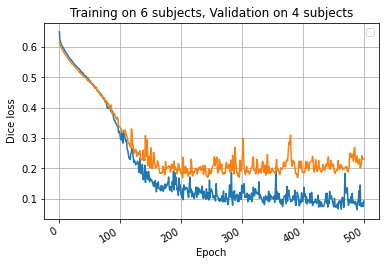

In [36]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


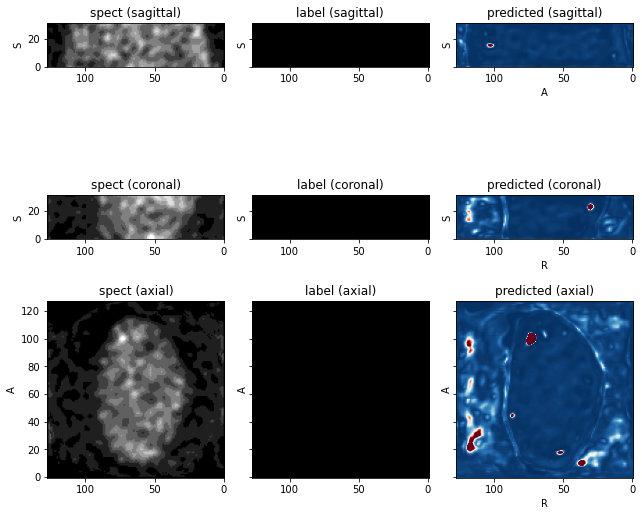

In [37]:
batch = next(iter(validation_loader))

model.eval()

inputs, targets = prepare_batch(batch, device)
FIRST = 1
FOREGROUND = 1

with torch.no_grad():

    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()

affine = batch['spect'][tio.AFFINE][0].numpy()

subject = tio.Subject(
    spect=tio.ScalarImage(tensor=batch['spect'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['left_ventricle'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

  0%|          | 0/1 [00:00<?, ?it/s]

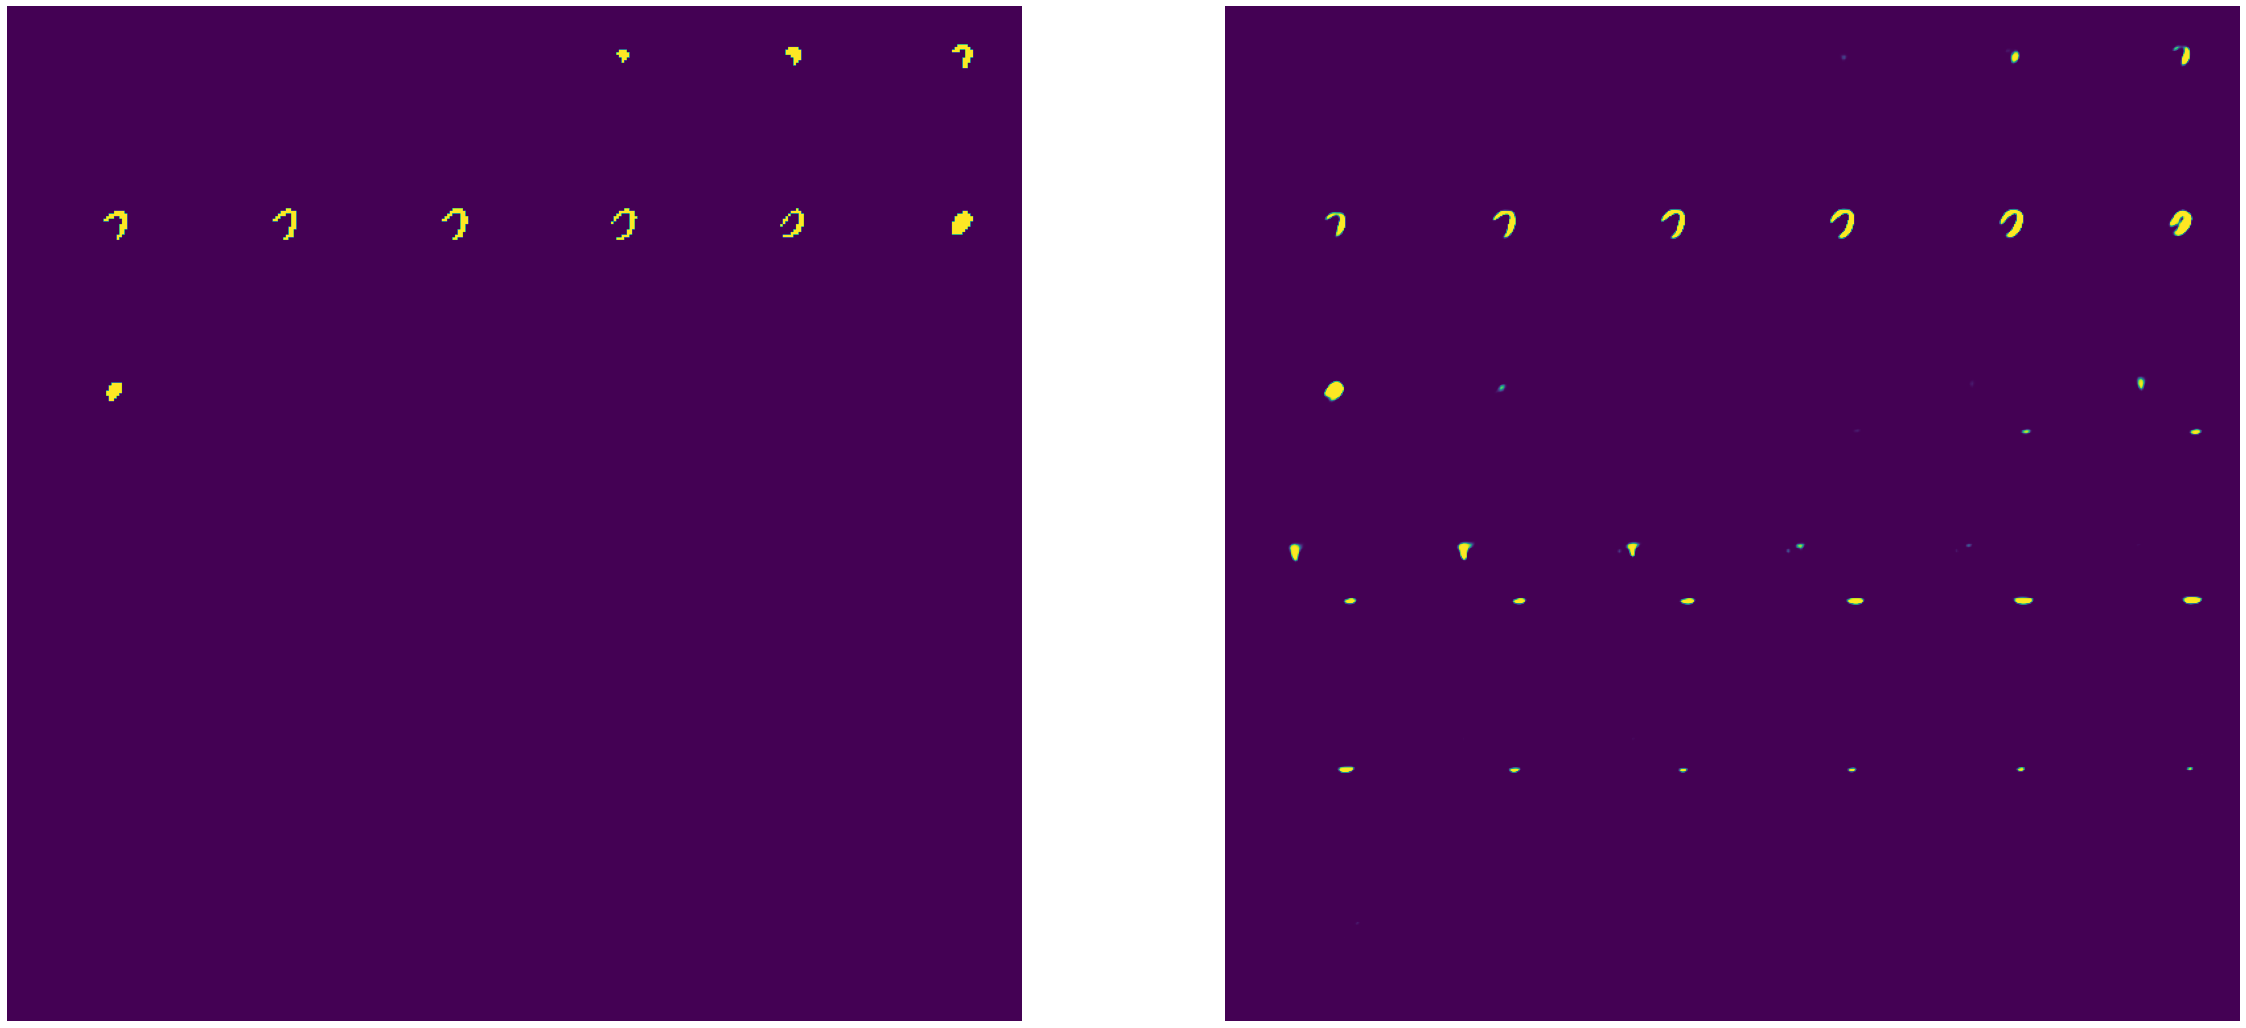

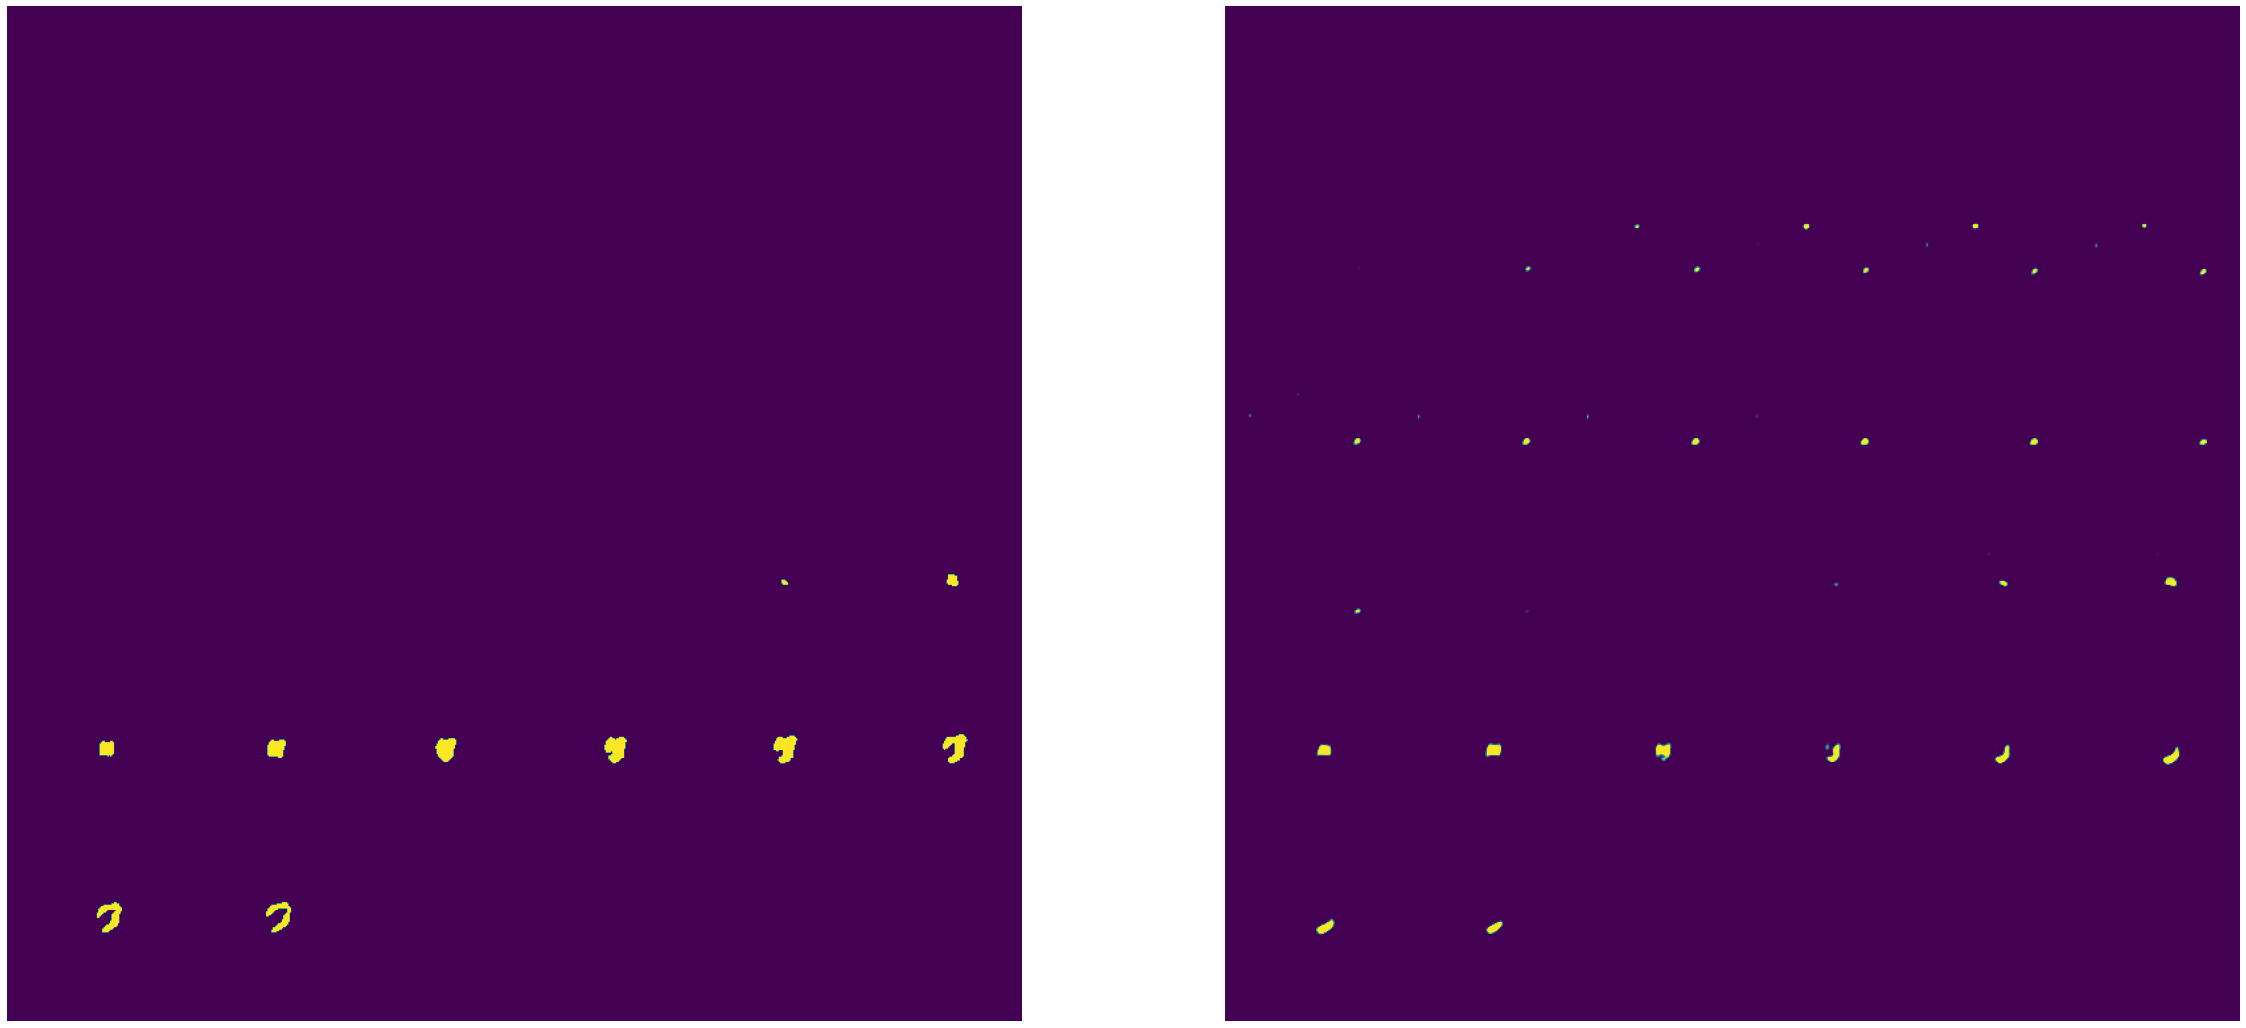

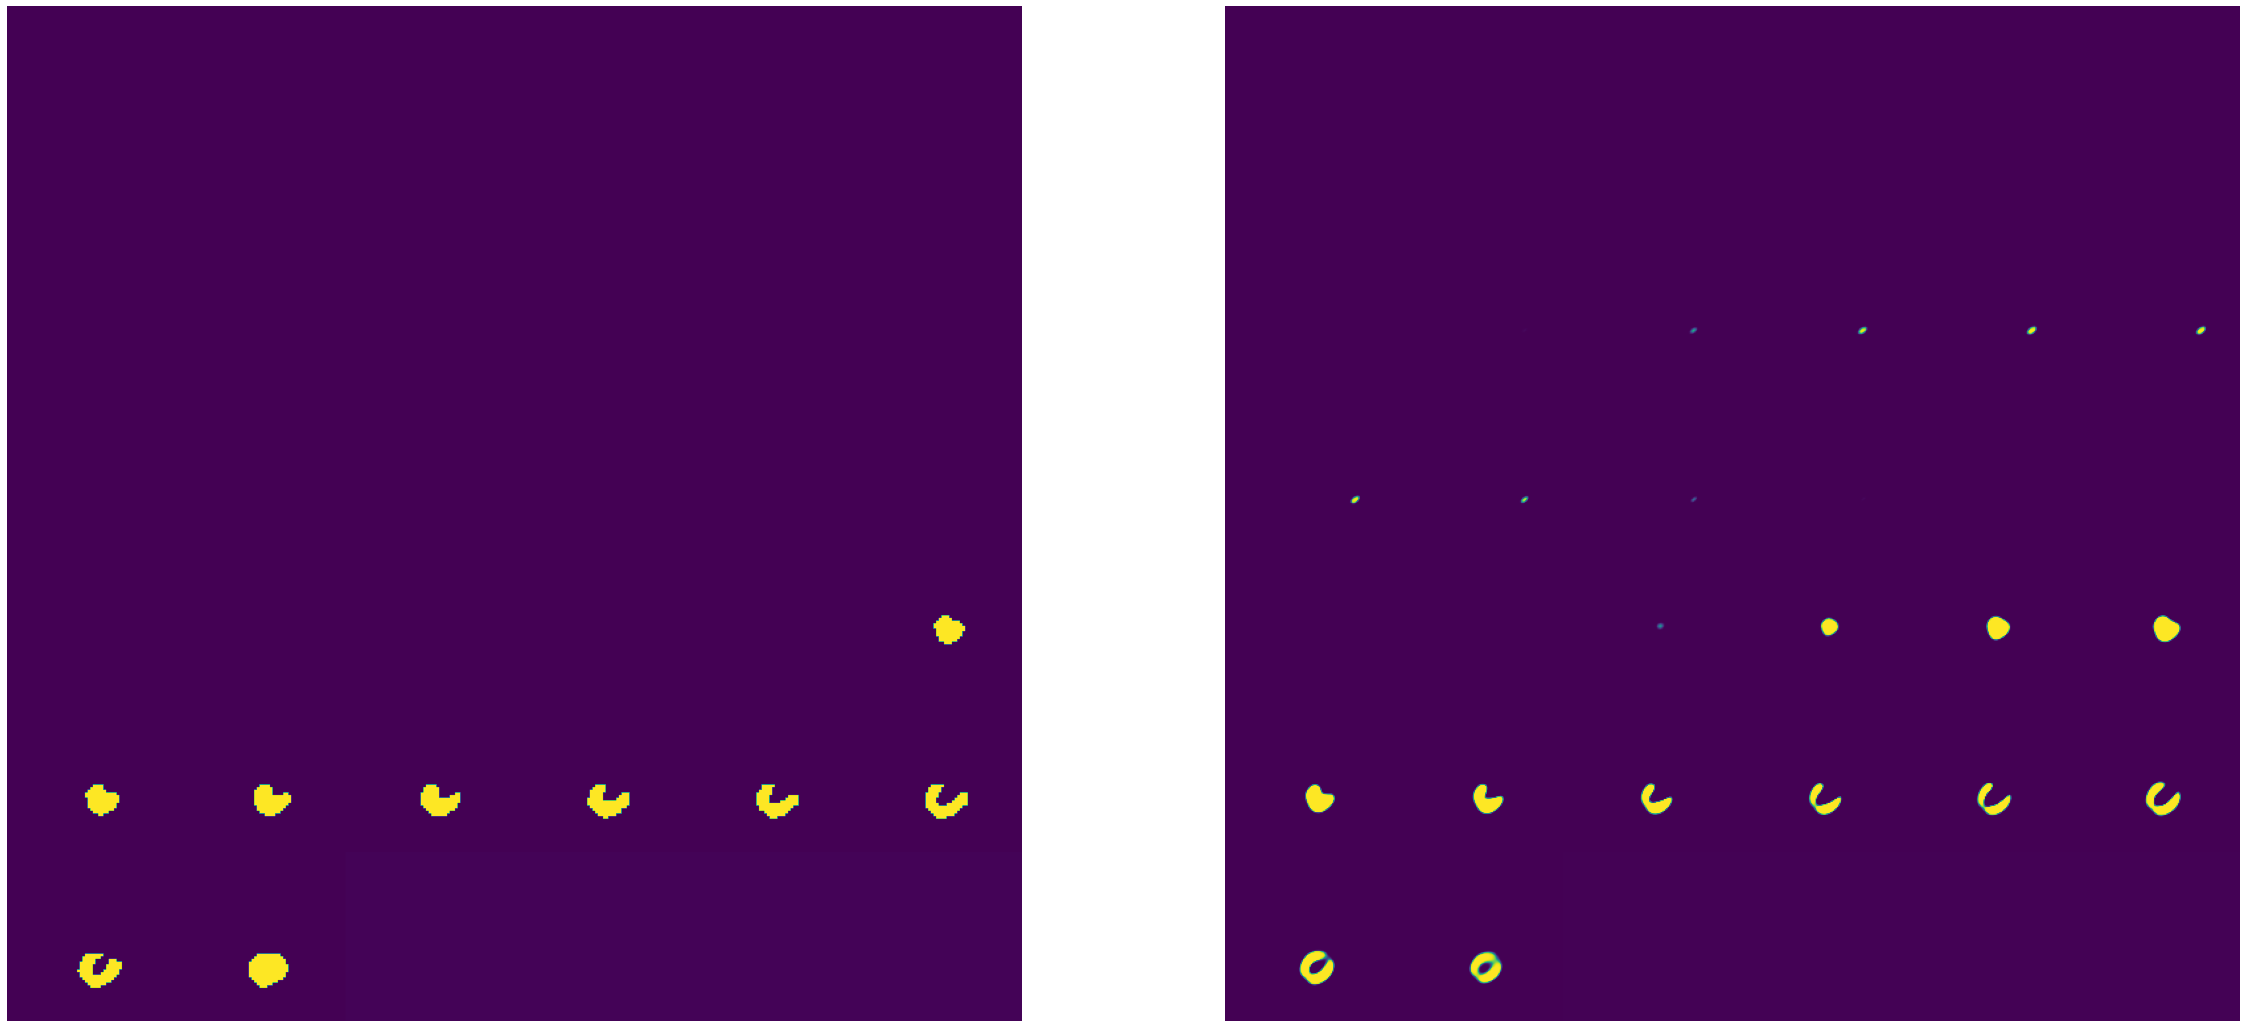

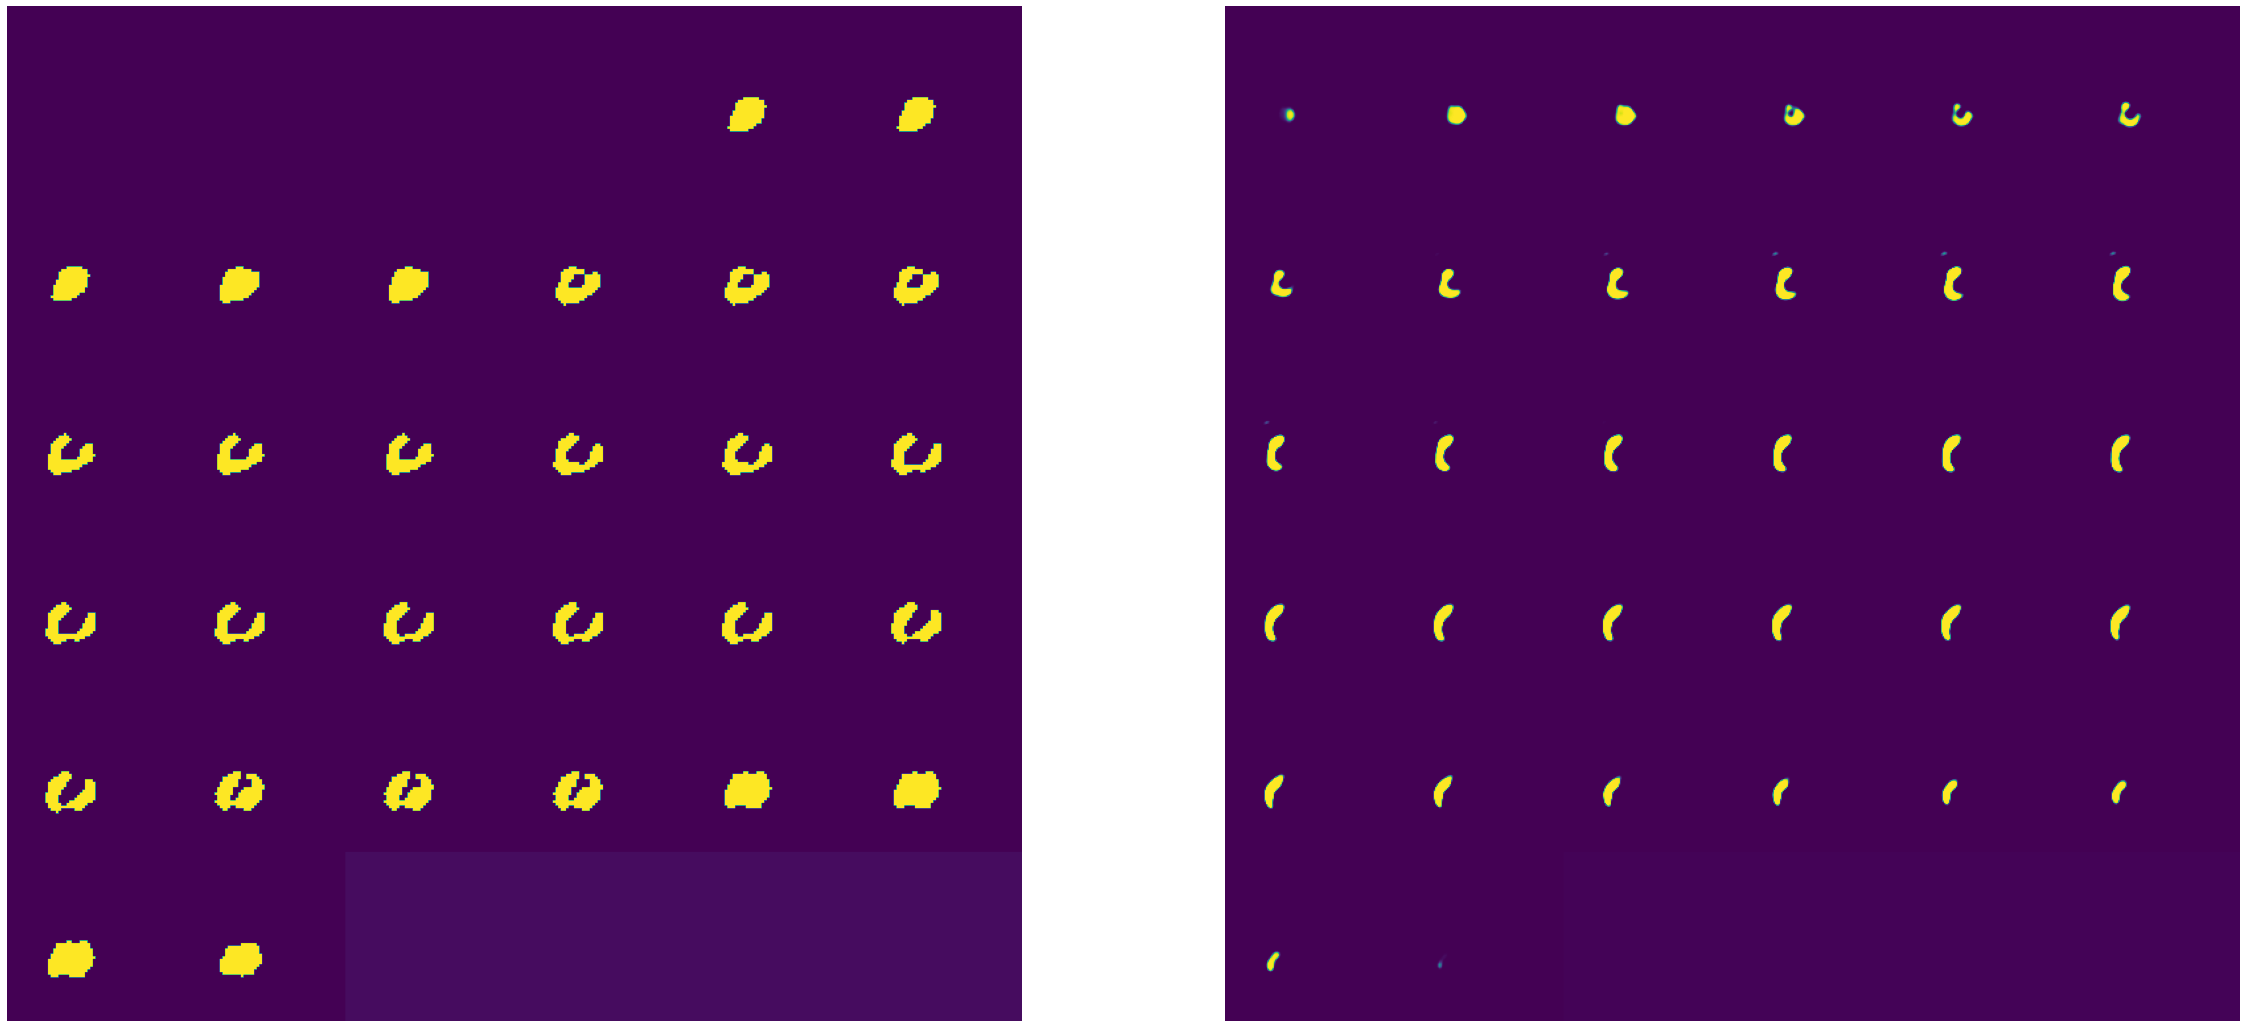

In [38]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

In [39]:
precision, recall, iou = compute_metrics(predictions, targets)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.7222
Recall: 0.4847
IoU: 0.3838


## Add early stop, model saving

## Dropout

In [12]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 200
learning_rate = 1e-3
dropout = 0.0

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=dropout
).to(device)

model.encoder.load_state_dict(encoder_weights)


for name, param in model.named_parameters():
    
    if name.startswith('encoder'):
        param.requires_grad = False
    else:
        param.requires_grad = True
"""
for name, param in model.named_parameters():
    
    if name.startswith('encoder') and 'blocks.1.' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
"""        

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Training mean loss: 0.652	Precision: 0.01	Recall: 0.78	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.606	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.622	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.590	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.612	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.584	Precision: 0.21	Recall: 1.00	IoU: 0.21
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.605	Precision: 0.09	Recall: 0.99	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.579	Precision: 0.26	Recall: 0.98	IoU: 0.26
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.600	Precision: 0.11	Recall: 0.94	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.575	Precision: 0.27	Recall: 0.97	IoU: 0.26
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.596	Precision: 0.12	Recall: 0.97	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.572	Precision: 0.29	Recall: 0.96	IoU: 0.27
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.596	Precision: 0.09	Recall: 0.96	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.568	Precision: 0.24	Recall: 0.99	IoU: 0.24
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.591	Precision: 0.11	Recall: 0.99	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.565	Precision: 0.27	Recall: 0.98	IoU: 0.26
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.587	Precision: 0.12	Recall: 0.96	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.563	Precision: 0.29	Recall: 0.97	IoU: 0.28
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.584	Precision: 0.13	Recall: 0.94	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.559	Precision: 0.30	Recall: 0.96	IoU: 0.28
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.582	Precision: 0.13	Recall: 0.91	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.556	Precision: 0.31	Recall: 0.95	IoU: 0.29
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.578	Precision: 0.15	Recall: 0.96	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.554	Precision: 0.33	Recall: 0.93	IoU: 0.30
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.574	Precision: 0.15	Recall: 0.97	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.551	Precision: 0.33	Recall: 0.93	IoU: 0.30
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.573	Precision: 0.15	Recall: 0.94	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.548	Precision: 0.34	Recall: 0.92	IoU: 0.31
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.569	Precision: 0.18	Recall: 0.96	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.545	Precision: 0.33	Recall: 0.93	IoU: 0.30
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.568	Precision: 0.15	Recall: 0.96	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.542	Precision: 0.34	Recall: 0.93	IoU: 0.30
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.564	Precision: 0.17	Recall: 0.97	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.540	Precision: 0.35	Recall: 0.92	IoU: 0.31
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.561	Precision: 0.18	Recall: 0.98	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.538	Precision: 0.37	Recall: 0.90	IoU: 0.32
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.559	Precision: 0.21	Recall: 0.96	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.535	Precision: 0.39	Recall: 0.91	IoU: 0.34
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.558	Precision: 0.19	Recall: 0.97	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.531	Precision: 0.40	Recall: 0.91	IoU: 0.35
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.554	Precision: 0.21	Recall: 0.94	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.530	Precision: 0.42	Recall: 0.90	IoU: 0.36
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.554	Precision: 0.18	Recall: 0.96	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.526	Precision: 0.33	Recall: 0.93	IoU: 0.30
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.549	Precision: 0.17	Recall: 0.98	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.527	Precision: 0.37	Recall: 0.88	IoU: 0.31
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.549	Precision: 0.21	Recall: 0.93	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.523	Precision: 0.39	Recall: 0.90	IoU: 0.34
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.547	Precision: 0.19	Recall: 0.96	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.518	Precision: 0.37	Recall: 0.93	IoU: 0.33
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.18	Recall: 0.96	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516	Precision: 0.38	Recall: 0.92	IoU: 0.33
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.19	Recall: 0.91	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.514	Precision: 0.39	Recall: 0.90	IoU: 0.34
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.539	Precision: 0.20	Recall: 0.96	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.514	Precision: 0.38	Recall: 0.88	IoU: 0.32
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.537	Precision: 0.21	Recall: 0.95	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512	Precision: 0.40	Recall: 0.87	IoU: 0.33
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.535	Precision: 0.22	Recall: 0.94	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.509	Precision: 0.42	Recall: 0.87	IoU: 0.35
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.23	Recall: 0.96	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.507	Precision: 0.44	Recall: 0.86	IoU: 0.36
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.23	Recall: 0.85	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504	Precision: 0.43	Recall: 0.87	IoU: 0.36
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.528	Precision: 0.24	Recall: 0.95	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.500	Precision: 0.41	Recall: 0.89	IoU: 0.35
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.24	Recall: 0.97	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.499	Precision: 0.44	Recall: 0.87	IoU: 0.36
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.25	Recall: 0.96	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.496	Precision: 0.41	Recall: 0.89	IoU: 0.35
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.523	Precision: 0.23	Recall: 0.98	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.495	Precision: 0.47	Recall: 0.86	IoU: 0.39
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.520	Precision: 0.26	Recall: 0.95	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.493	Precision: 0.49	Recall: 0.85	IoU: 0.40
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.516	Precision: 0.29	Recall: 0.97	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.491	Precision: 0.49	Recall: 0.83	IoU: 0.39
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.516	Precision: 0.26	Recall: 0.96	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.486	Precision: 0.39	Recall: 0.90	IoU: 0.33
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.517	Precision: 0.20	Recall: 0.99	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.44	Recall: 0.88	IoU: 0.37
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.516	Precision: 0.23	Recall: 0.94	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.42	Recall: 0.86	IoU: 0.35
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.519	Precision: 0.16	Recall: 0.98	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.482	Precision: 0.42	Recall: 0.87	IoU: 0.35
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.510	Precision: 0.27	Recall: 0.97	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.477	Precision: 0.50	Recall: 0.87	IoU: 0.41
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.509	Precision: 0.23	Recall: 0.95	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.473	Precision: 0.45	Recall: 0.90	IoU: 0.38
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.506	Precision: 0.24	Recall: 0.93	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Precision: 0.50	Recall: 0.84	IoU: 0.40
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.28	Recall: 0.97	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.476	Precision: 0.44	Recall: 0.81	IoU: 0.35
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.500	Precision: 0.27	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.474	Precision: 0.50	Recall: 0.82	IoU: 0.39
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.496	Precision: 0.32	Recall: 0.96	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.467	Precision: 0.50	Recall: 0.84	IoU: 0.40
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.27	Recall: 0.96	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Precision: 0.50	Recall: 0.83	IoU: 0.40
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.29	Recall: 0.94	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Precision: 0.54	Recall: 0.80	IoU: 0.41
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.496	Precision: 0.24	Recall: 0.97	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.457	Precision: 0.44	Recall: 0.88	IoU: 0.37
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.491	Precision: 0.25	Recall: 0.95	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.459	Precision: 0.52	Recall: 0.83	IoU: 0.42
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.489	Precision: 0.31	Recall: 0.92	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.51	Recall: 0.85	IoU: 0.42
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.486	Precision: 0.26	Recall: 0.98	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.50	Recall: 0.82	IoU: 0.39
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: 0.30	Recall: 0.97	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.449	Precision: 0.48	Recall: 0.86	IoU: 0.40
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.24	Recall: 0.98	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.444	Precision: 0.43	Recall: 0.89	IoU: 0.36
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: 0.22	Recall: 0.90	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.48	Recall: 0.85	IoU: 0.39
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.479	Precision: 0.27	Recall: 0.96	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.448	Precision: 0.47	Recall: 0.81	IoU: 0.37
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.479	Precision: 0.28	Recall: 0.90	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.445	Precision: 0.49	Recall: 0.81	IoU: 0.38
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.475	Precision: 0.29	Recall: 0.96	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.443	Precision: 0.50	Recall: 0.80	IoU: 0.39
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.477	Precision: 0.28	Recall: 0.90	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.431	Precision: 0.47	Recall: 0.89	IoU: 0.40
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.475	Precision: 0.21	Recall: 0.93	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.427	Precision: 0.47	Recall: 0.90	IoU: 0.40
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.25	Recall: 0.89	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.428	Precision: 0.50	Recall: 0.86	IoU: 0.41
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.469	Precision: 0.27	Recall: 0.97	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.436	Precision: 0.52	Recall: 0.78	IoU: 0.40
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.462	Precision: 0.36	Recall: 0.95	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.427	Precision: 0.53	Recall: 0.82	IoU: 0.42
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.28	Recall: 0.98	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.49	Recall: 0.88	IoU: 0.41
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.462	Precision: 0.28	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.51	Recall: 0.86	IoU: 0.42
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.462	Precision: 0.28	Recall: 0.96	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.424	Precision: 0.56	Recall: 0.78	IoU: 0.43
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.457	Precision: 0.34	Recall: 0.88	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.413	Precision: 0.54	Recall: 0.84	IoU: 0.43
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.31	Recall: 0.94	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Precision: 0.59	Recall: 0.82	IoU: 0.46
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.454	Precision: 0.32	Recall: 0.92	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.49	Recall: 0.86	IoU: 0.40
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.451	Precision: 0.27	Recall: 0.97	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.49	Recall: 0.83	IoU: 0.39
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.32	Recall: 0.96	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.59	Recall: 0.79	IoU: 0.45
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.448	Precision: 0.30	Recall: 0.86	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.397	Precision: 0.58	Recall: 0.82	IoU: 0.45
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.439	Precision: 0.33	Recall: 0.96	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.404	Precision: 0.54	Recall: 0.78	IoU: 0.41
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.440	Precision: 0.34	Recall: 0.93	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.389	Precision: 0.50	Recall: 0.85	IoU: 0.41
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.24	Recall: 0.91	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.380	Precision: 0.48	Recall: 0.89	IoU: 0.41
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.443	Precision: 0.23	Recall: 0.88	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.386	Precision: 0.56	Recall: 0.83	IoU: 0.44
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.439	Precision: 0.26	Recall: 0.92	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Precision: 0.50	Recall: 0.87	IoU: 0.42
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: 0.30	Recall: 0.80	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.388	Precision: 0.56	Recall: 0.78	IoU: 0.43
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.30	Recall: 0.87	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.377	Precision: 0.51	Recall: 0.83	IoU: 0.41
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.426	Precision: 0.30	Recall: 0.89	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.378	Precision: 0.52	Recall: 0.80	IoU: 0.40
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.422	Precision: 0.31	Recall: 0.96	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.368	Precision: 0.59	Recall: 0.80	IoU: 0.45
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.412	Precision: 0.39	Recall: 0.94	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.367	Precision: 0.57	Recall: 0.80	IoU: 0.44
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.423	Precision: 0.28	Recall: 0.89	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Precision: 0.55	Recall: 0.81	IoU: 0.43
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.417	Precision: 0.31	Recall: 0.86	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.354	Precision: 0.62	Recall: 0.80	IoU: 0.48
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.403	Precision: 0.39	Recall: 0.90	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.57	Recall: 0.84	IoU: 0.46
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.405	Precision: 0.30	Recall: 0.92	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.364	Precision: 0.49	Recall: 0.77	IoU: 0.37
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.402	Precision: 0.32	Recall: 0.88	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Precision: 0.58	Recall: 0.76	IoU: 0.42
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.407	Precision: 0.30	Recall: 0.95	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.342	Precision: 0.51	Recall: 0.87	IoU: 0.42
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.406	Precision: 0.31	Recall: 0.92	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.64	Recall: 0.80	IoU: 0.50
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.39	Recall: 0.89	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.56	Recall: 0.84	IoU: 0.45
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.32	Recall: 0.89	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Precision: 0.57	Recall: 0.81	IoU: 0.45
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.387	Precision: 0.34	Recall: 0.93	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.69	Recall: 0.72	IoU: 0.49
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: 0.45	Recall: 0.85	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.44	Recall: 0.90	IoU: 0.37
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.407	Precision: 0.20	Recall: 0.97	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.46	Recall: 0.85	IoU: 0.38
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.401	Precision: 0.27	Recall: 0.76	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.351	Precision: 0.63	Recall: 0.65	IoU: 0.42
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.391	Precision: 0.36	Recall: 0.83	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316	Precision: 0.50	Recall: 0.85	IoU: 0.41
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: 0.30	Recall: 0.93	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Precision: 0.67	Recall: 0.68	IoU: 0.47
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: 0.37	Recall: 0.91	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.45	Recall: 0.90	IoU: 0.38
Starting epoch 101


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.25	Recall: 0.94	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.59	Recall: 0.86	IoU: 0.48
Starting epoch 102


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.373	Precision: 0.37	Recall: 0.81	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.69	Recall: 0.77	IoU: 0.51
Starting epoch 103


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.42	Recall: 0.93	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.69	Recall: 0.71	IoU: 0.48
Starting epoch 104


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.353	Precision: 0.44	Recall: 0.89	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.64	Recall: 0.69	IoU: 0.44
Starting epoch 105


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.341	Precision: 0.44	Recall: 0.88	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.62	Recall: 0.75	IoU: 0.46
Starting epoch 106


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.37	Recall: 0.84	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.285	Precision: 0.66	Recall: 0.75	IoU: 0.48
Starting epoch 107


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.331	Precision: 0.49	Recall: 0.88	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Precision: 0.80	Recall: 0.58	IoU: 0.46
Starting epoch 108


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.330	Precision: 0.54	Recall: 0.83	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.277	Precision: 0.63	Recall: 0.78	IoU: 0.47
Starting epoch 109


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.34	Recall: 0.93	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.273	Precision: 0.66	Recall: 0.76	IoU: 0.48
Starting epoch 110


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.47	Recall: 0.87	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.74	Recall: 0.63	IoU: 0.46
Starting epoch 111


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.52	Recall: 0.77	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.283	Precision: 0.65	Recall: 0.68	IoU: 0.45
Starting epoch 112


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: 0.39	Recall: 0.89	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.278	Precision: 0.59	Recall: 0.72	IoU: 0.43
Starting epoch 113


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.41	Recall: 0.87	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.265	Precision: 0.70	Recall: 0.70	IoU: 0.48
Starting epoch 114


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.50	Recall: 0.86	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.258	Precision: 0.72	Recall: 0.70	IoU: 0.50
Starting epoch 115


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: 0.47	Recall: 0.77	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.253	Precision: 0.68	Recall: 0.74	IoU: 0.49
Starting epoch 116


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.50	Recall: 0.89	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.265	Precision: 0.72	Recall: 0.66	IoU: 0.48
Starting epoch 117


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.44	Recall: 0.75	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.261	Precision: 0.67	Recall: 0.69	IoU: 0.46
Starting epoch 118


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: 0.46	Recall: 0.87	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.244	Precision: 0.71	Recall: 0.71	IoU: 0.50
Starting epoch 119


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: 0.40	Recall: 0.68	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.245	Precision: 0.76	Recall: 0.67	IoU: 0.50
Starting epoch 120


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.48	Recall: 0.77	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.70	Recall: 0.75	IoU: 0.51
Starting epoch 121


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.47	Recall: 0.80	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251	Precision: 0.77	Recall: 0.63	IoU: 0.48
Starting epoch 122


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.271	Precision: 0.55	Recall: 0.85	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.244	Precision: 0.64	Recall: 0.74	IoU: 0.46
Starting epoch 123


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.39	Recall: 0.90	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.280	Precision: 0.76	Recall: 0.52	IoU: 0.40
Starting epoch 124


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.56	Recall: 0.81	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.249	Precision: 0.77	Recall: 0.62	IoU: 0.46
Starting epoch 125


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.269	Precision: 0.54	Recall: 0.80	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.243	Precision: 0.74	Recall: 0.64	IoU: 0.47
Starting epoch 126


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.60	Recall: 0.77	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.66	Recall: 0.77	IoU: 0.50
Starting epoch 127


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.39	Recall: 0.87	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.67	Recall: 0.75	IoU: 0.50
Starting epoch 128


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.45	Recall: 0.79	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.238	Precision: 0.72	Recall: 0.64	IoU: 0.47
Starting epoch 129


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: 0.49	Recall: 0.66	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.244	Precision: 0.73	Recall: 0.60	IoU: 0.46
Starting epoch 130


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: 0.48	Recall: 0.73	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.64	Recall: 0.71	IoU: 0.46
Starting epoch 131


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.242	Precision: 0.52	Recall: 0.89	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.242	Precision: 0.68	Recall: 0.63	IoU: 0.44
Starting epoch 132


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.237	Precision: 0.55	Recall: 0.83	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.264	Precision: 0.75	Recall: 0.54	IoU: 0.39
Starting epoch 133


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.299	Precision: 0.61	Recall: 0.61	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.68	Recall: 0.70	IoU: 0.47
Starting epoch 134


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.47	Recall: 0.87	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.219	Precision: 0.73	Recall: 0.68	IoU: 0.49
Starting epoch 135


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.261	Precision: 0.52	Recall: 0.76	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.79	Recall: 0.62	IoU: 0.49
Starting epoch 136


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.49	Recall: 0.72	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.81	Recall: 0.61	IoU: 0.49
Starting epoch 137


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.251	Precision: 0.54	Recall: 0.75	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.78	Recall: 0.67	IoU: 0.51
Starting epoch 138


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.235	Precision: 0.54	Recall: 0.82	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.74	Recall: 0.66	IoU: 0.48
Starting epoch 139


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.224	Precision: 0.58	Recall: 0.79	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.78	Recall: 0.55	IoU: 0.44
Starting epoch 140


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.271	Precision: 0.53	Recall: 0.56	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.70	Recall: 0.68	IoU: 0.47
Starting epoch 141


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.239	Precision: 0.49	Recall: 0.85	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.218	Precision: 0.66	Recall: 0.70	IoU: 0.46
Starting epoch 142


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.262	Precision: 0.50	Recall: 0.71	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.234	Precision: 0.79	Recall: 0.55	IoU: 0.44
Starting epoch 143


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.53	Recall: 0.65	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.200	Precision: 0.73	Recall: 0.70	IoU: 0.51
Starting epoch 144


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.230	Precision: 0.52	Recall: 0.84	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.75	Recall: 0.66	IoU: 0.50
Starting epoch 145


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.215	Precision: 0.61	Recall: 0.81	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.232	Precision: 0.76	Recall: 0.57	IoU: 0.44
Starting epoch 146


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.245	Precision: 0.51	Recall: 0.72	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.69	Recall: 0.66	IoU: 0.46
Starting epoch 147


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.206	Precision: 0.61	Recall: 0.85	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.251	Precision: 0.76	Recall: 0.49	IoU: 0.39
Starting epoch 148


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: 0.55	Recall: 0.48	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.75	Recall: 0.64	IoU: 0.49
Starting epoch 149


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.280	Precision: 0.50	Recall: 0.68	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.197	Precision: 0.64	Recall: 0.80	IoU: 0.50
Starting epoch 150


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.243	Precision: 0.46	Recall: 0.92	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.215	Precision: 0.80	Recall: 0.60	IoU: 0.48
Starting epoch 151


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.258	Precision: 0.61	Recall: 0.64	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.223	Precision: 0.84	Recall: 0.56	IoU: 0.47
Starting epoch 152


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.237	Precision: 0.56	Recall: 0.75	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.235	Precision: 0.71	Recall: 0.62	IoU: 0.43
Starting epoch 153


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.256	Precision: 0.50	Recall: 0.76	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.231	Precision: 0.76	Recall: 0.57	IoU: 0.44
Starting epoch 154


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.230	Precision: 0.62	Recall: 0.72	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.214	Precision: 0.74	Recall: 0.63	IoU: 0.47
Starting epoch 155


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.199	Precision: 0.60	Recall: 0.87	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.69	Recall: 0.68	IoU: 0.48
Starting epoch 156


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.220	Precision: 0.55	Recall: 0.81	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.222	Precision: 0.76	Recall: 0.58	IoU: 0.45
Starting epoch 157


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.184	Precision: 0.70	Recall: 0.79	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.230	Precision: 0.80	Recall: 0.54	IoU: 0.43
Starting epoch 158


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.53	Recall: 0.65	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.74	Recall: 0.63	IoU: 0.46
Starting epoch 159


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.203	Precision: 0.54	Recall: 0.91	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.201	Precision: 0.71	Recall: 0.69	IoU: 0.49
Starting epoch 160


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.206	Precision: 0.58	Recall: 0.84	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.242	Precision: 0.81	Recall: 0.49	IoU: 0.41
Starting epoch 161


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.225	Precision: 0.64	Recall: 0.64	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.220	Precision: 0.76	Recall: 0.57	IoU: 0.45
Starting epoch 162


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.218	Precision: 0.55	Recall: 0.77	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.202	Precision: 0.71	Recall: 0.67	IoU: 0.48
Starting epoch 163


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.191	Precision: 0.59	Recall: 0.87	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.78	Recall: 0.60	IoU: 0.47
Starting epoch 164


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.193	Precision: 0.64	Recall: 0.79	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.239	Precision: 0.82	Recall: 0.49	IoU: 0.41
Starting epoch 165


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.262	Precision: 0.52	Recall: 0.53	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.205	Precision: 0.75	Recall: 0.64	IoU: 0.48
Starting epoch 166


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.226	Precision: 0.50	Recall: 0.81	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.70	Recall: 0.67	IoU: 0.47
Starting epoch 167


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.187	Precision: 0.60	Recall: 0.86	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.226	Precision: 0.77	Recall: 0.55	IoU: 0.43
Starting epoch 168


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.196	Precision: 0.71	Recall: 0.71	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.243	Precision: 0.82	Recall: 0.48	IoU: 0.40
Starting epoch 169


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.233	Precision: 0.59	Recall: 0.72	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.186	Precision: 0.74	Recall: 0.70	IoU: 0.51
Starting epoch 170


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.232	Precision: 0.49	Recall: 0.79	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.188	Precision: 0.77	Recall: 0.68	IoU: 0.52
Starting epoch 171


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.185	Precision: 0.62	Recall: 0.85	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Precision: 0.82	Recall: 0.59	IoU: 0.48
Starting epoch 172


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.180	Precision: 0.71	Recall: 0.79	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.228	Precision: 0.80	Recall: 0.53	IoU: 0.43
Starting epoch 173


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.174	Precision: 0.70	Recall: 0.81	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.72	Recall: 0.67	IoU: 0.49
Starting epoch 174


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.187	Precision: 0.57	Recall: 0.89	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.78	Recall: 0.57	IoU: 0.45
Starting epoch 175


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.202	Precision: 0.65	Recall: 0.76	IoU: 0.50


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.74	Recall: 0.63	IoU: 0.47
Starting epoch 176


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.255	Precision: 0.48	Recall: 0.67	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.237	Precision: 0.81	Recall: 0.51	IoU: 0.40
Starting epoch 177


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.220	Precision: 0.61	Recall: 0.70	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.194	Precision: 0.76	Recall: 0.65	IoU: 0.49
Starting epoch 178


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.190	Precision: 0.60	Recall: 0.86	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.208	Precision: 0.80	Recall: 0.57	IoU: 0.46
Starting epoch 179


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.181	Precision: 0.67	Recall: 0.77	IoU: 0.54


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.82	Recall: 0.54	IoU: 0.44
Starting epoch 180


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.166	Precision: 0.68	Recall: 0.85	IoU: 0.58


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.224	Precision: 0.82	Recall: 0.52	IoU: 0.43
Starting epoch 181


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.212	Precision: 0.64	Recall: 0.67	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.216	Precision: 0.78	Recall: 0.55	IoU: 0.44
Starting epoch 182


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.218	Precision: 0.54	Recall: 0.79	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.193	Precision: 0.68	Recall: 0.71	IoU: 0.49
Starting epoch 183


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.233	Precision: 0.47	Recall: 0.78	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.191	Precision: 0.73	Recall: 0.67	IoU: 0.49
Starting epoch 184


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.206	Precision: 0.56	Recall: 0.79	IoU: 0.49


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.212	Precision: 0.83	Recall: 0.55	IoU: 0.45
Starting epoch 185


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.244	Precision: 0.54	Recall: 0.61	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.83	Recall: 0.55	IoU: 0.46
Starting epoch 186


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.195	Precision: 0.67	Recall: 0.73	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.82	Recall: 0.53	IoU: 0.44
Starting epoch 187


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.168	Precision: 0.68	Recall: 0.81	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.203	Precision: 0.75	Recall: 0.61	IoU: 0.47
Starting epoch 188


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.148	Precision: 0.69	Recall: 0.85	IoU: 0.61


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.217	Precision: 0.78	Recall: 0.55	IoU: 0.44
Starting epoch 189


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.161	Precision: 0.71	Recall: 0.82	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.204	Precision: 0.79	Recall: 0.58	IoU: 0.47
Starting epoch 190


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.69	Recall: 0.83	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.210	Precision: 0.81	Recall: 0.55	IoU: 0.45
Starting epoch 191


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.189	Precision: 0.64	Recall: 0.72	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.249	Precision: 0.84	Recall: 0.43	IoU: 0.38
Starting epoch 192


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.222	Precision: 0.63	Recall: 0.61	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.80	Recall: 0.56	IoU: 0.46
Starting epoch 193


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.170	Precision: 0.65	Recall: 0.82	IoU: 0.55


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.189	Precision: 0.75	Recall: 0.65	IoU: 0.50
Starting epoch 194


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.178	Precision: 0.61	Recall: 0.83	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.209	Precision: 0.78	Recall: 0.56	IoU: 0.45
Starting epoch 195


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.164	Precision: 0.74	Recall: 0.74	IoU: 0.56


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.196	Precision: 0.76	Recall: 0.61	IoU: 0.48
Starting epoch 196


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.160	Precision: 0.65	Recall: 0.81	IoU: 0.57


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.184	Precision: 0.75	Recall: 0.67	IoU: 0.50
Starting epoch 197


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.190	Precision: 0.57	Recall: 0.81	IoU: 0.52


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.206	Precision: 0.84	Recall: 0.54	IoU: 0.46
Starting epoch 198


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.185	Precision: 0.67	Recall: 0.67	IoU: 0.53


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.213	Precision: 0.82	Recall: 0.53	IoU: 0.45
Starting epoch 199


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.142	Precision: 0.71	Recall: 0.85	IoU: 0.62


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.207	Precision: 0.76	Recall: 0.58	IoU: 0.46
Starting epoch 200


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.157	Precision: 0.67	Recall: 0.80	IoU: 0.59


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.198	Precision: 0.73	Recall: 0.62	IoU: 0.48


No handles with labels found to put in legend.


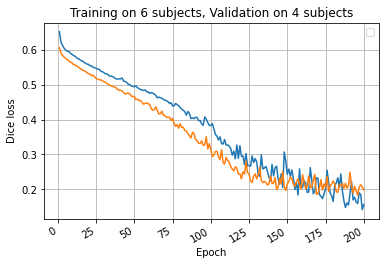

In [13]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

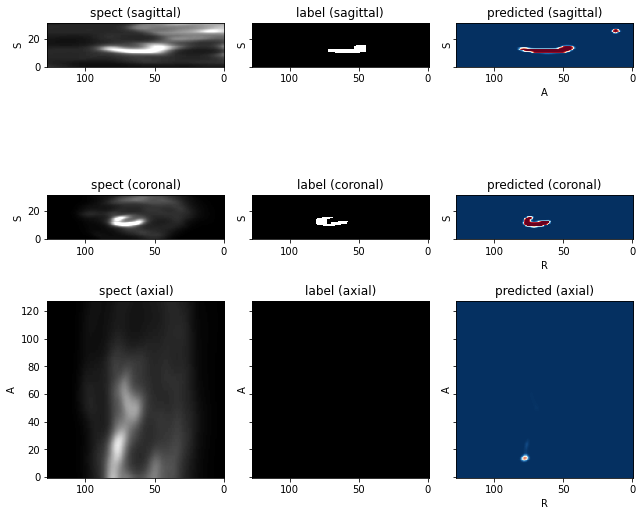

In [15]:
batch = next(iter(validation_loader))

model.eval()

inputs, targets = prepare_batch(batch, device)
FIRST = 1
FOREGROUND = 1

with torch.no_grad():

    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()

affine = batch['spect'][tio.AFFINE][0].numpy()

subject = tio.Subject(
    spect=tio.ScalarImage(tensor=batch['spect'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['left_ventricle'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

  0%|          | 0/1 [00:00<?, ?it/s]

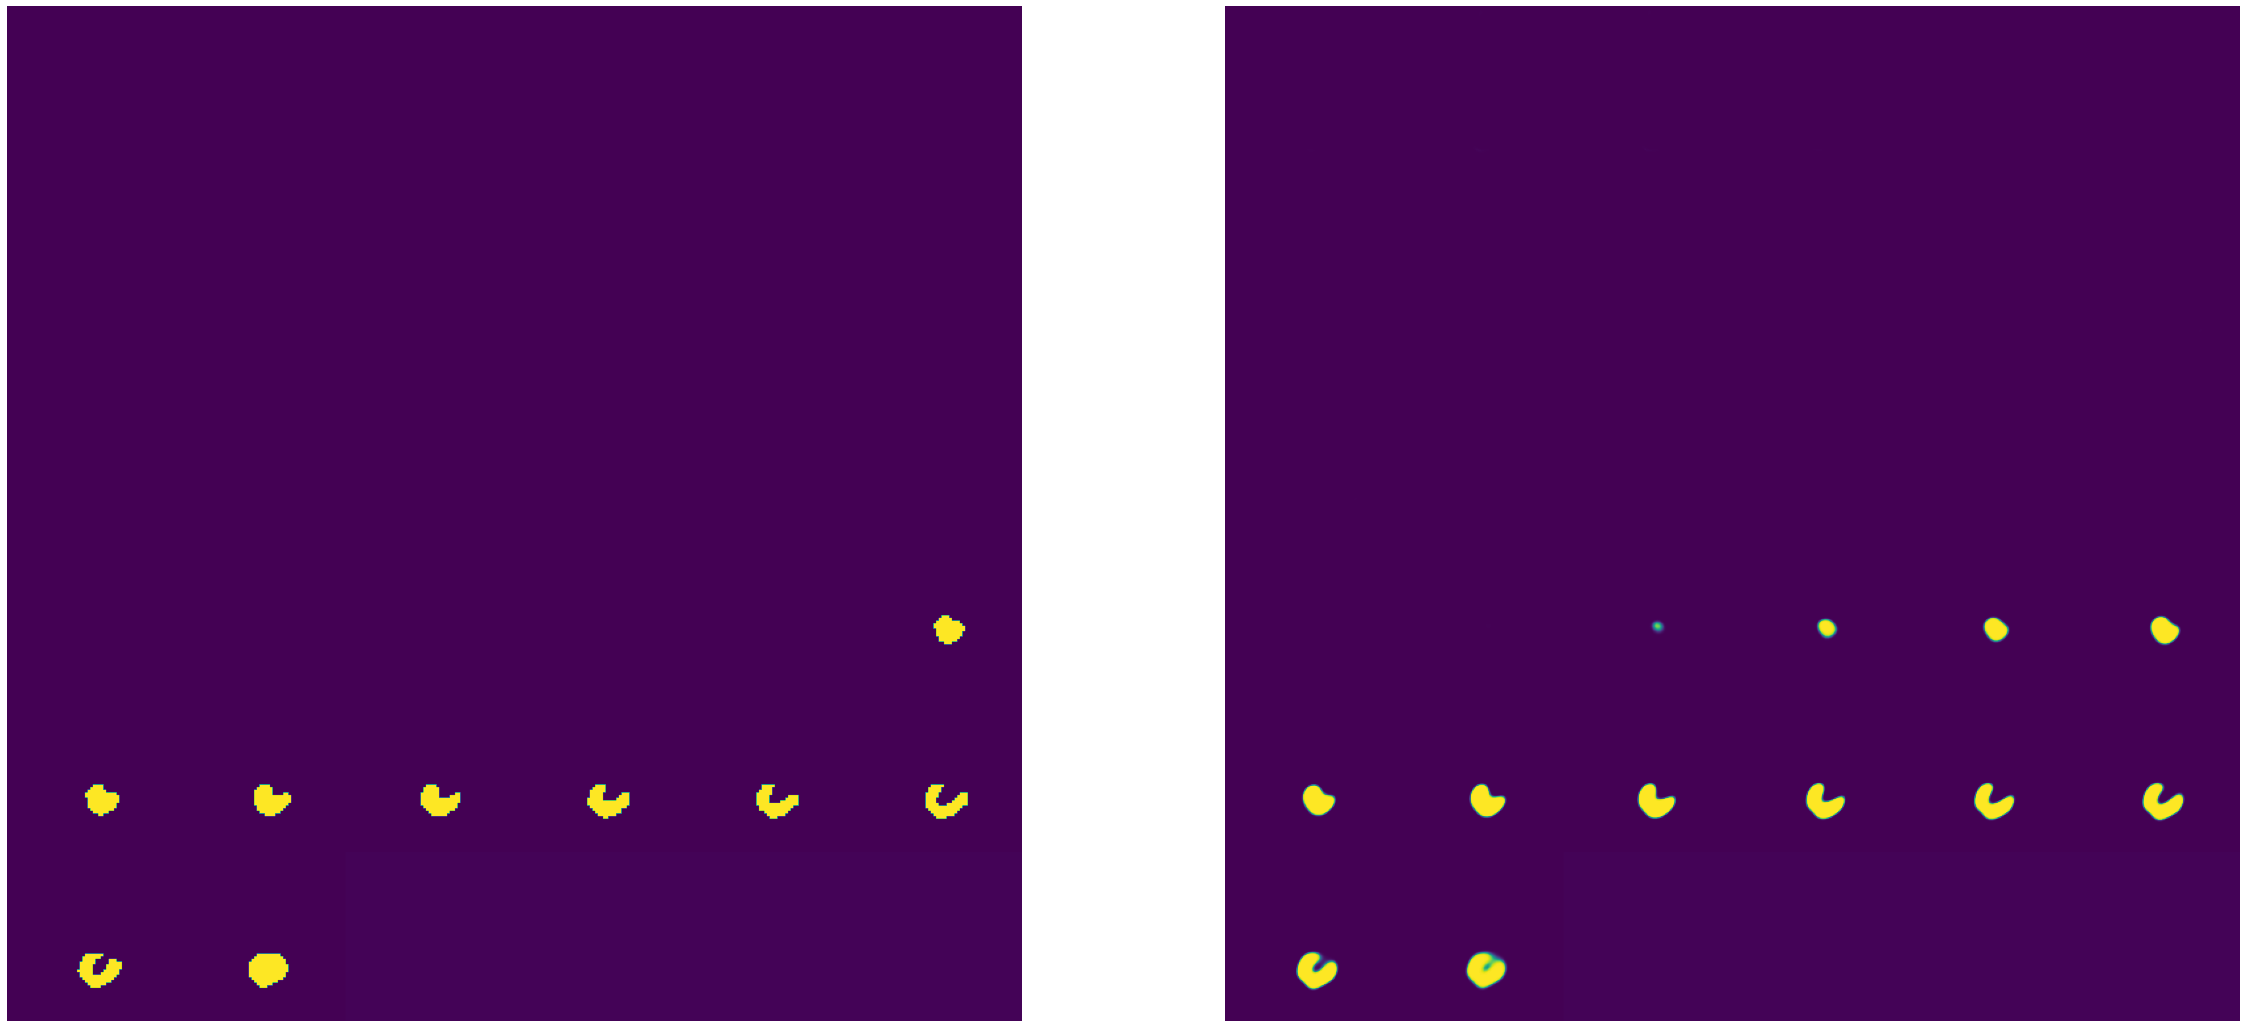

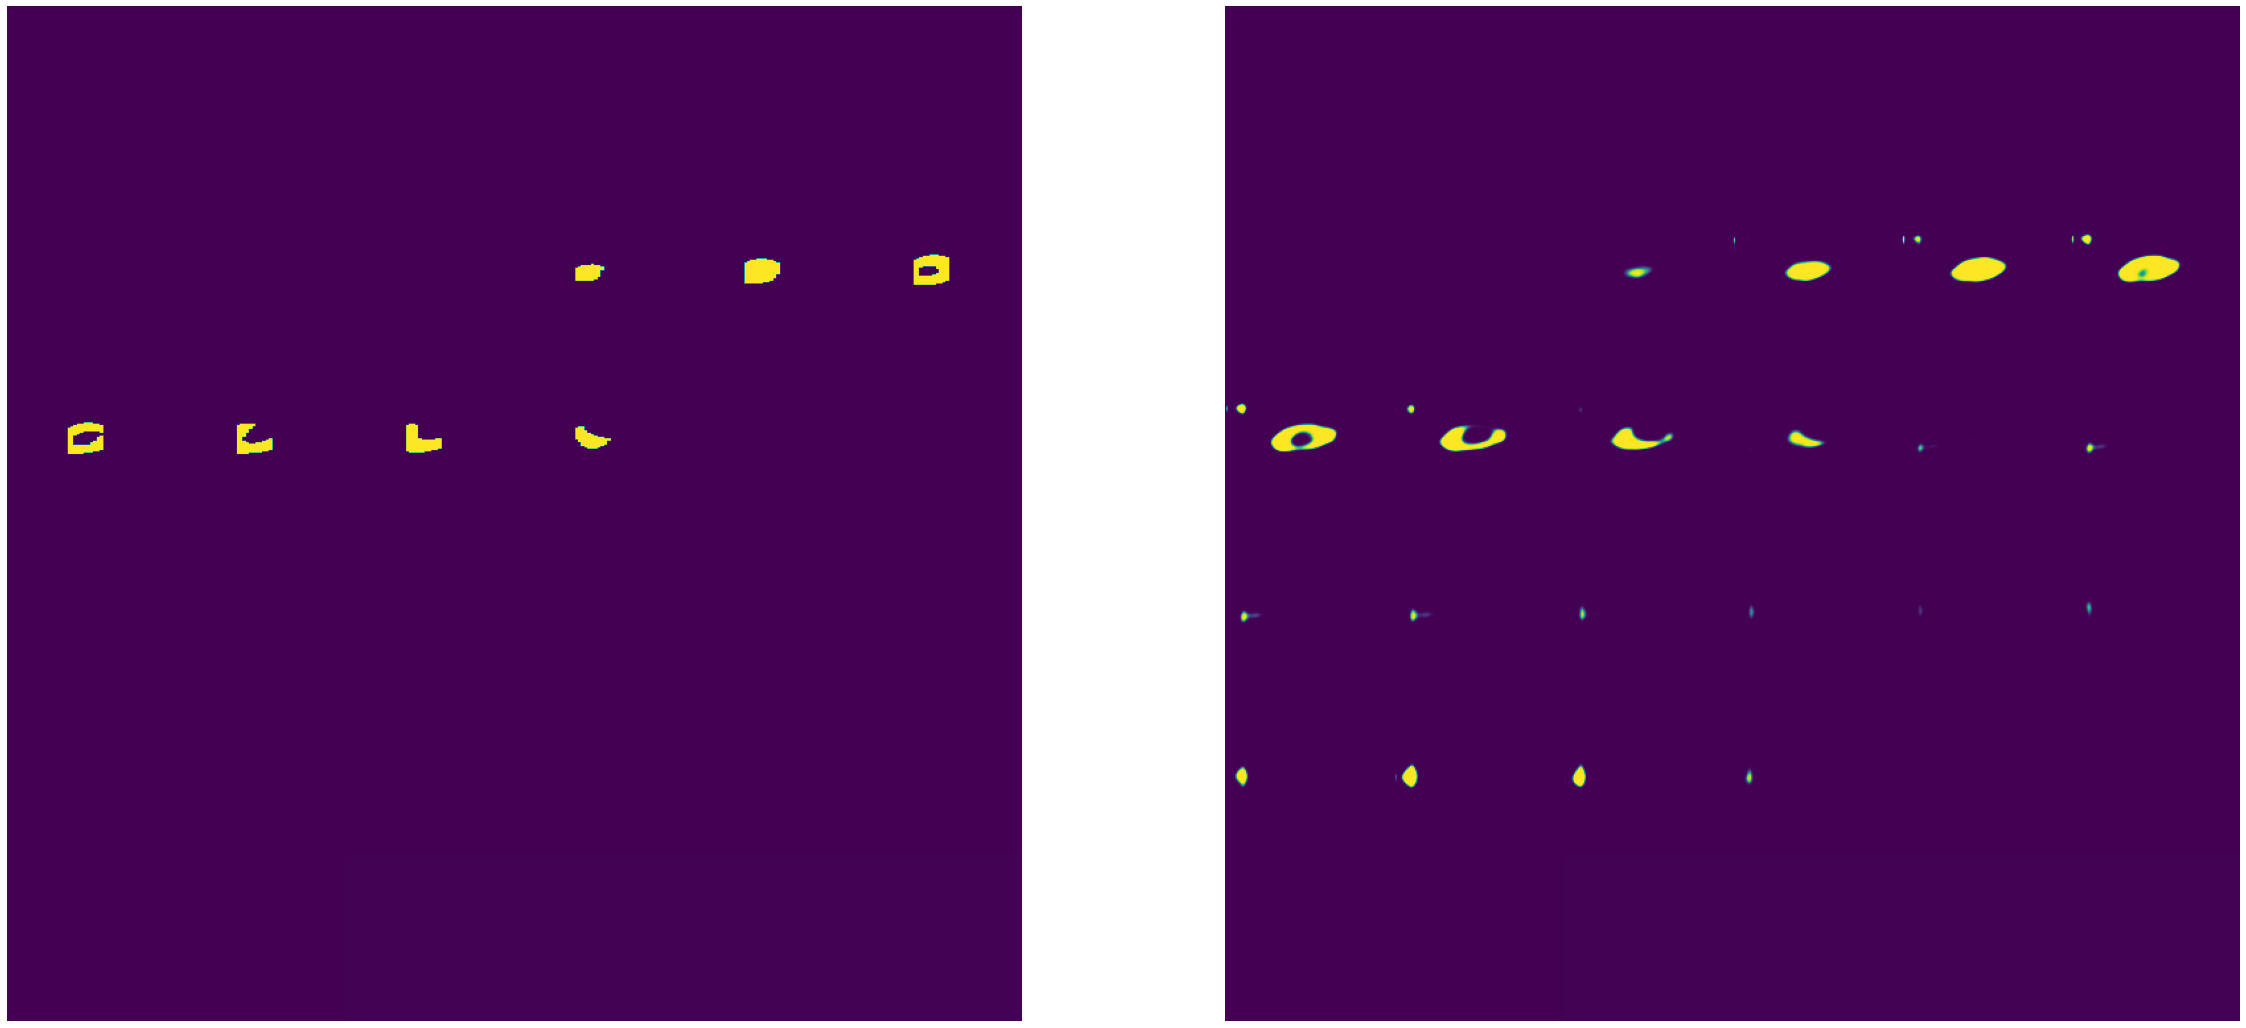

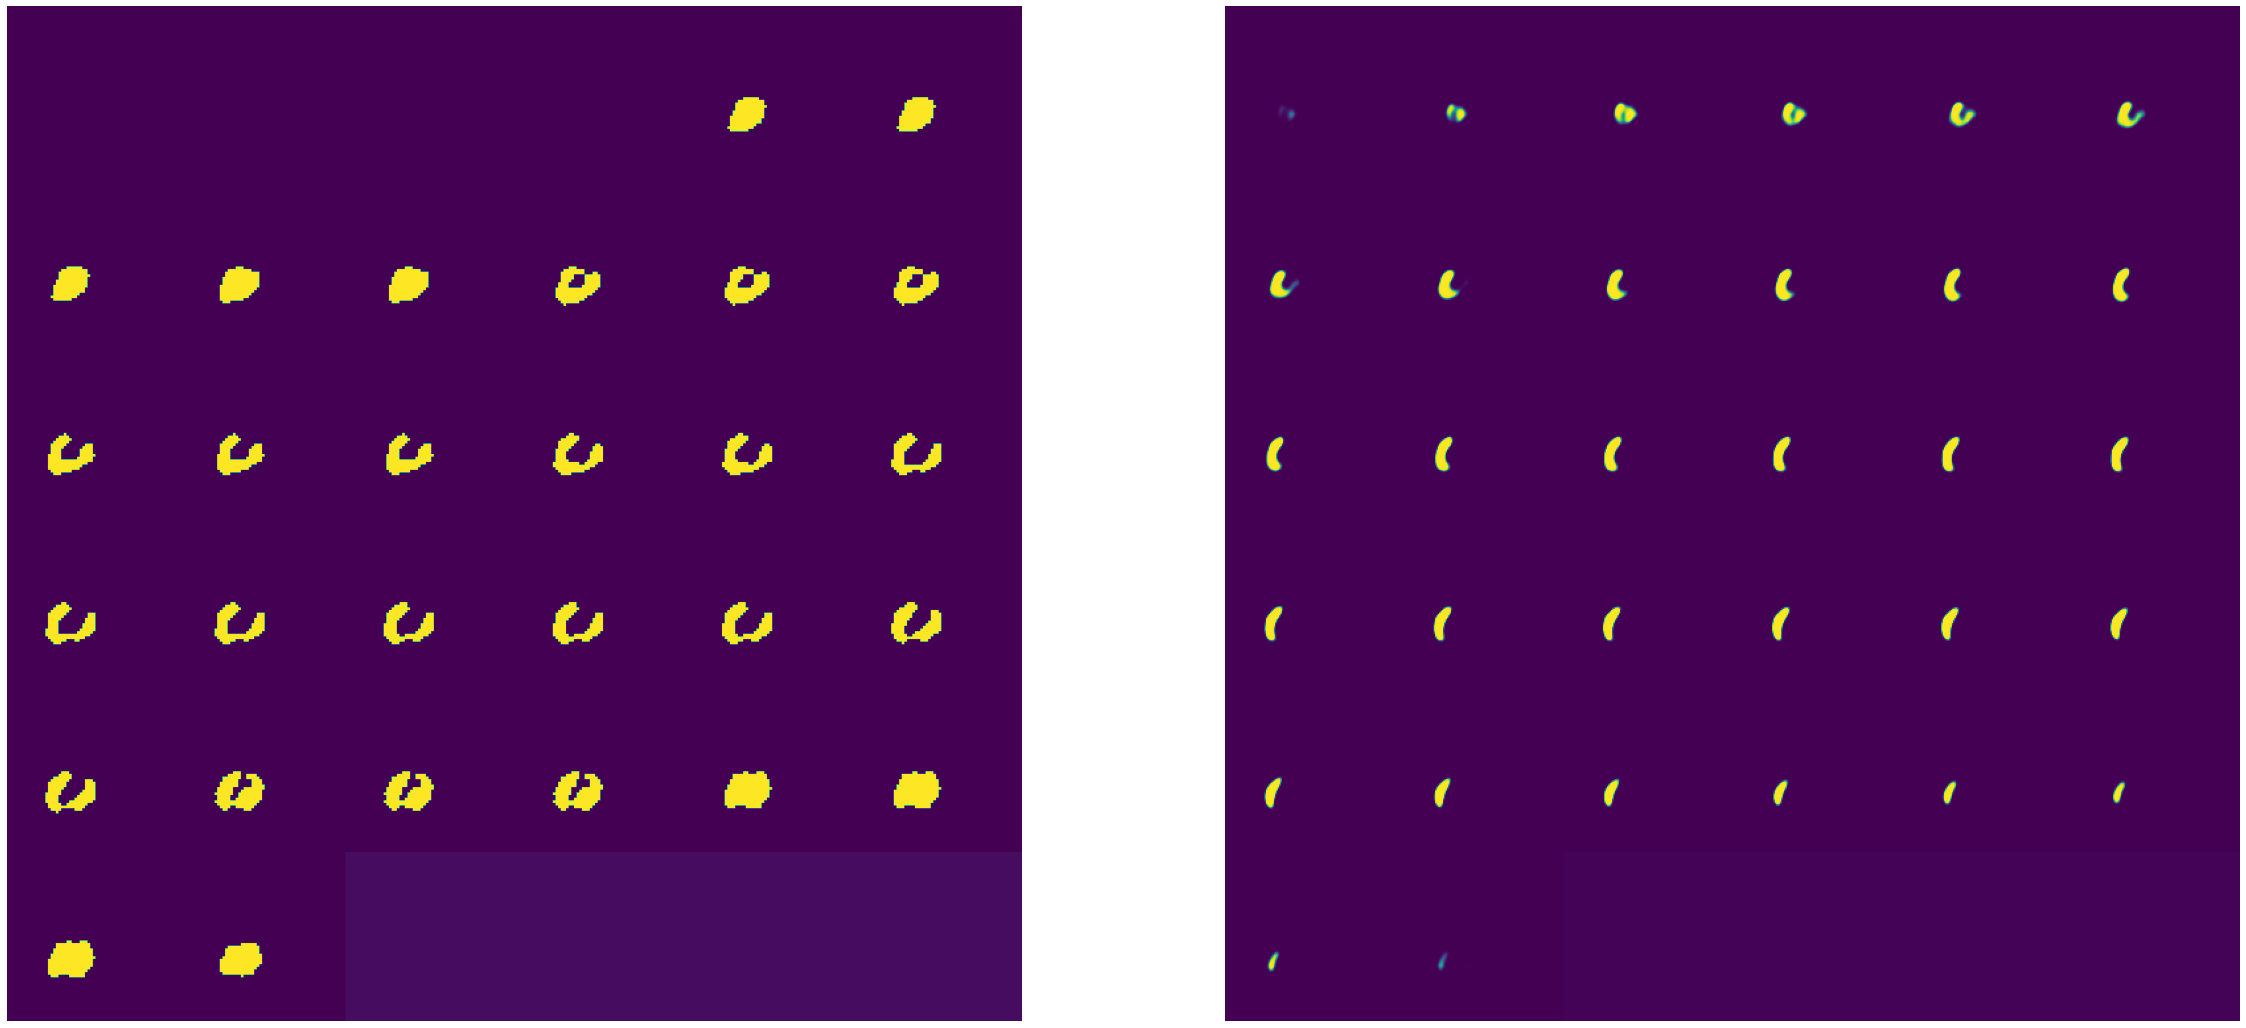

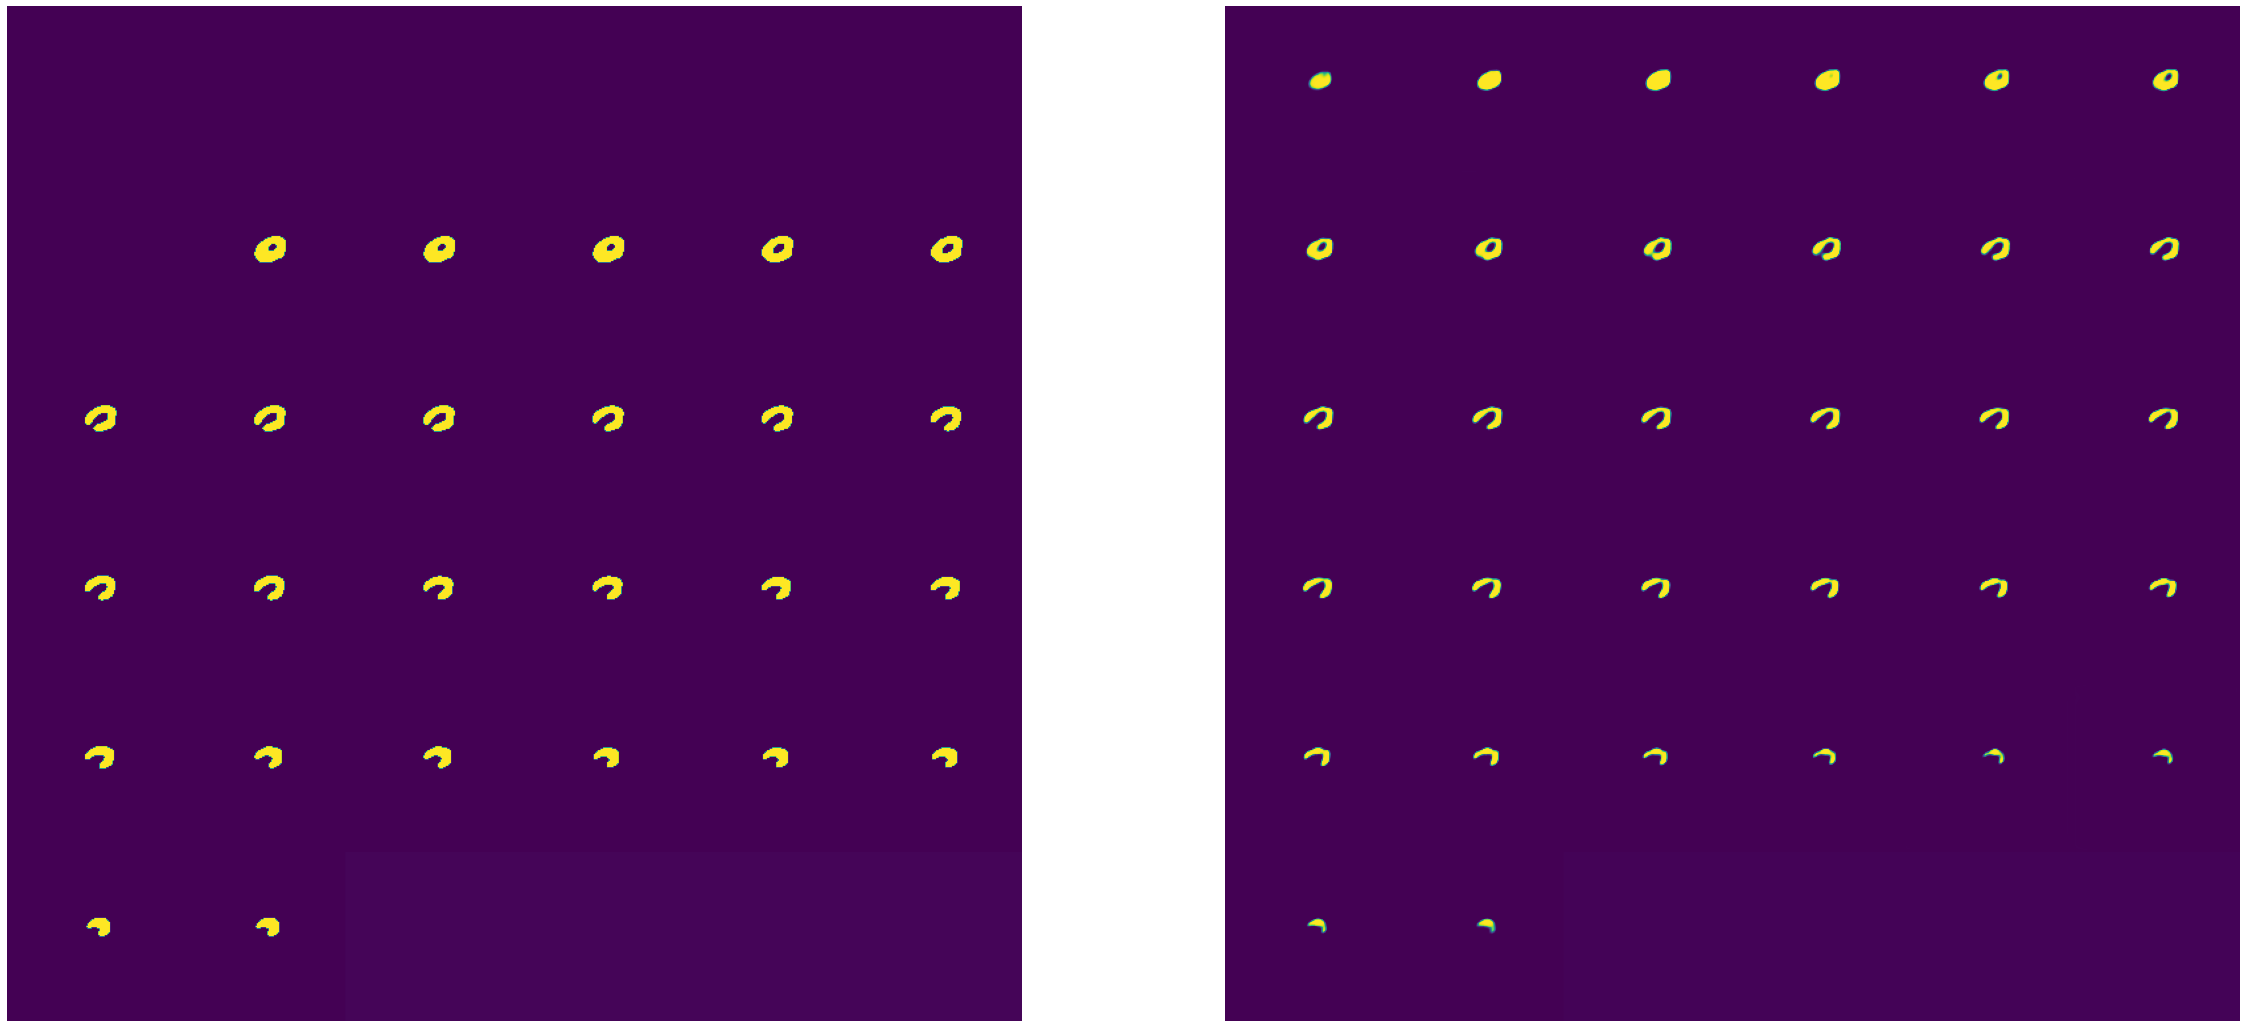

In [16]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

In [17]:
precision, recall, iou = compute_metrics(predictions, targets)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.7314
Recall: 0.6214
IoU: 0.4751


In [39]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 600
learning_rate = 1e-3
dropout = 0.5

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=dropout
).to(device)

model.encoder.load_state_dict(encoder_weights)


for name, param in model.named_parameters():
    
    if name.startswith('encoder'):
        param.requires_grad = False
    else:
        param.requires_grad = True
"""
for name, param in model.named_parameters():
    
    if name.startswith('encoder') and 'blocks.1.' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
"""        

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.673	Precision: 0.01	Recall: 0.43	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.666	Precision: 0.02	Recall: 1.00	IoU: 0.02
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.697	Precision: 0.01	Recall: 0.83	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.657	Precision: 0.03	Recall: 1.00	IoU: 0.03
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.672	Precision: 0.02	Recall: 0.91	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.632	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.659	Precision: 0.02	Recall: 0.97	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.618	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.642	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.637	Precision: 0.02	Recall: 1.00	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.622	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.615	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.631	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.613	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.642	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.610	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.639	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.607	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.615	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.604	Precision: 0.05	Recall: 1.00	IoU: 0.05
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.622	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.601	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.610	Precision: 0.04	Recall: 0.99	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.598	Precision: 0.06	Recall: 1.00	IoU: 0.06
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.629	Precision: 0.03	Recall: 0.87	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.596	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.603	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.594	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.607	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.591	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.617	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.589	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.608	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.587	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.614	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.586	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.610	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.584	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.604	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.582	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.592	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.579	Precision: 0.08	Recall: 1.00	IoU: 0.08
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.599	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.577	Precision: 0.09	Recall: 1.00	IoU: 0.09
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.594	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.574	Precision: 0.09	Recall: 1.00	IoU: 0.09
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.610	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.572	Precision: 0.10	Recall: 1.00	IoU: 0.10
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.592	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.570	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.613	Precision: 0.05	Recall: 0.99	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.568	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.597	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.566	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.582	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.565	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.582	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.563	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.580	Precision: 0.05	Recall: 0.98	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.561	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.590	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.559	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.585	Precision: 0.04	Recall: 1.00	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.557	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.586	Precision: 0.10	Recall: 0.99	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.571	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.553	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.596	Precision: 0.04	Recall: 0.91	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.549	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.574	Precision: 0.06	Recall: 0.98	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.592	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.579	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.546	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.568	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.604	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.542	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.568	Precision: 0.07	Recall: 0.89	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.540	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.590	Precision: 0.05	Recall: 0.99	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.538	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.569	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.537	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.568	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.535	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.561	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.533	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.577	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.532	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.561	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.530	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.554	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.528	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.565	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.526	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.547	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.524	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.563	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.522	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.554	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.556	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.519	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.546	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.517	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.559	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.515	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.532	Precision: 0.13	Recall: 0.96	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.546	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.510	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.536	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.508	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.562	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.506	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.537	Precision: 0.14	Recall: 0.96	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.550	Precision: 0.13	Recall: 0.99	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.556	Precision: 0.06	Recall: 0.94	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.15	Recall: 0.99	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.546	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.498	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.553	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.495	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.503	Precision: 0.16	Recall: 0.95	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.492	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.562	Precision: 0.09	Recall: 0.94	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.490	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.555	Precision: 0.09	Recall: 0.98	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.507	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.488	Precision: 0.21	Recall: 1.00	IoU: 0.20
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.535	Precision: nan	Recall: 0.80	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.486	Precision: 0.21	Recall: 1.00	IoU: 0.21
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.542	Precision: nan	Recall: 0.83	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.505	Precision: 0.11	Recall: 0.82	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.21	Recall: 1.00	IoU: 0.20
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.507	Precision: 0.15	Recall: 0.97	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.497	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.481	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.13	Recall: 0.83	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.478	Precision: 0.22	Recall: 0.99	IoU: 0.21
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.477	Precision: 0.22	Recall: 0.99	IoU: 0.22
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.520	Precision: 0.12	Recall: 0.99	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.477	Precision: 0.24	Recall: 0.98	IoU: 0.23
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.15	Recall: 0.81	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.476	Precision: 0.24	Recall: 0.98	IoU: 0.24
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.523	Precision: 0.16	Recall: 0.97	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.474	Precision: 0.24	Recall: 0.98	IoU: 0.24
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.19	Recall: 0.97	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471	Precision: 0.24	Recall: 0.98	IoU: 0.24
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.467	Precision: 0.22	Recall: 0.90	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.26	Recall: 0.96	IoU: 0.25
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.518	Precision: 0.22	Recall: 0.98	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Precision: 0.27	Recall: 0.95	IoU: 0.25
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.545	Precision: 0.14	Recall: 0.96	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.465	Precision: 0.27	Recall: 0.95	IoU: 0.25
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.17	Recall: 0.94	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.463	Precision: 0.27	Recall: 0.95	IoU: 0.25
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.543	Precision: 0.08	Recall: 0.97	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.462	Precision: 0.25	Recall: 0.97	IoU: 0.24
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.526	Precision: 0.16	Recall: 0.82	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.460	Precision: 0.25	Recall: 0.97	IoU: 0.24
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.526	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.458	Precision: 0.24	Recall: 0.97	IoU: 0.24
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.515	Precision: 0.13	Recall: 0.99	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.456	Precision: 0.25	Recall: 0.97	IoU: 0.24
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: 0.26	Recall: 0.99	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.453	Precision: 0.26	Recall: 0.96	IoU: 0.25
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.503	Precision: 0.22	Recall: 0.87	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.451	Precision: 0.26	Recall: 0.96	IoU: 0.25
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.507	Precision: 0.20	Recall: 0.99	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.449	Precision: 0.27	Recall: 0.95	IoU: 0.25
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.513	Precision: nan	Recall: 0.56	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.28	Recall: 0.94	IoU: 0.26
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: 0.22	Recall: 0.97	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.444	Precision: 0.28	Recall: 0.94	IoU: 0.26
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442	Precision: 0.29	Recall: 0.93	IoU: 0.26
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.468	Precision: 0.26	Recall: 0.95	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.441	Precision: 0.30	Recall: 0.91	IoU: 0.27
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.26	Recall: 0.84	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.440	Precision: 0.30	Recall: 0.91	IoU: 0.27
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.506	Precision: nan	Recall: 0.75	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.30	Recall: 0.91	IoU: 0.27
Starting epoch 101


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: nan	Recall: 0.75	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.30	Recall: 0.91	IoU: 0.27
Starting epoch 102


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.460	Precision: 0.36	Recall: 0.86	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.436	Precision: 0.29	Recall: 0.93	IoU: 0.26
Starting epoch 103


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.478	Precision: 0.19	Recall: 0.89	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.434	Precision: 0.27	Recall: 0.95	IoU: 0.26
Starting epoch 104


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.36	Recall: 0.87	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.433	Precision: 0.26	Recall: 0.96	IoU: 0.25
Starting epoch 105


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.493	Precision: 0.28	Recall: 0.97	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.432	Precision: 0.26	Recall: 0.97	IoU: 0.25
Starting epoch 106


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.468	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.430	Precision: 0.26	Recall: 0.96	IoU: 0.25
Starting epoch 107


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.479	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.427	Precision: 0.28	Recall: 0.95	IoU: 0.26
Starting epoch 108


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.23	Recall: 0.89	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.426	Precision: 0.29	Recall: 0.92	IoU: 0.26
Starting epoch 109


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.475	Precision: 0.30	Recall: 0.70	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.424	Precision: 0.31	Recall: 0.90	IoU: 0.27
Starting epoch 110


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.481	Precision: 0.18	Recall: 0.88	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.421	Precision: 0.31	Recall: 0.90	IoU: 0.27
Starting epoch 111


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.466	Precision: nan	Recall: 0.73	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.419	Precision: 0.30	Recall: 0.92	IoU: 0.27
Starting epoch 112


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.486	Precision: 0.15	Recall: 0.68	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.417	Precision: 0.29	Recall: 0.94	IoU: 0.26
Starting epoch 113


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.27	Recall: 0.89	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.28	Recall: 0.96	IoU: 0.26
Starting epoch 114


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.470	Precision: nan	Recall: 0.83	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.27	Recall: 0.96	IoU: 0.26
Starting epoch 115


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.459	Precision: 0.29	Recall: 0.96	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.415	Precision: 0.27	Recall: 0.96	IoU: 0.26
Starting epoch 116


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.453	Precision: 0.19	Recall: 0.95	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.413	Precision: 0.27	Recall: 0.96	IoU: 0.26
Starting epoch 117


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.21	Recall: 0.98	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Precision: 0.28	Recall: 0.95	IoU: 0.26
Starting epoch 118


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.19	Recall: 0.64	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Precision: 0.30	Recall: 0.93	IoU: 0.27
Starting epoch 119


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.452	Precision: 0.28	Recall: 0.99	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.408	Precision: 0.31	Recall: 0.91	IoU: 0.27
Starting epoch 120


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.411	Precision: 0.30	Recall: 0.97	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.32	Recall: 0.88	IoU: 0.27
Starting epoch 121


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.399	Precision: 0.28	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.34	Recall: 0.84	IoU: 0.27
Starting epoch 122


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.45	Recall: 0.84	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.36	Recall: 0.80	IoU: 0.27
Starting epoch 123


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: nan	Recall: 0.74	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.403	Precision: 0.36	Recall: 0.80	IoU: 0.27
Starting epoch 124


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: nan	Recall: 0.78	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.400	Precision: 0.35	Recall: 0.81	IoU: 0.27
Starting epoch 125


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.421	Precision: 0.34	Recall: 0.85	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.395	Precision: 0.33	Recall: 0.85	IoU: 0.27
Starting epoch 126


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.443	Precision: 0.30	Recall: 0.92	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.393	Precision: 0.32	Recall: 0.88	IoU: 0.27
Starting epoch 127


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.455	Precision: 0.23	Recall: 0.84	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.391	Precision: 0.32	Recall: 0.90	IoU: 0.27
Starting epoch 128


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.445	Precision: 0.32	Recall: 0.95	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.390	Precision: 0.31	Recall: 0.90	IoU: 0.28
Starting epoch 129


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.447	Precision: 0.24	Recall: 0.95	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.388	Precision: 0.32	Recall: 0.90	IoU: 0.28
Starting epoch 130


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.386	Precision: 0.30	Recall: 0.96	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.386	Precision: 0.33	Recall: 0.88	IoU: 0.28
Starting epoch 131


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.453	Precision: 0.30	Recall: 0.70	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.385	Precision: 0.34	Recall: 0.85	IoU: 0.28
Starting epoch 132


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: nan	Recall: 0.66	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 133


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.411	Precision: 0.40	Recall: 0.84	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.383	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 134


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.387	Precision: nan	Recall: 0.80	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.382	Precision: 0.37	Recall: 0.81	IoU: 0.29
Starting epoch 135


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.392	Precision: 0.40	Recall: 0.91	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.381	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 136


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.463	Precision: 0.34	Recall: 0.62	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.378	Precision: 0.37	Recall: 0.81	IoU: 0.29
Starting epoch 137


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.422	Precision: 0.37	Recall: 0.62	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.375	Precision: 0.35	Recall: 0.86	IoU: 0.29
Starting epoch 138


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.449	Precision: 0.32	Recall: 0.78	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.375	Precision: 0.32	Recall: 0.92	IoU: 0.28
Starting epoch 139


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.419	Precision: 0.26	Recall: 0.95	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.375	Precision: 0.30	Recall: 0.94	IoU: 0.28
Starting epoch 140


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.28	Recall: 0.75	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Precision: 0.29	Recall: 0.95	IoU: 0.27
Starting epoch 141


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.459	Precision: nan	Recall: 0.77	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.377	Precision: 0.29	Recall: 0.95	IoU: 0.27
Starting epoch 142


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.461	Precision: nan	Recall: 0.63	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.374	Precision: 0.29	Recall: 0.95	IoU: 0.27
Starting epoch 143


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.417	Precision: 0.25	Recall: 0.83	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.372	Precision: 0.30	Recall: 0.95	IoU: 0.28
Starting epoch 144


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: nan	Recall: 0.63	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.31	Recall: 0.94	IoU: 0.28
Starting epoch 145


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.390	Precision: 0.33	Recall: 0.89	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.367	Precision: 0.31	Recall: 0.93	IoU: 0.28
Starting epoch 146


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.26	Recall: 0.97	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.365	Precision: 0.32	Recall: 0.93	IoU: 0.28
Starting epoch 147


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.405	Precision: 0.29	Recall: 0.98	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.32	Recall: 0.91	IoU: 0.28
Starting epoch 148


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: nan	Recall: 0.62	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.361	Precision: 0.33	Recall: 0.89	IoU: 0.28
Starting epoch 149


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: nan	Recall: 0.52	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.361	Precision: 0.33	Recall: 0.89	IoU: 0.28
Starting epoch 150


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.346	Precision: 0.37	Recall: 0.91	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.34	Recall: 0.87	IoU: 0.28
Starting epoch 151


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.431	Precision: nan	Recall: 0.82	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 152


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.407	Precision: nan	Recall: 0.53	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 153


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.436	Precision: 0.44	Recall: 0.54	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.358	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 154


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.432	Precision: 0.29	Recall: 0.98	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.357	Precision: 0.35	Recall: 0.83	IoU: 0.28
Starting epoch 155


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.420	Precision: nan	Recall: 0.52	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.356	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 156


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.415	Precision: nan	Recall: 0.63	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.355	Precision: 0.33	Recall: 0.87	IoU: 0.28
Starting epoch 157


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.390	Precision: 0.34	Recall: 0.80	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.356	Precision: 0.32	Recall: 0.90	IoU: 0.28
Starting epoch 158


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: nan	Recall: 0.80	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.357	Precision: 0.32	Recall: 0.90	IoU: 0.28
Starting epoch 159


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.426	Precision: nan	Recall: 0.79	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.358	Precision: 0.33	Recall: 0.90	IoU: 0.28
Starting epoch 160


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.436	Precision: nan	Recall: 0.83	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.358	Precision: 0.33	Recall: 0.89	IoU: 0.28
Starting epoch 161


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.410	Precision: 0.31	Recall: 0.83	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.357	Precision: 0.33	Recall: 0.89	IoU: 0.28
Starting epoch 162


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.403	Precision: 0.31	Recall: 0.96	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.356	Precision: 0.34	Recall: 0.87	IoU: 0.28
Starting epoch 163


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.423	Precision: 0.24	Recall: 0.85	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.354	Precision: 0.34	Recall: 0.86	IoU: 0.28
Starting epoch 164


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: 0.27	Recall: 0.81	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.34	Recall: 0.86	IoU: 0.28
Starting epoch 165


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.376	Precision: nan	Recall: 0.60	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.35	Recall: 0.83	IoU: 0.28
Starting epoch 166


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.452	Precision: 0.37	Recall: 0.79	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.348	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 167


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.369	Precision: nan	Recall: 0.42	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 168


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.369	Precision: 0.47	Recall: 0.70	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.34	Recall: 0.87	IoU: 0.28
Starting epoch 169


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.461	Precision: nan	Recall: 0.63	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.34	Recall: 0.88	IoU: 0.28
Starting epoch 170


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.398	Precision: 0.35	Recall: 0.86	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.344	Precision: 0.34	Recall: 0.88	IoU: 0.28
Starting epoch 171


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: 0.33	Recall: 0.95	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.343	Precision: 0.34	Recall: 0.88	IoU: 0.28
Starting epoch 172


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.47	Recall: 0.77	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.35	Recall: 0.86	IoU: 0.28
Starting epoch 173


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.369	Precision: nan	Recall: 0.79	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.36	Recall: 0.84	IoU: 0.28
Starting epoch 174


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.362	Precision: nan	Recall: 0.71	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 175


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.344	Precision: 0.44	Recall: 0.90	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.337	Precision: 0.37	Recall: 0.83	IoU: 0.28
Starting epoch 176


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.368	Precision: 0.53	Recall: 0.63	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 177


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.37	Recall: 0.72	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 178


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.33	Recall: 0.53	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 179


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.447	Precision: nan	Recall: 0.64	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 180


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.400	Precision: 0.32	Recall: 0.75	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 181


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: 0.39	Recall: 0.89	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 182


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.372	Precision: 0.44	Recall: 0.82	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 183


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.395	Precision: nan	Recall: 0.77	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 184


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.419	Precision: nan	Recall: 0.76	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.37	Recall: 0.81	IoU: 0.28
Starting epoch 185


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.370	Precision: 0.44	Recall: 0.92	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.38	Recall: 0.79	IoU: 0.28
Starting epoch 186


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.365	Precision: nan	Recall: 0.74	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.39	Recall: 0.77	IoU: 0.28
Starting epoch 187


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.413	Precision: nan	Recall: 0.63	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.40	Recall: 0.76	IoU: 0.28
Starting epoch 188


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.339	Precision: 0.34	Recall: 0.94	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.40	Recall: 0.75	IoU: 0.28
Starting epoch 189


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.47	Recall: 0.66	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.41	Recall: 0.74	IoU: 0.28
Starting epoch 190


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.489	Precision: nan	Recall: 0.27	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.41	Recall: 0.75	IoU: 0.28
Starting epoch 191


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: nan	Recall: 0.52	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.40	Recall: 0.76	IoU: 0.28
Starting epoch 192


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.328	Precision: nan	Recall: 0.68	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Precision: 0.40	Recall: 0.75	IoU: 0.28
Starting epoch 193


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.362	Precision: nan	Recall: 0.78	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.330	Precision: 0.40	Recall: 0.76	IoU: 0.28
Starting epoch 194


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.49	Recall: 0.85	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Precision: 0.39	Recall: 0.76	IoU: 0.28
Starting epoch 195


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.375	Precision: 0.38	Recall: 0.76	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.38	Recall: 0.78	IoU: 0.28
Starting epoch 196


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.407	Precision: 0.47	Recall: 0.73	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.37	Recall: 0.80	IoU: 0.28
Starting epoch 197


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: nan	Recall: 0.77	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 198


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.351	Precision: 0.40	Recall: 0.93	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 199


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.38	Recall: 0.64	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 200


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.381	Precision: nan	Recall: 0.80	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 201


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.356	Precision: 0.40	Recall: 0.77	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 202


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.321	Precision: 0.39	Recall: 0.94	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 203


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.396	Precision: nan	Recall: 0.50	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 204


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: nan	Recall: 0.79	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 205


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.422	Precision: 0.25	Recall: 0.97	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324	Precision: 0.37	Recall: 0.80	IoU: 0.28
Starting epoch 206


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.337	Precision: 0.33	Recall: 0.92	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.323	Precision: 0.38	Recall: 0.78	IoU: 0.28
Starting epoch 207


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: 0.44	Recall: 0.77	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.39	Recall: 0.76	IoU: 0.28
Starting epoch 208


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.347	Precision: 0.36	Recall: 0.95	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.321	Precision: 0.40	Recall: 0.74	IoU: 0.28
Starting epoch 209


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.379	Precision: nan	Recall: 0.54	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.320	Precision: 0.40	Recall: 0.74	IoU: 0.29
Starting epoch 210


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.329	Precision: 0.43	Recall: 0.65	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.319	Precision: 0.40	Recall: 0.74	IoU: 0.29
Starting epoch 211


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: 0.44	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.319	Precision: 0.40	Recall: 0.75	IoU: 0.29
Starting epoch 212


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.393	Precision: 0.44	Recall: 0.57	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.319	Precision: 0.39	Recall: 0.77	IoU: 0.29
Starting epoch 213


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.305	Precision: nan	Recall: 0.48	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.319	Precision: 0.37	Recall: 0.80	IoU: 0.28
Starting epoch 214


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.373	Precision: 0.41	Recall: 0.83	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.320	Precision: 0.36	Recall: 0.83	IoU: 0.28
Starting epoch 215


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.336	Precision: 0.36	Recall: 0.93	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.321	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 216


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.45	Recall: 0.86	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.321	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 217


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.371	Precision: nan	Recall: 0.82	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 218


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.426	Precision: nan	Recall: 0.75	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 219


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.339	Precision: 0.46	Recall: 0.89	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.36	Recall: 0.84	IoU: 0.28
Starting epoch 220


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.315	Precision: 0.44	Recall: 0.81	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.323	Precision: 0.35	Recall: 0.84	IoU: 0.28
Starting epoch 221


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.394	Precision: nan	Recall: 0.80	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.323	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 222


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.421	Precision: nan	Recall: 0.76	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 223


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.35	Recall: 0.86	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.322	Precision: 0.35	Recall: 0.85	IoU: 0.28
Starting epoch 224


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.318	Precision: 0.32	Recall: 0.92	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.320	Precision: 0.36	Recall: 0.84	IoU: 0.28
Starting epoch 225


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.40	Recall: 0.76	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.318	Precision: 0.36	Recall: 0.82	IoU: 0.28
Starting epoch 226


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: 0.39	Recall: 0.85	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316	Precision: 0.37	Recall: 0.80	IoU: 0.28
Starting epoch 227


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.39	Recall: 0.77	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Precision: 0.39	Recall: 0.77	IoU: 0.28
Starting epoch 228


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.52	Recall: 0.83	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.313	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 229


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.49	Recall: 0.84	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.312	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 230


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.351	Precision: 0.55	Recall: 0.63	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.313	Precision: 0.38	Recall: 0.79	IoU: 0.29
Starting epoch 231


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.392	Precision: nan	Recall: 0.63	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 232


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: nan	Recall: 0.74	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 233


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.356	Precision: nan	Recall: 0.77	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 234


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.366	Precision: nan	Recall: 0.70	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 235


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: nan	Recall: 0.36	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 236


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.385	Precision: 0.34	Recall: 0.78	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.36	Recall: 0.85	IoU: 0.29
Starting epoch 237


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.47	Recall: 0.67	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316	Precision: 0.35	Recall: 0.86	IoU: 0.29
Starting epoch 238


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.390	Precision: 0.27	Recall: 0.96	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.317	Precision: 0.35	Recall: 0.87	IoU: 0.29
Starting epoch 239


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.352	Precision: nan	Recall: 0.52	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.317	Precision: 0.35	Recall: 0.87	IoU: 0.29
Starting epoch 240


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: 0.33	Recall: 0.97	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.317	Precision: 0.35	Recall: 0.87	IoU: 0.29
Starting epoch 241


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: 0.41	Recall: 0.90	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.316	Precision: 0.35	Recall: 0.86	IoU: 0.29
Starting epoch 242


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.41	Recall: 0.89	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.315	Precision: 0.36	Recall: 0.85	IoU: 0.29
Starting epoch 243


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: nan	Recall: 0.60	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.314	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 244


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.38	Recall: 0.93	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.313	Precision: 0.37	Recall: 0.83	IoU: 0.29
Starting epoch 245


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.384	Precision: nan	Recall: 0.66	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.313	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 246


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.44	Recall: 0.93	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.312	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 247


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.352	Precision: 0.37	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.311	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 248


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: nan	Recall: 0.76	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.38	Recall: 0.79	IoU: 0.29
Starting epoch 249


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.44	Recall: 0.75	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 250


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.343	Precision: nan	Recall: 0.66	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 251


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.265	Precision: 0.54	Recall: 0.67	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 252


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.280	Precision: 0.45	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 253


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.371	Precision: 0.40	Recall: 0.90	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 254


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.337	Precision: 0.41	Recall: 0.84	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 255


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: 0.51	Recall: 0.82	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 256


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.38	Recall: 0.96	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 257


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: nan	Recall: 0.57	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 258


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.311	Precision: nan	Recall: 0.47	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 259


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.37	Recall: 0.68	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 260


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: 0.27	Recall: 1.00	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 261


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: nan	Recall: 0.39	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 262


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.44	Recall: 0.70	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 263


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: 0.34	Recall: 0.81	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 264


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.47	Recall: 0.85	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.81	IoU: 0.28
Starting epoch 265


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: nan	Recall: 0.65	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.310	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 266


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.242	Precision: 0.51	Recall: 0.84	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 267


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.352	Precision: 0.35	Recall: 0.95	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 268


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.368	Precision: nan	Recall: 0.42	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.309	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 269


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: 0.30	Recall: 0.97	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 270


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.343	Precision: 0.51	Recall: 0.58	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 271


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: 0.36	Recall: 0.89	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.39	Recall: 0.80	IoU: 0.29
Starting epoch 272


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.321	Precision: nan	Recall: 0.78	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 273


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.41	Recall: 0.85	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 274


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.47	Recall: 0.66	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 275


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: 0.54	Recall: 0.64	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 276


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.369	Precision: 0.38	Recall: 0.78	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.39	Recall: 0.77	IoU: 0.29
Starting epoch 277


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.385	Precision: nan	Recall: 0.53	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 278


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.45	Recall: 0.81	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.38	Recall: 0.80	IoU: 0.28
Starting epoch 279


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: 0.40	Recall: 0.88	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.37	Recall: 0.80	IoU: 0.28
Starting epoch 280


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.366	Precision: nan	Recall: 0.25	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.37	Recall: 0.82	IoU: 0.28
Starting epoch 281


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.314	Precision: nan	Recall: 0.72	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.36	Recall: 0.83	IoU: 0.29
Starting epoch 282


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.329	Precision: 0.42	Recall: 0.83	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 283


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.354	Precision: 0.34	Recall: 0.97	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 284


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.33	Recall: 0.81	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.36	Recall: 0.83	IoU: 0.29
Starting epoch 285


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.363	Precision: nan	Recall: 0.72	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.308	Precision: 0.36	Recall: 0.83	IoU: 0.29
Starting epoch 286


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.404	Precision: 0.26	Recall: 0.87	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 287


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.304	Precision: 0.63	Recall: 0.71	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.37	Recall: 0.81	IoU: 0.29
Starting epoch 288


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.34	Recall: 0.81	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.38	Recall: 0.79	IoU: 0.29
Starting epoch 289


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: nan	Recall: 0.76	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.38	Recall: 0.78	IoU: 0.29
Starting epoch 290


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.364	Precision: nan	Recall: 0.48	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.39	Recall: 0.77	IoU: 0.29
Starting epoch 291


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.318	Precision: 0.34	Recall: 0.82	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.40	Recall: 0.75	IoU: 0.29
Starting epoch 292


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: nan	Recall: 0.61	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.41	Recall: 0.74	IoU: 0.29
Starting epoch 293


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.41	Recall: 0.69	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.41	Recall: 0.73	IoU: 0.29
Starting epoch 294


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.272	Precision: 0.48	Recall: 0.83	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.42	Recall: 0.73	IoU: 0.29
Starting epoch 295


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.44	Recall: 0.86	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.42	Recall: 0.72	IoU: 0.29
Starting epoch 296


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.320	Precision: 0.49	Recall: 0.80	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.41	Recall: 0.73	IoU: 0.29
Starting epoch 297


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.38	Recall: 0.71	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.41	Recall: 0.73	IoU: 0.29
Starting epoch 298


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.354	Precision: 0.37	Recall: 0.66	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 299


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.360	Precision: nan	Recall: 0.59	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 300


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.49	Recall: 0.52	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 301


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.291	Precision: 0.60	Recall: 0.64	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 302


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: 0.50	Recall: 0.79	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.39	Recall: 0.80	IoU: 0.29
Starting epoch 303


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.371	Precision: nan	Recall: 0.62	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 304


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.48	Recall: 0.81	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.38	Recall: 0.82	IoU: 0.29
Starting epoch 305


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.38	Recall: 0.75	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.38	Recall: 0.82	IoU: 0.29
Starting epoch 306


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.260	Precision: 0.58	Recall: 0.60	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.37	Recall: 0.83	IoU: 0.29
Starting epoch 307


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: 0.43	Recall: 0.88	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.37	Recall: 0.83	IoU: 0.29
Starting epoch 308


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.402	Precision: nan	Recall: 0.58	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.37	Recall: 0.84	IoU: 0.29
Starting epoch 309


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: 0.42	Recall: 0.73	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.37	Recall: 0.84	IoU: 0.29
Starting epoch 310


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: nan	Recall: 0.57	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 311


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: nan	Recall: 0.66	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 312


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: 0.41	Recall: 0.89	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.307	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 313


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.463	Precision: nan	Recall: 0.50	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.36	Recall: 0.84	IoU: 0.29
Starting epoch 314


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: nan	Recall: 0.69	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.37	Recall: 0.83	IoU: 0.29
Starting epoch 315


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.340	Precision: 0.38	Recall: 0.91	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.306	Precision: 0.37	Recall: 0.83	IoU: 0.29
Starting epoch 316


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.44	Recall: 0.86	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.305	Precision: 0.37	Recall: 0.82	IoU: 0.29
Starting epoch 317


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: nan	Recall: 0.62	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.304	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 318


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.47	Recall: 0.88	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 319


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.42	Recall: 0.79	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.303	Precision: 0.39	Recall: 0.80	IoU: 0.29
Starting epoch 320


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: nan	Recall: 0.73	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.302	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 321


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: 0.47	Recall: 0.82	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.302	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 322


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.258	Precision: 0.42	Recall: 0.87	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 323


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.43	Recall: 0.63	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 324


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.256	Precision: 0.60	Recall: 0.75	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.302	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 325


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.36	Recall: 0.61	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 326


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.276	Precision: 0.47	Recall: 0.80	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 327


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.49	Recall: 0.70	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 328


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.227	Precision: 0.47	Recall: 0.92	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 329


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: nan	Recall: 0.39	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 330


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.262	Precision: 0.49	Recall: 0.74	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 331


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.332	Precision: 0.42	Recall: 0.82	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.41	Recall: 0.77	IoU: 0.30
Starting epoch 332


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.42	Recall: 0.64	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.77	IoU: 0.30
Starting epoch 333


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.282	Precision: 0.52	Recall: 0.68	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.30
Starting epoch 334


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: nan	Recall: 0.64	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.30
Starting epoch 335


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.340	Precision: nan	Recall: 0.76	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.77	IoU: 0.30
Starting epoch 336


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: nan	Recall: 0.78	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 337


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.274	Precision: 0.56	Recall: 0.69	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 338


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: nan	Recall: 0.33	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 339


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.46	Recall: 0.82	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 340


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.340	Precision: 0.36	Recall: 0.66	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 341


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.44	Recall: 0.67	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 342


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.47	Recall: 0.78	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 343


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.343	Precision: nan	Recall: 0.68	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.39	Recall: 0.79	IoU: 0.29
Starting epoch 344


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.47	Recall: 0.68	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 345


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.330	Precision: nan	Recall: 0.56	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 346


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.275	Precision: 0.39	Recall: 0.69	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 347


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: 0.42	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 348


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: nan	Recall: 0.49	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.81	IoU: 0.29
Starting epoch 349


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: 0.54	Recall: 0.71	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 350


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.263	Precision: 0.60	Recall: 0.76	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 351


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.330	Precision: 0.39	Recall: 0.74	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.301	Precision: 0.38	Recall: 0.80	IoU: 0.29
Starting epoch 352


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: 0.38	Recall: 0.77	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Precision: 0.39	Recall: 0.80	IoU: 0.29
Starting epoch 353


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.339	Precision: nan	Recall: 0.65	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.300	Precision: 0.39	Recall: 0.78	IoU: 0.29
Starting epoch 354


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: nan	Recall: 0.52	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 355


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.346	Precision: 0.41	Recall: 0.67	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.299	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 356


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.315	Precision: 0.51	Recall: 0.78	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 357


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.321	Precision: nan	Recall: 0.72	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.75	IoU: 0.30
Starting epoch 358


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.49	Recall: 0.76	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.75	IoU: 0.30
Starting epoch 359


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.309	Precision: 0.46	Recall: 0.47	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 360


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: 0.33	Recall: 0.74	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 361


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: nan	Recall: 0.58	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 362


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.260	Precision: 0.39	Recall: 0.96	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 363


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.326	Precision: nan	Recall: 0.53	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 364


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: nan	Recall: 0.53	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 365


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.314	Precision: 0.60	Recall: 0.60	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.75	IoU: 0.30
Starting epoch 366


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.40	Recall: 0.87	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 367


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.337	Precision: nan	Recall: 0.71	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 368


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.291	Precision: 0.43	Recall: 0.86	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.75	IoU: 0.30
Starting epoch 369


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: nan	Recall: 0.71	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 370


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.53	Recall: 0.78	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.30
Starting epoch 371


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.297	Precision: nan	Recall: 0.70	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 372


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.403	Precision: nan	Recall: 0.64	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 373


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.291	Precision: 0.41	Recall: 0.76	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 374


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: 0.37	Recall: 0.75	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 375


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.258	Precision: 0.40	Recall: 0.99	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 376


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.58	Recall: 0.76	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 377


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.59	Recall: 0.78	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 378


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: nan	Recall: 0.60	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 379


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.248	Precision: 0.48	Recall: 0.94	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 380


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.323	Precision: 0.44	Recall: 0.67	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.45	Recall: 0.69	IoU: 0.30
Starting epoch 381


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.323	Precision: 0.47	Recall: 0.60	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.45	Recall: 0.69	IoU: 0.30
Starting epoch 382


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.48	Recall: 0.93	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.67	IoU: 0.30
Starting epoch 383


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.45	Recall: 0.74	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.66	IoU: 0.30
Starting epoch 384


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.306	Precision: 0.54	Recall: 0.60	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.66	IoU: 0.30
Starting epoch 385


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.51	Recall: 0.78	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.46	Recall: 0.67	IoU: 0.30
Starting epoch 386


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.380	Precision: nan	Recall: 0.58	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.45	Recall: 0.67	IoU: 0.30
Starting epoch 387


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.54	Recall: 0.67	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.45	Recall: 0.68	IoU: 0.30
Starting epoch 388


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.347	Precision: nan	Recall: 0.57	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.45	Recall: 0.68	IoU: 0.30
Starting epoch 389


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.225	Precision: 0.52	Recall: 0.83	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.45	Recall: 0.69	IoU: 0.30
Starting epoch 390


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.328	Precision: nan	Recall: 0.35	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 391


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: nan	Recall: 0.53	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.43	Recall: 0.72	IoU: 0.30
Starting epoch 392


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.256	Precision: 0.53	Recall: 0.80	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.73	IoU: 0.29
Starting epoch 393


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.51	Recall: 0.59	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 394


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.52	Recall: 0.74	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 395


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.375	Precision: nan	Recall: 0.43	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 396


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.238	Precision: 0.48	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 397


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: 0.47	Recall: 0.87	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 398


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.44	Recall: 0.62	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 399


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.50	Recall: 0.65	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 400


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: 0.52	Recall: 0.78	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 401


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.301	Precision: 0.45	Recall: 0.70	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 402


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.311	Precision: nan	Recall: 0.65	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 403


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.242	Precision: 0.51	Recall: 0.62	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 404


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: 0.46	Recall: 0.64	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.74	IoU: 0.30
Starting epoch 405


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.379	Precision: nan	Recall: 0.57	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 406


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.260	Precision: 0.47	Recall: 0.81	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 407


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.270	Precision: 0.36	Recall: 0.80	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 408


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.345	Precision: nan	Recall: 0.50	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 409


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.44	Recall: 0.84	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 410


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: nan	Recall: 0.55	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.74	IoU: 0.30
Starting epoch 411


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: nan	Recall: 0.63	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 412


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.309	Precision: nan	Recall: 0.57	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.72	IoU: 0.30
Starting epoch 413


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: nan	Recall: 0.24	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.72	IoU: 0.30
Starting epoch 414


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: nan	Recall: 0.60	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 415


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.62	Recall: 0.63	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 416


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: nan	Recall: 0.75	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 417


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: nan	Recall: 0.75	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 418


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: nan	Recall: 0.77	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 419


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.262	Precision: 0.44	Recall: 0.77	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 420


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.345	Precision: nan	Recall: 0.64	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 421


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.403	Precision: nan	Recall: 0.43	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.45	Recall: 0.68	IoU: 0.30
Starting epoch 422


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: 0.47	Recall: 0.78	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.46	Recall: 0.67	IoU: 0.30
Starting epoch 423


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.49	Recall: 0.81	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.46	Recall: 0.67	IoU: 0.30
Starting epoch 424


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.220	Precision: 0.57	Recall: 0.75	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.66	IoU: 0.30
Starting epoch 425


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.313	Precision: 0.47	Recall: 0.72	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.66	IoU: 0.30
Starting epoch 426


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.384	Precision: nan	Recall: 0.32	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.46	Recall: 0.66	IoU: 0.30
Starting epoch 427


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.282	Precision: 0.52	Recall: 0.75	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.46	Recall: 0.67	IoU: 0.30
Starting epoch 428


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.396	Precision: nan	Recall: 0.38	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 429


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: nan	Recall: 0.76	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 430


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: 0.48	Recall: 0.65	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 431


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: nan	Recall: 0.60	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 432


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.234	Precision: 0.52	Recall: 0.87	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 433


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.396	Precision: nan	Recall: 0.50	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.78	IoU: 0.29
Starting epoch 434


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.272	Precision: 0.47	Recall: 0.85	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 435


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.260	Precision: 0.50	Recall: 0.75	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 436


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.52	Recall: 0.68	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 437


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.41	Recall: 0.91	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 438


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.236	Precision: nan	Recall: 0.74	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 439


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.326	Precision: 0.42	Recall: 0.79	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 440


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: 0.39	Recall: 0.86	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 441


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.366	Precision: 0.32	Recall: 0.74	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 442


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.365	Precision: 0.41	Recall: 0.74	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 443


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: nan	Recall: 0.73	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 444


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.39	Recall: 0.94	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 445


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: nan	Recall: 0.72	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.73	IoU: 0.29
Starting epoch 446


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.257	Precision: 0.45	Recall: 0.89	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.71	IoU: 0.30
Starting epoch 447


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: nan	Recall: 0.43	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 448


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.233	Precision: 0.60	Recall: 0.70	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 449


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.36	Recall: 0.52	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.70	IoU: 0.30
Starting epoch 450


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.44	Recall: 0.75	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.71	IoU: 0.30
Starting epoch 451


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.276	Precision: 0.50	Recall: 0.71	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 452


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: 0.54	Recall: 0.69	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 453


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: nan	Recall: 0.64	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 454


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.238	Precision: 0.45	Recall: 0.94	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 455


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: nan	Recall: 0.75	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 456


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: nan	Recall: 0.54	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 457


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.53	Recall: 0.68	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.76	IoU: 0.30
Starting epoch 458


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.254	Precision: 0.60	Recall: 0.74	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.77	IoU: 0.30
Starting epoch 459


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.250	Precision: 0.46	Recall: 0.79	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.78	IoU: 0.29
Starting epoch 460


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: nan	Recall: 0.56	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 461


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.273	Precision: 0.40	Recall: 0.93	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 462


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: 0.44	Recall: 0.93	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.78	IoU: 0.29
Starting epoch 463


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.249	Precision: nan	Recall: 0.63	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 464


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.38	Recall: 0.89	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.30
Starting epoch 465


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: 0.40	Recall: 0.94	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.76	IoU: 0.30
Starting epoch 466


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.318	Precision: 0.38	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.75	IoU: 0.30
Starting epoch 467


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.387	Precision: nan	Recall: 0.45	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 468


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.271	Precision: 0.42	Recall: 0.82	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 469


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: nan	Recall: 0.70	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 470


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: 0.58	Recall: 0.57	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 471


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.270	Precision: nan	Recall: 0.69	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.45	Recall: 0.71	IoU: 0.30
Starting epoch 472


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.254	Precision: 0.46	Recall: 0.81	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.45	Recall: 0.70	IoU: 0.30
Starting epoch 473


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: nan	Recall: 0.53	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.45	Recall: 0.70	IoU: 0.30
Starting epoch 474


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.274	Precision: nan	Recall: 0.72	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.45	Recall: 0.70	IoU: 0.30
Starting epoch 475


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: nan	Recall: 0.60	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.45	Recall: 0.71	IoU: 0.30
Starting epoch 476


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.67	Recall: 0.45	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 477


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.266	Precision: 0.46	Recall: 0.78	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 478


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.236	Precision: 0.49	Recall: 0.86	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 479


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: nan	Recall: 0.60	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.74	IoU: 0.30
Starting epoch 480


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.262	Precision: 0.49	Recall: 0.82	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.74	IoU: 0.30
Starting epoch 481


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: nan	Recall: 0.77	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 482


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.381	Precision: nan	Recall: 0.53	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 483


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: nan	Recall: 0.67	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 484


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: nan	Recall: 0.78	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 485


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.330	Precision: 0.40	Recall: 0.80	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 486


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.47	Recall: 0.75	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.76	IoU: 0.29
Starting epoch 487


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: 0.42	Recall: 0.96	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 488


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.47	Recall: 0.83	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 489


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.38	Recall: 0.84	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 490


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.54	Recall: 0.64	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 491


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.395	Precision: nan	Recall: 0.54	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 492


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.38	Recall: 0.95	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 493


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.36	Recall: 0.95	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 494


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: nan	Recall: 0.47	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 495


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: nan	Recall: 0.70	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 496


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.315	Precision: 0.54	Recall: 0.53	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 497


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.237	Precision: 0.61	Recall: 0.74	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 498


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.400	Precision: nan	Recall: 0.45	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 499


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.234	Precision: 0.50	Recall: 0.81	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 500


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.264	Precision: nan	Recall: 0.78	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 501


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: nan	Recall: 0.49	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 502


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: 0.24	Recall: 0.70	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.78	IoU: 0.29
Starting epoch 503


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.275	Precision: 0.39	Recall: 0.80	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 504


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: 0.44	Recall: 0.72	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 505


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.240	Precision: 0.47	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.77	IoU: 0.29
Starting epoch 506


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.37	Recall: 0.61	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 507


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.238	Precision: 0.53	Recall: 0.86	IoU: 0.48


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 508


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: nan	Recall: 0.49	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.75	IoU: 0.29
Starting epoch 509


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.243	Precision: nan	Recall: 0.70	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.42	Recall: 0.75	IoU: 0.30
Starting epoch 510


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.334	Precision: 0.32	Recall: 0.80	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 511


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.225	Precision: 0.56	Recall: 0.77	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 512


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: nan	Recall: 0.74	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 513


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.294	Precision: nan	Recall: 0.60	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 514


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: 0.54	Recall: 0.70	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 515


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.353	Precision: nan	Recall: 0.48	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 516


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: nan	Recall: 0.46	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 517


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: 0.35	Recall: 0.92	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.41	Recall: 0.76	IoU: 0.29
Starting epoch 518


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.306	Precision: nan	Recall: 0.67	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 519


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.353	Precision: nan	Recall: 0.48	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.298	Precision: 0.40	Recall: 0.77	IoU: 0.29
Starting epoch 520


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: 0.28	Recall: 0.77	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 521


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.304	Precision: 0.44	Recall: 0.77	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.297	Precision: 0.40	Recall: 0.76	IoU: 0.29
Starting epoch 522


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.233	Precision: 0.50	Recall: 0.79	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.296	Precision: 0.41	Recall: 0.75	IoU: 0.29
Starting epoch 523


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.248	Precision: 0.46	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.42	Recall: 0.74	IoU: 0.29
Starting epoch 524


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.231	Precision: 0.47	Recall: 0.94	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.73	IoU: 0.29
Starting epoch 525


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: nan	Recall: 0.55	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 526


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.51	Recall: 0.68	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 527


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.47	Recall: 0.80	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 528


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.54	Recall: 0.75	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 529


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.273	Precision: nan	Recall: 0.69	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 530


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.282	Precision: nan	Recall: 0.68	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.72	IoU: 0.30
Starting epoch 531


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.311	Precision: nan	Recall: 0.45	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.44	Recall: 0.73	IoU: 0.30
Starting epoch 532


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.44	Recall: 0.42	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.73	IoU: 0.30
Starting epoch 533


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.37	Recall: 0.96	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 534


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.241	Precision: 0.50	Recall: 0.74	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 535


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: nan	Recall: 0.61	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.43	Recall: 0.74	IoU: 0.30
Starting epoch 536


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.257	Precision: 0.49	Recall: 0.64	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.44	Recall: 0.73	IoU: 0.30
Starting epoch 537


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.329	Precision: nan	Recall: 0.70	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.72	IoU: 0.30
Starting epoch 538


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.344	Precision: nan	Recall: 0.38	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.71	IoU: 0.30
Starting epoch 539


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.235	Precision: 0.57	Recall: 0.73	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.71	IoU: 0.30
Starting epoch 540


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: nan	Recall: 0.43	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.71	IoU: 0.30
Starting epoch 541


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: nan	Recall: 0.67	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.71	IoU: 0.31
Starting epoch 542


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.236	Precision: 0.49	Recall: 0.87	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288	Precision: 0.46	Recall: 0.71	IoU: 0.31
Starting epoch 543


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.239	Precision: 0.69	Recall: 0.57	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.72	IoU: 0.31
Starting epoch 544


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: nan	Recall: 0.61	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.73	IoU: 0.31
Starting epoch 545


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.294	Precision: 0.38	Recall: 0.85	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.45	Recall: 0.73	IoU: 0.31
Starting epoch 546


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.239	Precision: 0.50	Recall: 0.72	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.74	IoU: 0.30
Starting epoch 547


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.336	Precision: nan	Recall: 0.78	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.74	IoU: 0.30
Starting epoch 548


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: nan	Recall: 0.66	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.73	IoU: 0.30
Starting epoch 549


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: nan	Recall: 0.56	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.74	IoU: 0.30
Starting epoch 550


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.330	Precision: nan	Recall: 0.54	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.74	IoU: 0.30
Starting epoch 551


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: nan	Recall: 0.41	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.75	IoU: 0.30
Starting epoch 552


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.58	Recall: 0.65	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 553


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: nan	Recall: 0.67	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.42	Recall: 0.77	IoU: 0.30
Starting epoch 554


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: nan	Recall: 0.49	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 555


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.368	Precision: 0.49	Recall: 0.68	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.40	Recall: 0.80	IoU: 0.29
Starting epoch 556


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.41	Recall: 0.72	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.40	Recall: 0.80	IoU: 0.29
Starting epoch 557


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.44	Recall: 0.85	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.295	Precision: 0.40	Recall: 0.80	IoU: 0.29
Starting epoch 558


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.43	Recall: 0.79	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.40	Recall: 0.80	IoU: 0.30
Starting epoch 559


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.45	Recall: 0.85	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.40	Recall: 0.80	IoU: 0.30
Starting epoch 560


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: nan	Recall: 0.73	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 561


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.229	Precision: 0.50	Recall: 0.90	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.42	Recall: 0.77	IoU: 0.30
Starting epoch 562


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: 0.62	Recall: 0.54	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.43	Recall: 0.77	IoU: 0.30
Starting epoch 563


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.274	Precision: 0.52	Recall: 0.76	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.43	Recall: 0.77	IoU: 0.30
Starting epoch 564


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.344	Precision: nan	Recall: 0.80	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.43	Recall: 0.77	IoU: 0.30
Starting epoch 565


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.386	Precision: nan	Recall: 0.78	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 566


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.305	Precision: nan	Recall: 0.54	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 567


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.237	Precision: 0.60	Recall: 0.73	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 568


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.304	Precision: 0.40	Recall: 0.91	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.42	Recall: 0.77	IoU: 0.30
Starting epoch 569


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.323	Precision: nan	Recall: 0.59	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 570


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.48	Recall: 0.64	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 571


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.383	Precision: nan	Recall: 0.52	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.41	Recall: 0.79	IoU: 0.29
Starting epoch 572


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.51	Recall: 0.77	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.41	Recall: 0.79	IoU: 0.29
Starting epoch 573


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.39	Recall: 0.84	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.294	Precision: 0.41	Recall: 0.79	IoU: 0.29
Starting epoch 574


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.261	Precision: 0.45	Recall: 0.84	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 575


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: 0.42	Recall: 0.77	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.293	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 576


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: nan	Recall: 0.75	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.292	Precision: 0.41	Recall: 0.79	IoU: 0.30
Starting epoch 577


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.229	Precision: 0.46	Recall: 0.86	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.291	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 578


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: nan	Recall: 0.51	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.42	Recall: 0.77	IoU: 0.30
Starting epoch 579


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.256	Precision: 0.46	Recall: 0.89	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 580


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.263	Precision: 0.41	Recall: 0.94	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.44	Recall: 0.75	IoU: 0.30
Starting epoch 581


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.281	Precision: 0.56	Recall: 0.72	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288	Precision: 0.44	Recall: 0.75	IoU: 0.30
Starting epoch 582


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.278	Precision: 0.53	Recall: 0.76	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 583


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.354	Precision: nan	Recall: 0.58	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.43	Recall: 0.77	IoU: 0.30
Starting epoch 584


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: 0.47	Recall: 0.66	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 585


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.267	Precision: 0.49	Recall: 0.82	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 586


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: nan	Recall: 0.60	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 587


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: nan	Recall: 0.71	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.290	Precision: 0.42	Recall: 0.78	IoU: 0.30
Starting epoch 588


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.269	Precision: 0.37	Recall: 0.78	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.289	Precision: 0.42	Recall: 0.77	IoU: 0.30
Starting epoch 589


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.251	Precision: 0.40	Recall: 0.96	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288	Precision: 0.43	Recall: 0.77	IoU: 0.31
Starting epoch 590


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.275	Precision: 0.53	Recall: 0.76	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.44	Recall: 0.75	IoU: 0.31
Starting epoch 591


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: 0.43	Recall: 0.74	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.44	Recall: 0.74	IoU: 0.31
Starting epoch 592


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.279	Precision: 0.60	Recall: 0.56	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.45	Recall: 0.74	IoU: 0.31
Starting epoch 593


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.42	Recall: 0.74	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.286	Precision: 0.45	Recall: 0.74	IoU: 0.31
Starting epoch 594


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.311	Precision: nan	Recall: 0.50	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.286	Precision: 0.44	Recall: 0.74	IoU: 0.31
Starting epoch 595


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.275	Precision: nan	Recall: 0.65	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.44	Recall: 0.75	IoU: 0.31
Starting epoch 596


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: 0.55	Recall: 0.50	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.44	Recall: 0.75	IoU: 0.30
Starting epoch 597


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.40	Recall: 0.94	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288	Precision: 0.44	Recall: 0.75	IoU: 0.30
Starting epoch 598


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.55	Recall: 0.53	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.288	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 599


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.197	Precision: nan	Recall: 0.75	IoU: 0.51


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.43	Recall: 0.76	IoU: 0.30
Starting epoch 600


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.289	Precision: nan	Recall: 0.54	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.287	Precision: 0.43	Recall: 0.76	IoU: 0.30


No handles with labels found to put in legend.


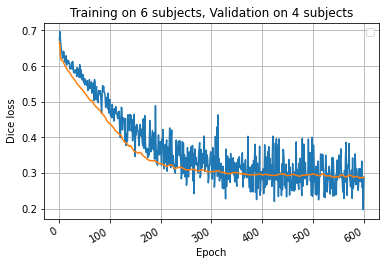

In [40]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


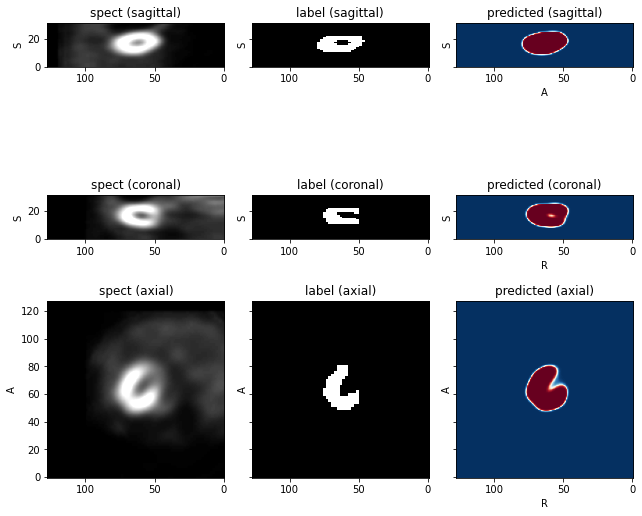

In [41]:
batch = next(iter(validation_loader))

model.eval()

inputs, targets = prepare_batch(batch, device)
FIRST = 1
FOREGROUND = 1

with torch.no_grad():

    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()

affine = batch['spect'][tio.AFFINE][0].numpy()

subject = tio.Subject(
    spect=tio.ScalarImage(tensor=batch['spect'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['left_ventricle'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

  0%|          | 0/1 [00:00<?, ?it/s]

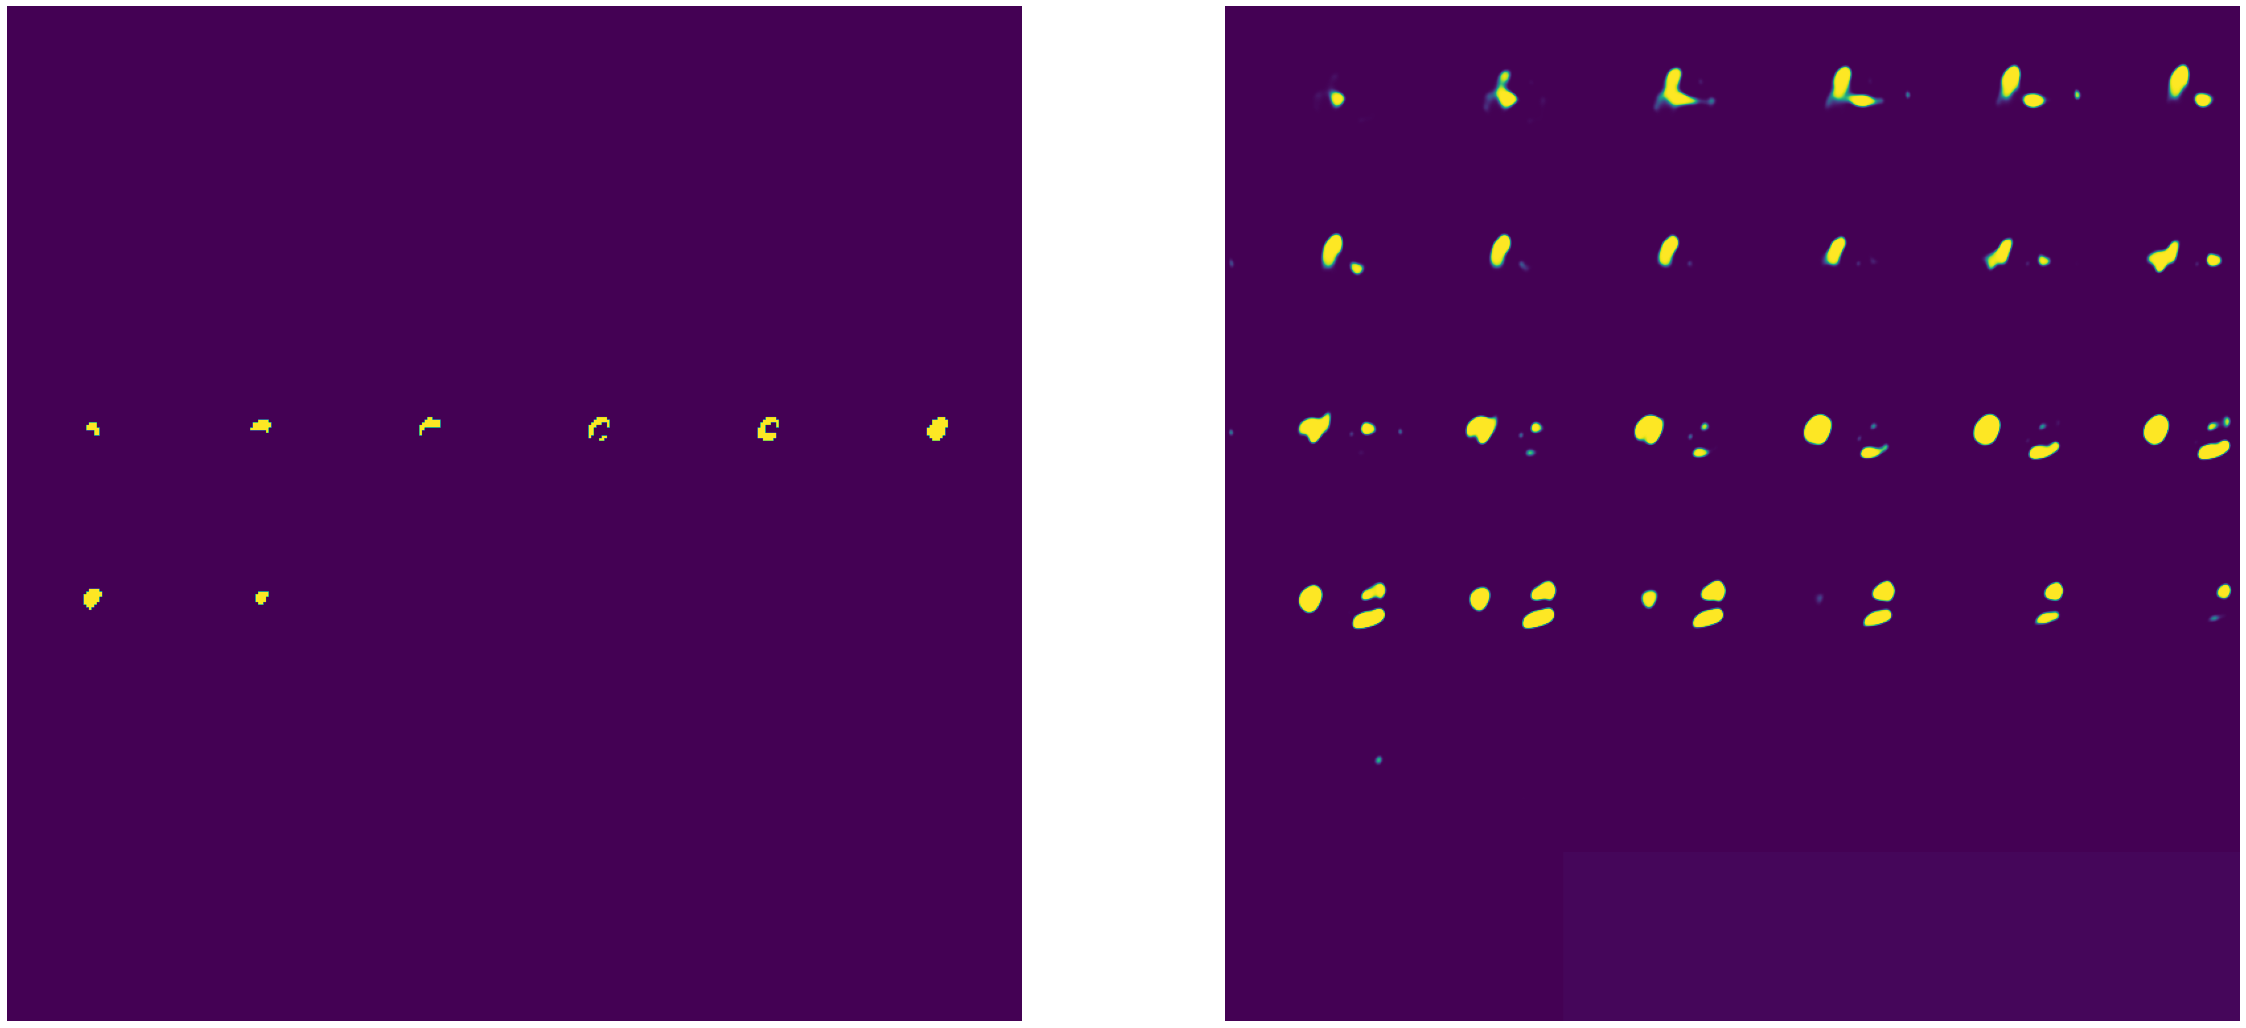

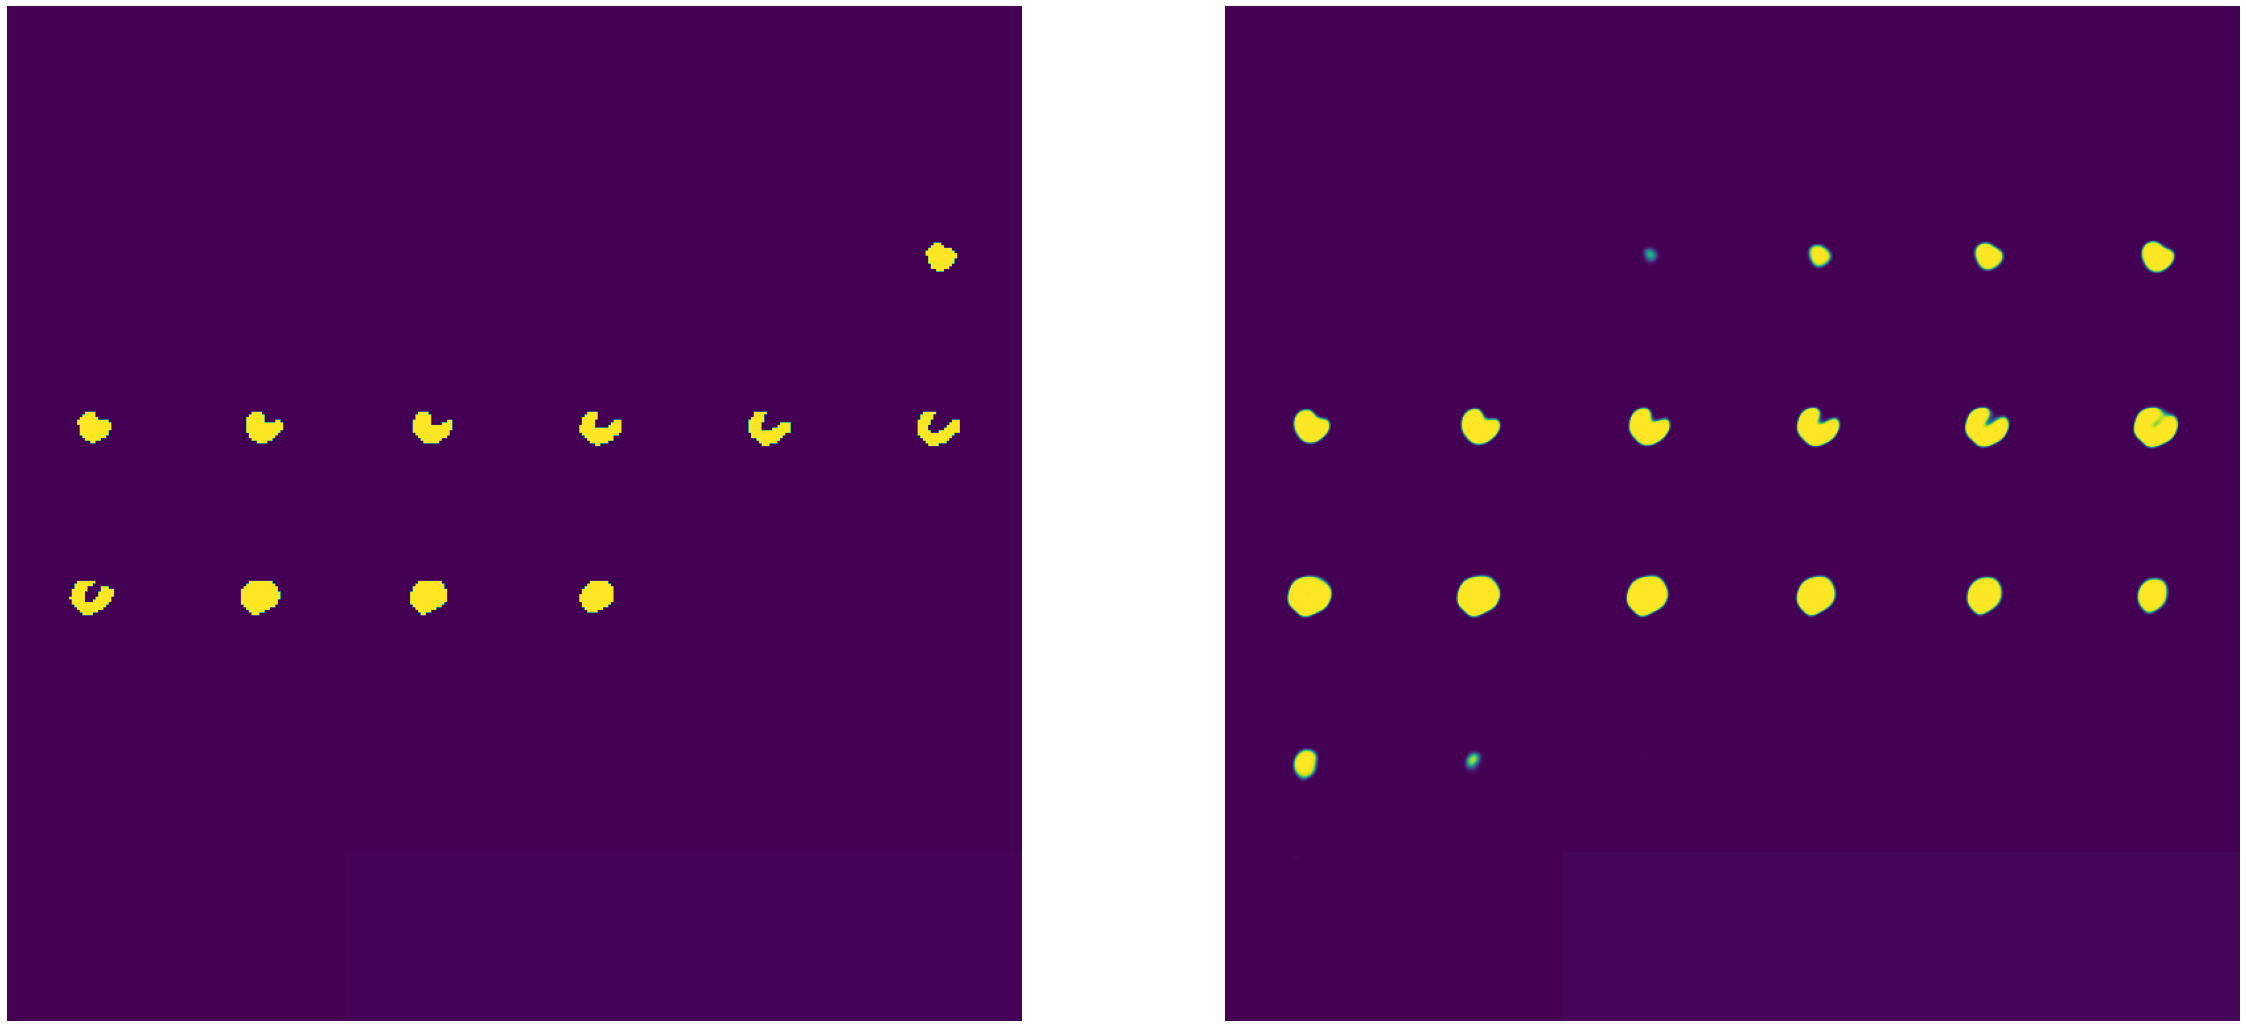

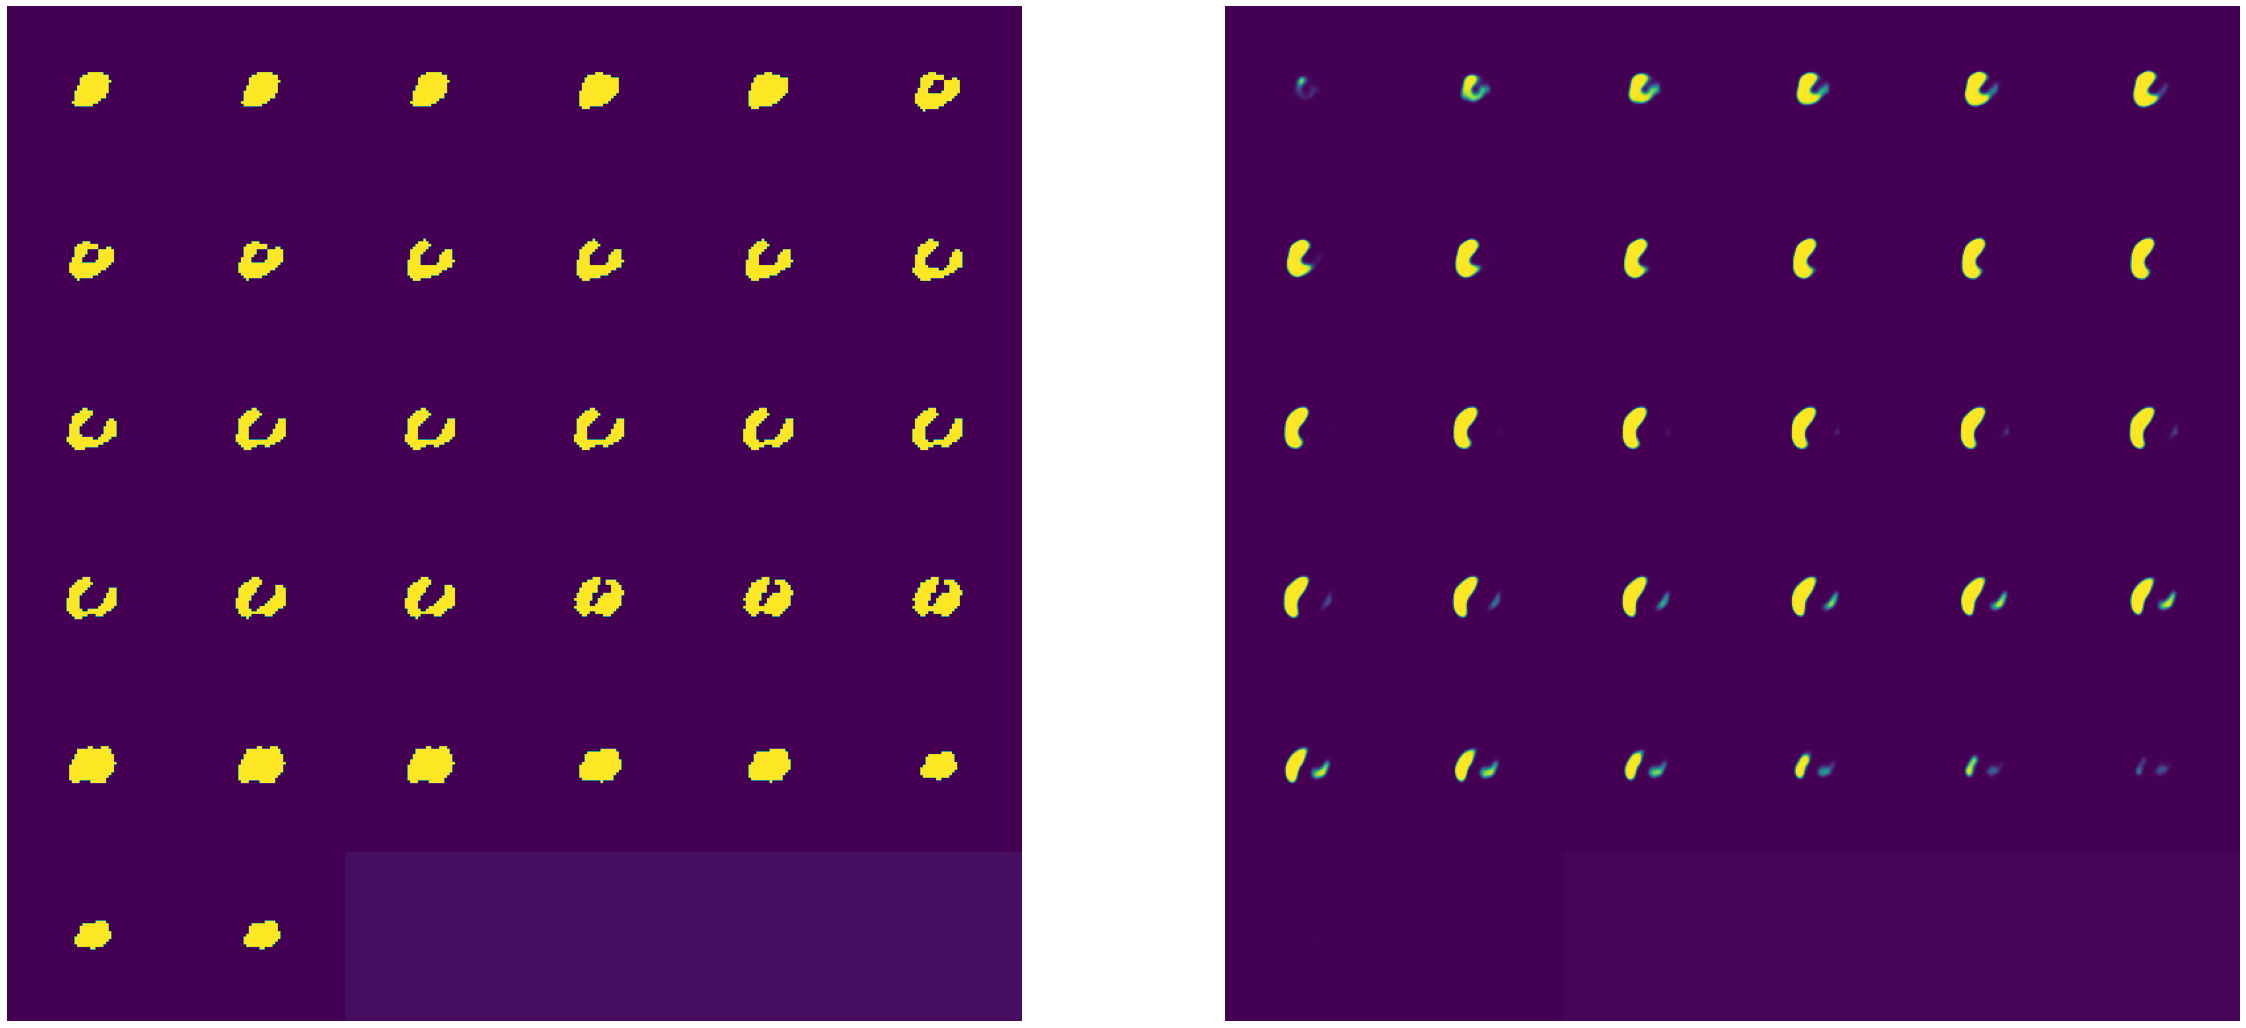

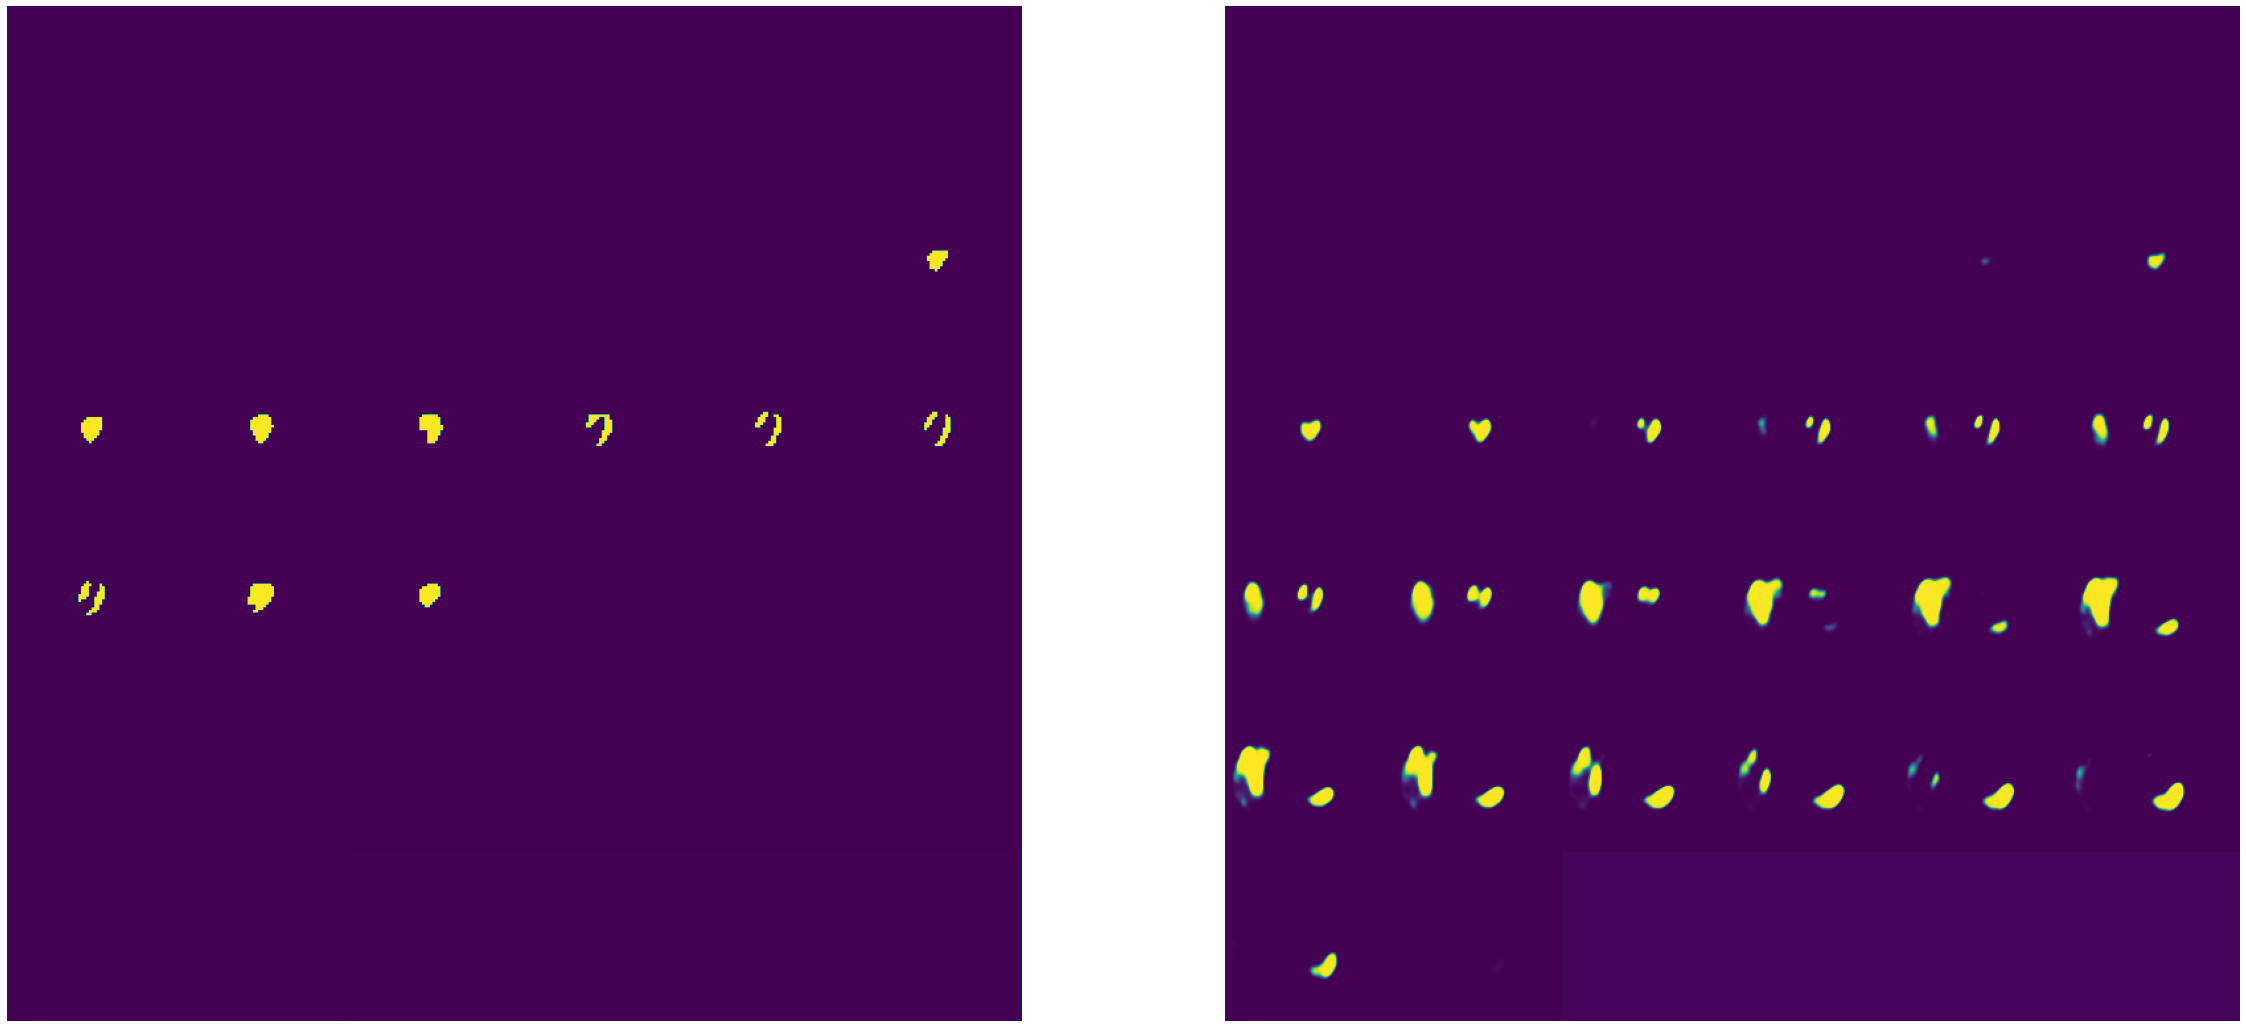

In [42]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

In [43]:
precision, recall, iou = compute_metrics(predictions, targets)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.4348
Recall: 0.7587
IoU: 0.3047


## Tune every parameter

In [44]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 500
learning_rate = 1e-3
dropout = 0.5

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=dropout
).to(device)

model.encoder.load_state_dict(encoder_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.660	Precision: 0.02	Recall: 0.82	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.632	Precision: 0.04	Recall: 1.00	IoU: 0.04
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.659	Precision: 0.02	Recall: 1.00	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.616	Precision: 0.07	Recall: 1.00	IoU: 0.07
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.642	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.612	Precision: 0.08	Recall: 1.00	IoU: 0.08
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.643	Precision: 0.03	Recall: 1.00	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.610	Precision: 0.10	Recall: 1.00	IoU: 0.10
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.614	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.608	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.616	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.606	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.627	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.604	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.614	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.603	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.613	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.601	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.620	Precision: 0.07	Recall: 0.99	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.599	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.612	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.597	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.609	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.595	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.600	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.592	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.600	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.589	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.599	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.587	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.592	Precision: 0.05	Recall: 1.00	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.585	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.598	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.582	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.599	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.580	Precision: 0.12	Recall: 1.00	IoU: 0.12
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.613	Precision: nan	Recall: 0.83	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.578	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.591	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.577	Precision: 0.13	Recall: 1.00	IoU: 0.13
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.600	Precision: 0.04	Recall: 0.83	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.576	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.579	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.575	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.598	Precision: 0.08	Recall: 0.83	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.573	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.581	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.572	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.584	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.570	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.583	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.568	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.575	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.566	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.578	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.564	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.576	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.563	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.571	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.561	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.582	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.559	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.587	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.557	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.585	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.555	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.570	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.554	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.573	Precision: 0.06	Recall: 0.93	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.552	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.584	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.551	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.567	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.550	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.576	Precision: nan	Recall: 0.83	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.549	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.570	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.548	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.564	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.547	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.557	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.546	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.576	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.545	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.573	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.544	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.553	Precision: 0.07	Recall: 1.00	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.543	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.558	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.542	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.551	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.541	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.563	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.540	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.552	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.539	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.561	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.538	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.550	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.537	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.560	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.559	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.536	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.563	Precision: 0.10	Recall: 0.99	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.534	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.552	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.533	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.543	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.531	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.558	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.530	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.550	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.529	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.552	Precision: 0.12	Recall: 0.99	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.529	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.540	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.528	Precision: 0.15	Recall: 1.00	IoU: 0.15
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.547	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.526	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.548	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.524	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.547	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.523	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.549	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.521	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.533	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.520	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.10	Recall: 0.99	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.520	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.534	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.518	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.541	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.517	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.543	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.516	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.534	Precision: 0.12	Recall: 0.99	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.514	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.536	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.548	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.548	Precision: 0.06	Recall: 1.00	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.569	Precision: nan	Recall: 0.83	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.540	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.513	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.544	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.537	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.512	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.545	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.511	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.530	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.510	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.517	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.509	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.528	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.509	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.538	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.508	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.532	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.507	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.517	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.505	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.539	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.504	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.518	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.551	Precision: nan	Recall: 0.83	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.503	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.538	Precision: 0.13	Recall: 0.99	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.539	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.535	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.517	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.502	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.515	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.501	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.517	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.499	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.524	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.498	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.504	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.497	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.513	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.495	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.529	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.494	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.513	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.493	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.492	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 101


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.519	Precision: 0.13	Recall: 0.98	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.491	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 102


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.531	Precision: 0.08	Recall: 1.00	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.489	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 103


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.498	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.488	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 104


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.507	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.488	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 105


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.514	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.487	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 106


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.503	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.486	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 107


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.486	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 108


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.508	Precision: 0.15	Recall: 0.99	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.485	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 109


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.516	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 110


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.541	Precision: 0.11	Recall: 0.98	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 111


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.516	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 112


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.498	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.484	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 113


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.490	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 114


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.504	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.483	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 115


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.508	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.482	Precision: 0.18	Recall: 1.00	IoU: 0.18
Starting epoch 116


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.508	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.481	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 117


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.481	Precision: 0.19	Recall: 1.00	IoU: 0.19
Starting epoch 118


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.499	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.480	Precision: 0.20	Recall: 1.00	IoU: 0.20
Starting epoch 119


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.493	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.478	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 120


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.502	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.476	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 121


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.496	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.475	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 122


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.473	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 123


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.502	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.472	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 124


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.472	Precision: 0.20	Recall: 0.99	IoU: 0.19
Starting epoch 125


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.493	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471	Precision: 0.20	Recall: 0.99	IoU: 0.19
Starting epoch 126


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.471	Precision: 0.20	Recall: 0.99	IoU: 0.19
Starting epoch 127


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.488	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.470	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 128


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 129


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.469	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 130


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.489	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 131


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.512	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 132


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.14	Recall: 0.99	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.468	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 133


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.505	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.467	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 134


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.491	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.467	Precision: 0.21	Recall: 0.98	IoU: 0.21
Starting epoch 135


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.511	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.466	Precision: 0.21	Recall: 0.98	IoU: 0.21
Starting epoch 136


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.506	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.465	Precision: 0.21	Recall: 0.98	IoU: 0.21
Starting epoch 137


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.495	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.464	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 138


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.497	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.462	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 139


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.461	Precision: 0.21	Recall: 0.99	IoU: 0.20
Starting epoch 140


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.499	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.459	Precision: 0.21	Recall: 0.99	IoU: 0.20
Starting epoch 141


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.458	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 142


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.481	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.456	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 143


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.492	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.455	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 144


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.453	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 145


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.467	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.453	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 146


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.452	Precision: 0.22	Recall: 0.97	IoU: 0.22
Starting epoch 147


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.450	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 148


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.506	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.449	Precision: 0.23	Recall: 0.98	IoU: 0.22
Starting epoch 149


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.448	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 150


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.481	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.448	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 151


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.447	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 152


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.448	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 153


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.486	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.447	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 154


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.470	Precision: 0.12	Recall: 1.00	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.445	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 155


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.445	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 156


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.501	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.445	Precision: 0.20	Recall: 0.99	IoU: 0.20
Starting epoch 157


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 158


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.481	Precision: 0.14	Recall: 0.99	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 159


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.469	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.446	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 160


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.499	Precision: 0.10	Recall: 1.00	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.444	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 161


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.487	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.443	Precision: 0.22	Recall: 0.98	IoU: 0.21
Starting epoch 162


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.443	Precision: 0.22	Recall: 0.98	IoU: 0.21
Starting epoch 163


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.442	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 164


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.492	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.441	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 165


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.471	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.441	Precision: 0.22	Recall: 0.97	IoU: 0.22
Starting epoch 166


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.440	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 167


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.499	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.439	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 168


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.470	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.439	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 169


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.477	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 170


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.16	Recall: 0.99	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.438	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 171


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.497	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.437	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 172


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.489	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.437	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 173


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.470	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.437	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 174


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.493	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.436	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 175


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.435	Precision: 0.23	Recall: 0.98	IoU: 0.22
Starting epoch 176


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.491	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.435	Precision: 0.23	Recall: 0.98	IoU: 0.22
Starting epoch 177


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.461	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.434	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 178


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.444	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.434	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 179


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.500	Precision: 0.09	Recall: 1.00	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.434	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 180


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.459	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.434	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 181


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.433	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 182


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.467	Precision: 0.15	Recall: 0.92	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.431	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 183


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.473	Precision: 0.15	Recall: 0.95	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.430	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 184


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.462	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.429	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 185


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.480	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.429	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 186


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.19	Recall: 0.98	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.428	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 187


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.426	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 188


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.17	Recall: 0.98	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.425	Precision: 0.23	Recall: 0.97	IoU: 0.23
Starting epoch 189


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.447	Precision: 0.18	Recall: 0.99	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.425	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 190


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.14	Recall: 1.00	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.424	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 191


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.13	Recall: 0.99	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.423	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 192


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.423	Precision: 0.24	Recall: 0.97	IoU: 0.23
Starting epoch 193


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.422	Precision: 0.24	Recall: 0.97	IoU: 0.23
Starting epoch 194


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.15	Recall: 1.00	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.422	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 195


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.466	Precision: 0.13	Recall: 1.00	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.422	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 196


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.421	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 197


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.475	Precision: nan	Recall: 0.83	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.419	Precision: 0.24	Recall: 0.96	IoU: 0.23
Starting epoch 198


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.490	Precision: 0.11	Recall: 0.94	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.23	Recall: 0.98	IoU: 0.22
Starting epoch 199


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.469	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.419	Precision: 0.22	Recall: 0.99	IoU: 0.21
Starting epoch 200


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: 0.11	Recall: 0.99	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.420	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 201


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.488	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.420	Precision: 0.21	Recall: 0.99	IoU: 0.20
Starting epoch 202


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.460	Precision: 0.13	Recall: 0.99	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.419	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 203


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.487	Precision: 0.11	Recall: 0.94	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.419	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 204


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.463	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.21	Recall: 0.99	IoU: 0.21
Starting epoch 205


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.15	Recall: 0.99	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 206


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.453	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.22	Recall: 0.98	IoU: 0.22
Starting epoch 207


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 208


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.494	Precision: 0.20	Recall: 1.00	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 209


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.448	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.418	Precision: 0.23	Recall: 0.97	IoU: 0.22
Starting epoch 210


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.454	Precision: 0.15	Recall: 0.98	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.417	Precision: 0.23	Recall: 0.96	IoU: 0.23
Starting epoch 211


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.437	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.416	Precision: 0.23	Recall: 0.96	IoU: 0.22
Starting epoch 212


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.415	Precision: 0.24	Recall: 0.95	IoU: 0.22
Starting epoch 213


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.414	Precision: 0.24	Recall: 0.95	IoU: 0.22
Starting epoch 214


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.476	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.413	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 215


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.431	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.412	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 216


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.441	Precision: 0.17	Recall: 0.93	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.411	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 217


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 218


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.461	Precision: 0.16	Recall: 0.99	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.409	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 219


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.456	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.409	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 220


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.475	Precision: 0.11	Recall: 1.00	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.409	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 221


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.463	Precision: 0.24	Recall: 0.99	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.408	Precision: 0.24	Recall: 0.95	IoU: 0.23
Starting epoch 222


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.17	Recall: 1.00	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.408	Precision: 0.24	Recall: 0.94	IoU: 0.23
Starting epoch 223


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.484	Precision: 0.14	Recall: 0.94	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.408	Precision: 0.25	Recall: 0.93	IoU: 0.23
Starting epoch 224


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.474	Precision: 0.16	Recall: 1.00	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.25	Recall: 0.94	IoU: 0.23
Starting epoch 225


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.428	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.25	Recall: 0.95	IoU: 0.23
Starting epoch 226


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.442	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.25	Recall: 0.94	IoU: 0.23
Starting epoch 227


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.465	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.25	Recall: 0.94	IoU: 0.23
Starting epoch 228


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.16	Recall: 0.99	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.404	Precision: 0.25	Recall: 0.94	IoU: 0.23
Starting epoch 229


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.447	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.25	Recall: 0.93	IoU: 0.23
Starting epoch 230


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.482	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.25	Recall: 0.93	IoU: 0.23
Starting epoch 231


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.19	Recall: 1.00	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.26	Recall: 0.92	IoU: 0.23
Starting epoch 232


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.432	Precision: 0.22	Recall: 1.00	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.406	Precision: 0.26	Recall: 0.89	IoU: 0.23
Starting epoch 233


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.425	Precision: 0.23	Recall: 1.00	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.27	Recall: 0.88	IoU: 0.24
Starting epoch 234


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.485	Precision: nan	Recall: 0.76	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.404	Precision: 0.27	Recall: 0.88	IoU: 0.24
Starting epoch 235


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.450	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.404	Precision: 0.26	Recall: 0.89	IoU: 0.24
Starting epoch 236


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.464	Precision: 0.21	Recall: 0.99	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.27	Recall: 0.88	IoU: 0.24
Starting epoch 237


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.468	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.407	Precision: 0.27	Recall: 0.87	IoU: 0.23
Starting epoch 238


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.448	Precision: 0.20	Recall: 1.00	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 239


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.457	Precision: 0.23	Recall: 0.99	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.410	Precision: 0.27	Recall: 0.83	IoU: 0.23
Starting epoch 240


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.453	Precision: 0.23	Recall: 0.99	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.405	Precision: 0.26	Recall: 0.86	IoU: 0.23
Starting epoch 241


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.412	Precision: 0.26	Recall: 0.90	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.402	Precision: 0.26	Recall: 0.88	IoU: 0.23
Starting epoch 242


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.435	Precision: 0.21	Recall: 0.99	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.400	Precision: 0.25	Recall: 0.89	IoU: 0.23
Starting epoch 243


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.483	Precision: 0.17	Recall: 0.80	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.399	Precision: 0.25	Recall: 0.90	IoU: 0.23
Starting epoch 244


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.439	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.399	Precision: 0.25	Recall: 0.90	IoU: 0.23
Starting epoch 245


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.420	Precision: 0.22	Recall: 1.00	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.398	Precision: 0.25	Recall: 0.89	IoU: 0.22
Starting epoch 246


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.23	Recall: 0.99	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.398	Precision: 0.25	Recall: 0.89	IoU: 0.22
Starting epoch 247


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: 0.20	Recall: 0.99	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.397	Precision: 0.25	Recall: 0.87	IoU: 0.22
Starting epoch 248


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.437	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.398	Precision: 0.26	Recall: 0.85	IoU: 0.22
Starting epoch 249


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.448	Precision: 0.18	Recall: 0.99	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.399	Precision: 0.26	Recall: 0.83	IoU: 0.22
Starting epoch 250


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: nan	Recall: 0.82	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.398	Precision: 0.26	Recall: 0.83	IoU: 0.22
Starting epoch 251


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.441	Precision: 0.20	Recall: 0.97	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.398	Precision: 0.26	Recall: 0.82	IoU: 0.22
Starting epoch 252


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.431	Precision: 0.23	Recall: 1.00	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.399	Precision: 0.26	Recall: 0.81	IoU: 0.22
Starting epoch 253


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.414	Precision: 0.29	Recall: 1.00	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.397	Precision: 0.27	Recall: 0.81	IoU: 0.22
Starting epoch 254


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.436	Precision: 0.17	Recall: 0.99	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.396	Precision: 0.27	Recall: 0.81	IoU: 0.23
Starting epoch 255


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.451	Precision: 0.20	Recall: 0.96	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.393	Precision: 0.26	Recall: 0.83	IoU: 0.23
Starting epoch 256


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.446	Precision: 0.22	Recall: 0.94	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.392	Precision: 0.26	Recall: 0.84	IoU: 0.23
Starting epoch 257


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.384	Precision: 0.21	Recall: 0.98	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.390	Precision: 0.26	Recall: 0.84	IoU: 0.23
Starting epoch 258


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.432	Precision: 0.25	Recall: 0.99	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.389	Precision: 0.27	Recall: 0.84	IoU: 0.23
Starting epoch 259


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: 0.18	Recall: 0.96	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.388	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 260


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.423	Precision: 0.27	Recall: 0.98	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.386	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 261


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.397	Precision: 0.27	Recall: 0.99	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.385	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 262


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.439	Precision: 0.22	Recall: 0.99	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 263


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.421	Precision: 0.21	Recall: 0.99	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.383	Precision: 0.27	Recall: 0.84	IoU: 0.23
Starting epoch 264


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.415	Precision: 0.20	Recall: 1.00	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.27	Recall: 0.82	IoU: 0.23
Starting epoch 265


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.421	Precision: 0.20	Recall: 0.97	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.28	Recall: 0.79	IoU: 0.23
Starting epoch 266


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: 0.26	Recall: 0.91	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.384	Precision: 0.28	Recall: 0.78	IoU: 0.23
Starting epoch 267


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.437	Precision: 0.28	Recall: 0.95	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.383	Precision: 0.28	Recall: 0.77	IoU: 0.22
Starting epoch 268


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.402	Precision: 0.25	Recall: 0.97	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.383	Precision: 0.27	Recall: 0.78	IoU: 0.22
Starting epoch 269


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.400	Precision: 0.24	Recall: 0.96	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.380	Precision: 0.26	Recall: 0.81	IoU: 0.22
Starting epoch 270


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: 0.22	Recall: 0.96	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.379	Precision: 0.26	Recall: 0.85	IoU: 0.23
Starting epoch 271


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.418	Precision: 0.24	Recall: 0.97	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.377	Precision: 0.26	Recall: 0.88	IoU: 0.23
Starting epoch 272


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.472	Precision: 0.13	Recall: 0.74	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Precision: 0.25	Recall: 0.90	IoU: 0.23
Starting epoch 273


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.375	Precision: 0.26	Recall: 0.89	IoU: 0.23
Starting epoch 274


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.394	Precision: 0.21	Recall: 0.99	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Precision: 0.26	Recall: 0.88	IoU: 0.23
Starting epoch 275


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.404	Precision: 0.22	Recall: 0.95	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.376	Precision: 0.26	Recall: 0.86	IoU: 0.23
Starting epoch 276


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.430	Precision: 0.18	Recall: 1.00	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.374	Precision: 0.26	Recall: 0.87	IoU: 0.23
Starting epoch 277


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.417	Precision: 0.23	Recall: 0.99	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.372	Precision: 0.26	Recall: 0.88	IoU: 0.23
Starting epoch 278


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.387	Precision: 0.21	Recall: 0.86	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.26	Recall: 0.88	IoU: 0.23
Starting epoch 279


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.408	Precision: 0.21	Recall: 1.00	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.26	Recall: 0.87	IoU: 0.23
Starting epoch 280


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.385	Precision: 0.22	Recall: 0.99	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.27	Recall: 0.86	IoU: 0.23
Starting epoch 281


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.428	Precision: nan	Recall: 0.82	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.27	Recall: 0.85	IoU: 0.23
Starting epoch 282


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.415	Precision: 0.17	Recall: 0.95	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.27	Recall: 0.83	IoU: 0.23
Starting epoch 283


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.358	Precision: 0.29	Recall: 0.99	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.28	Recall: 0.81	IoU: 0.23
Starting epoch 284


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.365	Precision: 0.32	Recall: 0.98	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.80	IoU: 0.23
Starting epoch 285


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: 0.23	Recall: 0.86	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.369	Precision: 0.27	Recall: 0.80	IoU: 0.23
Starting epoch 286


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.445	Precision: 0.21	Recall: 0.83	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.369	Precision: 0.27	Recall: 0.80	IoU: 0.23
Starting epoch 287


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.26	Recall: 0.99	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.28	Recall: 0.78	IoU: 0.22
Starting epoch 288


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.414	Precision: 0.22	Recall: 0.99	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.76	IoU: 0.22
Starting epoch 289


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.389	Precision: 0.23	Recall: 1.00	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.74	IoU: 0.22
Starting epoch 290


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.341	Precision: 0.33	Recall: 0.88	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.74	IoU: 0.22
Starting epoch 291


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.398	Precision: 0.27	Recall: 0.99	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.73	IoU: 0.22
Starting epoch 292


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.451	Precision: 0.22	Recall: 0.90	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.370	Precision: 0.28	Recall: 0.73	IoU: 0.22
Starting epoch 293


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.28	Recall: 0.98	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.371	Precision: 0.28	Recall: 0.73	IoU: 0.22
Starting epoch 294


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: 0.37	Recall: 0.83	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.368	Precision: 0.28	Recall: 0.73	IoU: 0.22
Starting epoch 295


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.410	Precision: nan	Recall: 0.81	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.366	Precision: 0.28	Recall: 0.74	IoU: 0.22
Starting epoch 296


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.417	Precision: 0.26	Recall: 0.99	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.364	Precision: 0.29	Recall: 0.74	IoU: 0.23
Starting epoch 297


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.28	Recall: 0.91	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.360	Precision: 0.28	Recall: 0.77	IoU: 0.23
Starting epoch 298


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.434	Precision: nan	Recall: 0.83	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.29	Recall: 0.77	IoU: 0.23
Starting epoch 299


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.358	Precision: 0.26	Recall: 0.98	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.29	Recall: 0.75	IoU: 0.23
Starting epoch 300


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.30	Recall: 0.99	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.30	Recall: 0.73	IoU: 0.23
Starting epoch 301


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.388	Precision: 0.32	Recall: 0.98	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.30	Recall: 0.71	IoU: 0.23
Starting epoch 302


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.373	Precision: 0.24	Recall: 0.95	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.31	Recall: 0.67	IoU: 0.23
Starting epoch 303


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.401	Precision: 0.27	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.31	Recall: 0.66	IoU: 0.23
Starting epoch 304


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.38	Recall: 0.95	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.31	Recall: 0.64	IoU: 0.23
Starting epoch 305


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.28	Recall: 0.98	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.32	Recall: 0.63	IoU: 0.23
Starting epoch 306


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: 0.24	Recall: 0.71	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.31	Recall: 0.64	IoU: 0.22
Starting epoch 307


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.329	Precision: 0.33	Recall: 0.98	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.31	Recall: 0.64	IoU: 0.22
Starting epoch 308


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: 0.29	Recall: 0.92	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.31	Recall: 0.64	IoU: 0.22
Starting epoch 309


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.364	Precision: 0.29	Recall: 0.97	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.31	Recall: 0.63	IoU: 0.22
Starting epoch 310


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: nan	Recall: 0.80	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.31	Recall: 0.61	IoU: 0.22
Starting epoch 311


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.372	Precision: 0.26	Recall: 0.93	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.32	Recall: 0.59	IoU: 0.22
Starting epoch 312


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.401	Precision: 0.37	Recall: 0.89	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.363	Precision: 0.32	Recall: 0.59	IoU: 0.22
Starting epoch 313


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.356	Precision: 0.39	Recall: 0.84	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.362	Precision: 0.30	Recall: 0.62	IoU: 0.22
Starting epoch 314


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.381	Precision: nan	Recall: 0.74	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.359	Precision: 0.29	Recall: 0.68	IoU: 0.22
Starting epoch 315


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.326	Precision: 0.35	Recall: 0.91	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.355	Precision: 0.29	Recall: 0.73	IoU: 0.23
Starting epoch 316


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: 0.27	Recall: 0.99	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.352	Precision: 0.29	Recall: 0.77	IoU: 0.23
Starting epoch 317


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.401	Precision: 0.27	Recall: 0.91	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.29	Recall: 0.78	IoU: 0.23
Starting epoch 318


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: 0.26	Recall: 0.99	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.29	Recall: 0.78	IoU: 0.24
Starting epoch 319


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.378	Precision: 0.27	Recall: 1.00	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.29	Recall: 0.77	IoU: 0.24
Starting epoch 320


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.357	Precision: 0.30	Recall: 0.99	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.29	Recall: 0.74	IoU: 0.23
Starting epoch 321


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.361	Precision: nan	Recall: 0.80	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.30	Recall: 0.72	IoU: 0.23
Starting epoch 322


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.343	Precision: 0.32	Recall: 0.85	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.30	Recall: 0.71	IoU: 0.23
Starting epoch 323


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.371	Precision: 0.34	Recall: 0.96	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.30	Recall: 0.70	IoU: 0.23
Starting epoch 324


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.428	Precision: 0.25	Recall: 0.90	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.31	Recall: 0.69	IoU: 0.23
Starting epoch 325


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.39	Recall: 0.89	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.30	Recall: 0.69	IoU: 0.23
Starting epoch 326


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: 0.35	Recall: 0.74	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.348	Precision: 0.30	Recall: 0.72	IoU: 0.24
Starting epoch 327


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: 0.34	Recall: 0.76	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.30	Recall: 0.73	IoU: 0.24
Starting epoch 328


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.364	Precision: 0.34	Recall: 0.83	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.30	Recall: 0.75	IoU: 0.24
Starting epoch 329


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.444	Precision: nan	Recall: 0.79	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.30	Recall: 0.75	IoU: 0.24
Starting epoch 330


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: nan	Recall: 0.77	IoU: 0.26


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.30	Recall: 0.75	IoU: 0.24
Starting epoch 331


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.375	Precision: 0.22	Recall: 0.94	IoU: 0.22


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.30	Recall: 0.75	IoU: 0.24
Starting epoch 332


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.328	Precision: 0.28	Recall: 0.93	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.30	Recall: 0.73	IoU: 0.24
Starting epoch 333


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.373	Precision: 0.29	Recall: 0.98	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.31	Recall: 0.71	IoU: 0.23
Starting epoch 334


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.412	Precision: 0.19	Recall: 0.64	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.348	Precision: 0.31	Recall: 0.69	IoU: 0.23
Starting epoch 335


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: 0.34	Recall: 0.99	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.31	Recall: 0.66	IoU: 0.23
Starting epoch 336


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.361	Precision: 0.32	Recall: 0.93	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.350	Precision: 0.31	Recall: 0.65	IoU: 0.23
Starting epoch 337


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: 0.31	Recall: 0.98	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.351	Precision: 0.31	Recall: 0.64	IoU: 0.23
Starting epoch 338


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.327	Precision: 0.32	Recall: 0.95	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.352	Precision: 0.32	Recall: 0.62	IoU: 0.23
Starting epoch 339


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.432	Precision: 0.21	Recall: 0.83	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.353	Precision: 0.32	Recall: 0.61	IoU: 0.23
Starting epoch 340


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.345	Precision: 0.40	Recall: 0.95	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.352	Precision: 0.33	Recall: 0.61	IoU: 0.23
Starting epoch 341


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.407	Precision: 0.32	Recall: 0.88	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.351	Precision: 0.32	Recall: 0.64	IoU: 0.23
Starting epoch 342


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: nan	Recall: 0.81	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.349	Precision: 0.31	Recall: 0.67	IoU: 0.23
Starting epoch 343


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.38	Recall: 0.85	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.31	Recall: 0.69	IoU: 0.23
Starting epoch 344


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.364	Precision: 0.29	Recall: 0.89	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.31	Recall: 0.70	IoU: 0.23
Starting epoch 345


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.361	Precision: 0.33	Recall: 0.88	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.31	Recall: 0.70	IoU: 0.23
Starting epoch 346


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.377	Precision: 0.37	Recall: 0.82	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.31	Recall: 0.69	IoU: 0.23
Starting epoch 347


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.356	Precision: 0.32	Recall: 0.91	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.31	Recall: 0.68	IoU: 0.23
Starting epoch 348


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.353	Precision: nan	Recall: 0.70	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 349


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.372	Precision: 0.34	Recall: 0.99	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 350


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.297	Precision: 0.43	Recall: 0.95	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.65	IoU: 0.23
Starting epoch 351


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.40	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 352


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: nan	Recall: 0.75	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 353


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.317	Precision: 0.33	Recall: 0.96	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 354


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.322	Precision: 0.41	Recall: 0.97	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 355


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: 0.32	Recall: 0.93	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.32	Recall: 0.64	IoU: 0.23
Starting epoch 356


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: 0.38	Recall: 0.92	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.33	Recall: 0.64	IoU: 0.23
Starting epoch 357


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.38	Recall: 0.88	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.33	Recall: 0.63	IoU: 0.23
Starting epoch 358


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.33	Recall: 0.97	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.33	Recall: 0.62	IoU: 0.23
Starting epoch 359


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.362	Precision: 0.35	Recall: 0.99	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.33	Recall: 0.62	IoU: 0.23
Starting epoch 360


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: 0.43	Recall: 0.79	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.347	Precision: 0.33	Recall: 0.63	IoU: 0.23
Starting epoch 361


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.41	Recall: 0.86	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.346	Precision: 0.32	Recall: 0.65	IoU: 0.23
Starting epoch 362


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.274	Precision: 0.37	Recall: 0.98	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.32	Recall: 0.65	IoU: 0.23
Starting epoch 363


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.35	Recall: 0.92	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.32	Recall: 0.64	IoU: 0.23
Starting epoch 364


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.270	Precision: 0.42	Recall: 0.79	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.33	Recall: 0.63	IoU: 0.23
Starting epoch 365


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: 0.29	Recall: 0.84	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.33	Recall: 0.61	IoU: 0.23
Starting epoch 366


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.36	Recall: 0.94	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.345	Precision: 0.34	Recall: 0.61	IoU: 0.23
Starting epoch 367


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.299	Precision: 0.41	Recall: 0.67	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.344	Precision: 0.34	Recall: 0.61	IoU: 0.24
Starting epoch 368


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.35	Recall: 0.89	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.344	Precision: 0.34	Recall: 0.61	IoU: 0.24
Starting epoch 369


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.334	Precision: nan	Recall: 0.82	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.343	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 370


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.355	Precision: nan	Recall: 0.70	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.342	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 371


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: 0.41	Recall: 0.80	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 372


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.253	Precision: 0.43	Recall: 0.96	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.61	IoU: 0.24
Starting epoch 373


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.429	Precision: nan	Recall: 0.64	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.61	IoU: 0.24
Starting epoch 374


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: 0.35	Recall: 0.99	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 375


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.304	Precision: 0.43	Recall: 0.94	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 376


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.43	Recall: 0.84	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 377


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.348	Precision: 0.42	Recall: 0.84	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 378


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.38	Recall: 0.92	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 379


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.297	Precision: 0.38	Recall: 0.76	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 380


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: 0.34	Recall: 0.95	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.35	Recall: 0.60	IoU: 0.24
Starting epoch 381


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.323	Precision: nan	Recall: 0.77	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.60	IoU: 0.24
Starting epoch 382


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.375	Precision: 0.32	Recall: 0.86	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.59	IoU: 0.24
Starting epoch 383


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.45	Recall: 0.73	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.59	IoU: 0.24
Starting epoch 384


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.380	Precision: nan	Recall: 0.80	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.59	IoU: 0.24
Starting epoch 385


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: 0.37	Recall: 0.83	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.36	Recall: 0.59	IoU: 0.24
Starting epoch 386


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: nan	Recall: 0.53	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.36	Recall: 0.59	IoU: 0.24
Starting epoch 387


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.360	Precision: nan	Recall: 0.51	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.35	Recall: 0.60	IoU: 0.24
Starting epoch 388


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: nan	Recall: 0.70	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.34	Recall: 0.61	IoU: 0.24
Starting epoch 389


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.350	Precision: 0.31	Recall: 0.97	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.34	Recall: 0.61	IoU: 0.24
Starting epoch 390


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.323	Precision: 0.45	Recall: 0.86	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.342	Precision: 0.33	Recall: 0.62	IoU: 0.23
Starting epoch 391


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: 0.35	Recall: 0.83	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.33	Recall: 0.62	IoU: 0.23
Starting epoch 392


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.293	Precision: 0.41	Recall: 0.79	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.342	Precision: 0.32	Recall: 0.63	IoU: 0.23
Starting epoch 393


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: 0.31	Recall: 0.77	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.341	Precision: 0.32	Recall: 0.65	IoU: 0.23
Starting epoch 394


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.338	Precision: nan	Recall: 0.76	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 395


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: 0.37	Recall: 0.97	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.32	Recall: 0.66	IoU: 0.23
Starting epoch 396


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.312	Precision: nan	Recall: 0.72	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.32	Recall: 0.65	IoU: 0.24
Starting epoch 397


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.302	Precision: 0.33	Recall: 0.96	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.340	Precision: 0.33	Recall: 0.64	IoU: 0.24
Starting epoch 398


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.344	Precision: nan	Recall: 0.74	IoU: 0.24


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.33	Recall: 0.63	IoU: 0.24
Starting epoch 399


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.320	Precision: nan	Recall: 0.74	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.339	Precision: 0.34	Recall: 0.62	IoU: 0.24
Starting epoch 400


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: 0.40	Recall: 0.91	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.338	Precision: 0.34	Recall: 0.62	IoU: 0.24
Starting epoch 401


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.336	Precision: nan	Recall: 0.73	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.337	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 402


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: nan	Recall: 0.82	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 403


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.349	Precision: 0.39	Recall: 0.58	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 404


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.321	Precision: 0.45	Recall: 0.64	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 405


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.311	Precision: nan	Recall: 0.76	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 406


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.43	Recall: 0.95	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 407


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.359	Precision: 0.28	Recall: 0.96	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.35	Recall: 0.64	IoU: 0.24
Starting epoch 408


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.342	Precision: nan	Recall: 0.75	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.64	IoU: 0.24
Starting epoch 409


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.35	Recall: 0.85	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.25
Starting epoch 410


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.333	Precision: 0.34	Recall: 0.96	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.25
Starting epoch 411


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.290	Precision: 0.45	Recall: 0.85	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.64	IoU: 0.24
Starting epoch 412


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: 0.36	Recall: 0.92	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 413


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.303	Precision: 0.36	Recall: 0.97	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 414


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.370	Precision: nan	Recall: 0.79	IoU: 0.23


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 415


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.33	Recall: 0.97	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.35	Recall: 0.63	IoU: 0.24
Starting epoch 416


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.367	Precision: nan	Recall: 0.47	IoU: 0.19


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 417


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.280	Precision: 0.40	Recall: 0.89	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.337	Precision: 0.35	Recall: 0.62	IoU: 0.24
Starting epoch 418


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.41	Recall: 0.88	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.337	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 419


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.295	Precision: 0.38	Recall: 0.91	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.336	Precision: 0.35	Recall: 0.61	IoU: 0.24
Starting epoch 420


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.324	Precision: 0.32	Recall: 0.79	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.36	Recall: 0.60	IoU: 0.25
Starting epoch 421


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: nan	Recall: 0.77	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.335	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 422


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.340	Precision: 0.40	Recall: 0.91	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 423


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: 0.41	Recall: 0.68	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 424


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.258	Precision: 0.45	Recall: 0.79	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 425


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.298	Precision: 0.37	Recall: 0.76	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.334	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 426


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.284	Precision: 0.39	Recall: 0.86	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 427


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.272	Precision: 0.41	Recall: 0.86	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 428


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.339	Precision: nan	Recall: 0.75	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 429


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: 0.35	Recall: 0.91	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 430


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.417	Precision: nan	Recall: 0.50	IoU: 0.17


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 431


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.240	Precision: 0.48	Recall: 0.86	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.333	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 432


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.279	Precision: 0.42	Recall: 0.97	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 433


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.336	Precision: nan	Recall: 0.74	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 434


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.361	Precision: 0.27	Recall: 0.95	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 435


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.301	Precision: 0.43	Recall: 0.88	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 436


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.271	Precision: 0.49	Recall: 0.84	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 437


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.310	Precision: 0.34	Recall: 0.81	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 438


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.46	Recall: 0.90	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 439


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.335	Precision: nan	Recall: 0.77	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 440


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.282	Precision: 0.47	Recall: 0.79	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.332	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 441


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.38	Recall: 0.74	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 442


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.251	Precision: 0.50	Recall: 0.85	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.331	Precision: 0.37	Recall: 0.59	IoU: 0.25
Starting epoch 443


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.215	Precision: 0.51	Recall: 0.86	IoU: 0.47


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.330	Precision: 0.38	Recall: 0.59	IoU: 0.25
Starting epoch 444


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.285	Precision: 0.36	Recall: 0.95	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Precision: 0.38	Recall: 0.58	IoU: 0.26
Starting epoch 445


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.229	Precision: 0.49	Recall: 0.81	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.39	Recall: 0.58	IoU: 0.26
Starting epoch 446


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.273	Precision: 0.44	Recall: 0.88	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 447


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.252	Precision: 0.49	Recall: 0.87	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 448


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.50	Recall: 0.78	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 449


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.374	Precision: nan	Recall: 0.64	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 450


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.227	Precision: 0.58	Recall: 0.67	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 451


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.297	Precision: nan	Recall: 0.77	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.39	Recall: 0.58	IoU: 0.26
Starting epoch 452


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.41	Recall: 0.95	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 453


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.346	Precision: nan	Recall: 0.71	IoU: 0.27


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 454


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.248	Precision: 0.48	Recall: 0.90	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 455


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.47	Recall: 0.89	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 456


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: nan	Recall: 0.61	IoU: 0.29


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.38	Recall: 0.60	IoU: 0.25
Starting epoch 457


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.307	Precision: 0.41	Recall: 0.64	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Precision: 0.36	Recall: 0.62	IoU: 0.25
Starting epoch 458


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.318	Precision: 0.36	Recall: 0.81	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.329	Precision: 0.36	Recall: 0.63	IoU: 0.25
Starting epoch 459


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.308	Precision: nan	Recall: 0.72	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.36	Recall: 0.64	IoU: 0.25
Starting epoch 460


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.46	Recall: 0.89	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.64	IoU: 0.25
Starting epoch 461


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.329	Precision: 0.38	Recall: 0.92	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.65	IoU: 0.25
Starting epoch 462


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.300	Precision: 0.34	Recall: 0.88	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.65	IoU: 0.25
Starting epoch 463


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.326	Precision: nan	Recall: 0.81	IoU: 0.30


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.37	Recall: 0.64	IoU: 0.25
Starting epoch 464


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.261	Precision: 0.41	Recall: 0.96	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.37	Recall: 0.62	IoU: 0.25
Starting epoch 465


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: 0.43	Recall: 0.90	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.61	IoU: 0.26
Starting epoch 466


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: 0.34	Recall: 0.87	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.61	IoU: 0.26
Starting epoch 467


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.360	Precision: 0.57	Recall: 0.60	IoU: 0.28


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.61	IoU: 0.26
Starting epoch 468


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.292	Precision: 0.49	Recall: 0.75	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.37	Recall: 0.62	IoU: 0.25
Starting epoch 469


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: nan	Recall: 0.80	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.36	Recall: 0.63	IoU: 0.25
Starting epoch 470


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.263	Precision: 0.40	Recall: 0.92	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.63	IoU: 0.25
Starting epoch 471


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.353	Precision: nan	Recall: 0.54	IoU: 0.25


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.63	IoU: 0.25
Starting epoch 472


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.41	Recall: 0.96	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.36	Recall: 0.63	IoU: 0.25
Starting epoch 473


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.231	Precision: 0.45	Recall: 0.92	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.37	Recall: 0.62	IoU: 0.25
Starting epoch 474


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.240	Precision: 0.44	Recall: 0.95	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.37	Recall: 0.61	IoU: 0.25
Starting epoch 475


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.236	Precision: 0.47	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.60	IoU: 0.26
Starting epoch 476


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.249	Precision: 0.42	Recall: 0.92	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.39	Recall: 0.60	IoU: 0.26
Starting epoch 477


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.286	Precision: 0.36	Recall: 0.83	IoU: 0.35


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 478


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.291	Precision: 0.47	Recall: 0.82	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324	Precision: 0.40	Recall: 0.59	IoU: 0.26
Starting epoch 479


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.279	Precision: 0.44	Recall: 0.91	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 480


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.247	Precision: 0.45	Recall: 0.88	IoU: 0.43


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.324	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 481


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.268	Precision: 0.52	Recall: 0.65	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 482


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.288	Precision: nan	Recall: 0.70	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.40	Recall: 0.58	IoU: 0.26
Starting epoch 483


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.325	Precision: nan	Recall: 0.70	IoU: 0.31


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.39	Recall: 0.58	IoU: 0.26
Starting epoch 484


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.309	Precision: nan	Recall: 0.73	IoU: 0.32


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.39	Recall: 0.58	IoU: 0.26
Starting epoch 485


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.246	Precision: 0.50	Recall: 0.83	IoU: 0.41


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.38	Recall: 0.59	IoU: 0.25
Starting epoch 486


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.259	Precision: 0.42	Recall: 0.79	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 487


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.299	Precision: 0.39	Recall: 0.91	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.328	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 488


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.297	Precision: 0.45	Recall: 0.83	IoU: 0.36


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.37	Recall: 0.60	IoU: 0.25
Starting epoch 489


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.274	Precision: 0.40	Recall: 0.83	IoU: 0.39


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.327	Precision: 0.38	Recall: 0.60	IoU: 0.25
Starting epoch 490


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.273	Precision: 0.40	Recall: 0.85	IoU: 0.38


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.59	IoU: 0.26
Starting epoch 491


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.260	Precision: 0.53	Recall: 0.87	IoU: 0.45


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.59	IoU: 0.26
Starting epoch 492


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.319	Precision: 0.38	Recall: 0.80	IoU: 0.37


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 493


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.296	Precision: nan	Recall: 0.63	IoU: 0.34


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 494


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.316	Precision: nan	Recall: 0.75	IoU: 0.33


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.59	IoU: 0.26
Starting epoch 495


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.242	Precision: 0.49	Recall: 0.86	IoU: 0.46


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.59	IoU: 0.26
Starting epoch 496


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.264	Precision: 0.44	Recall: 0.94	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.38	Recall: 0.59	IoU: 0.26
Starting epoch 497


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.283	Precision: 0.46	Recall: 0.90	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.326	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 498


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.287	Precision: 0.41	Recall: 0.80	IoU: 0.40


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 499


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.277	Precision: 0.43	Recall: 0.91	IoU: 0.42


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.39	Recall: 0.59	IoU: 0.26
Starting epoch 500


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.229	Precision: 0.49	Recall: 0.91	IoU: 0.44


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.325	Precision: 0.39	Recall: 0.58	IoU: 0.26


No handles with labels found to put in legend.


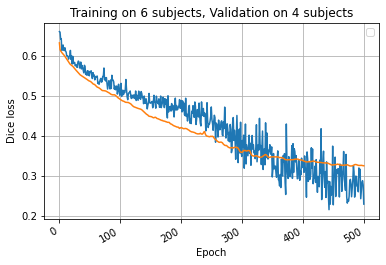

In [45]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\hkris\anaconda3\envs\SkyTorch\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


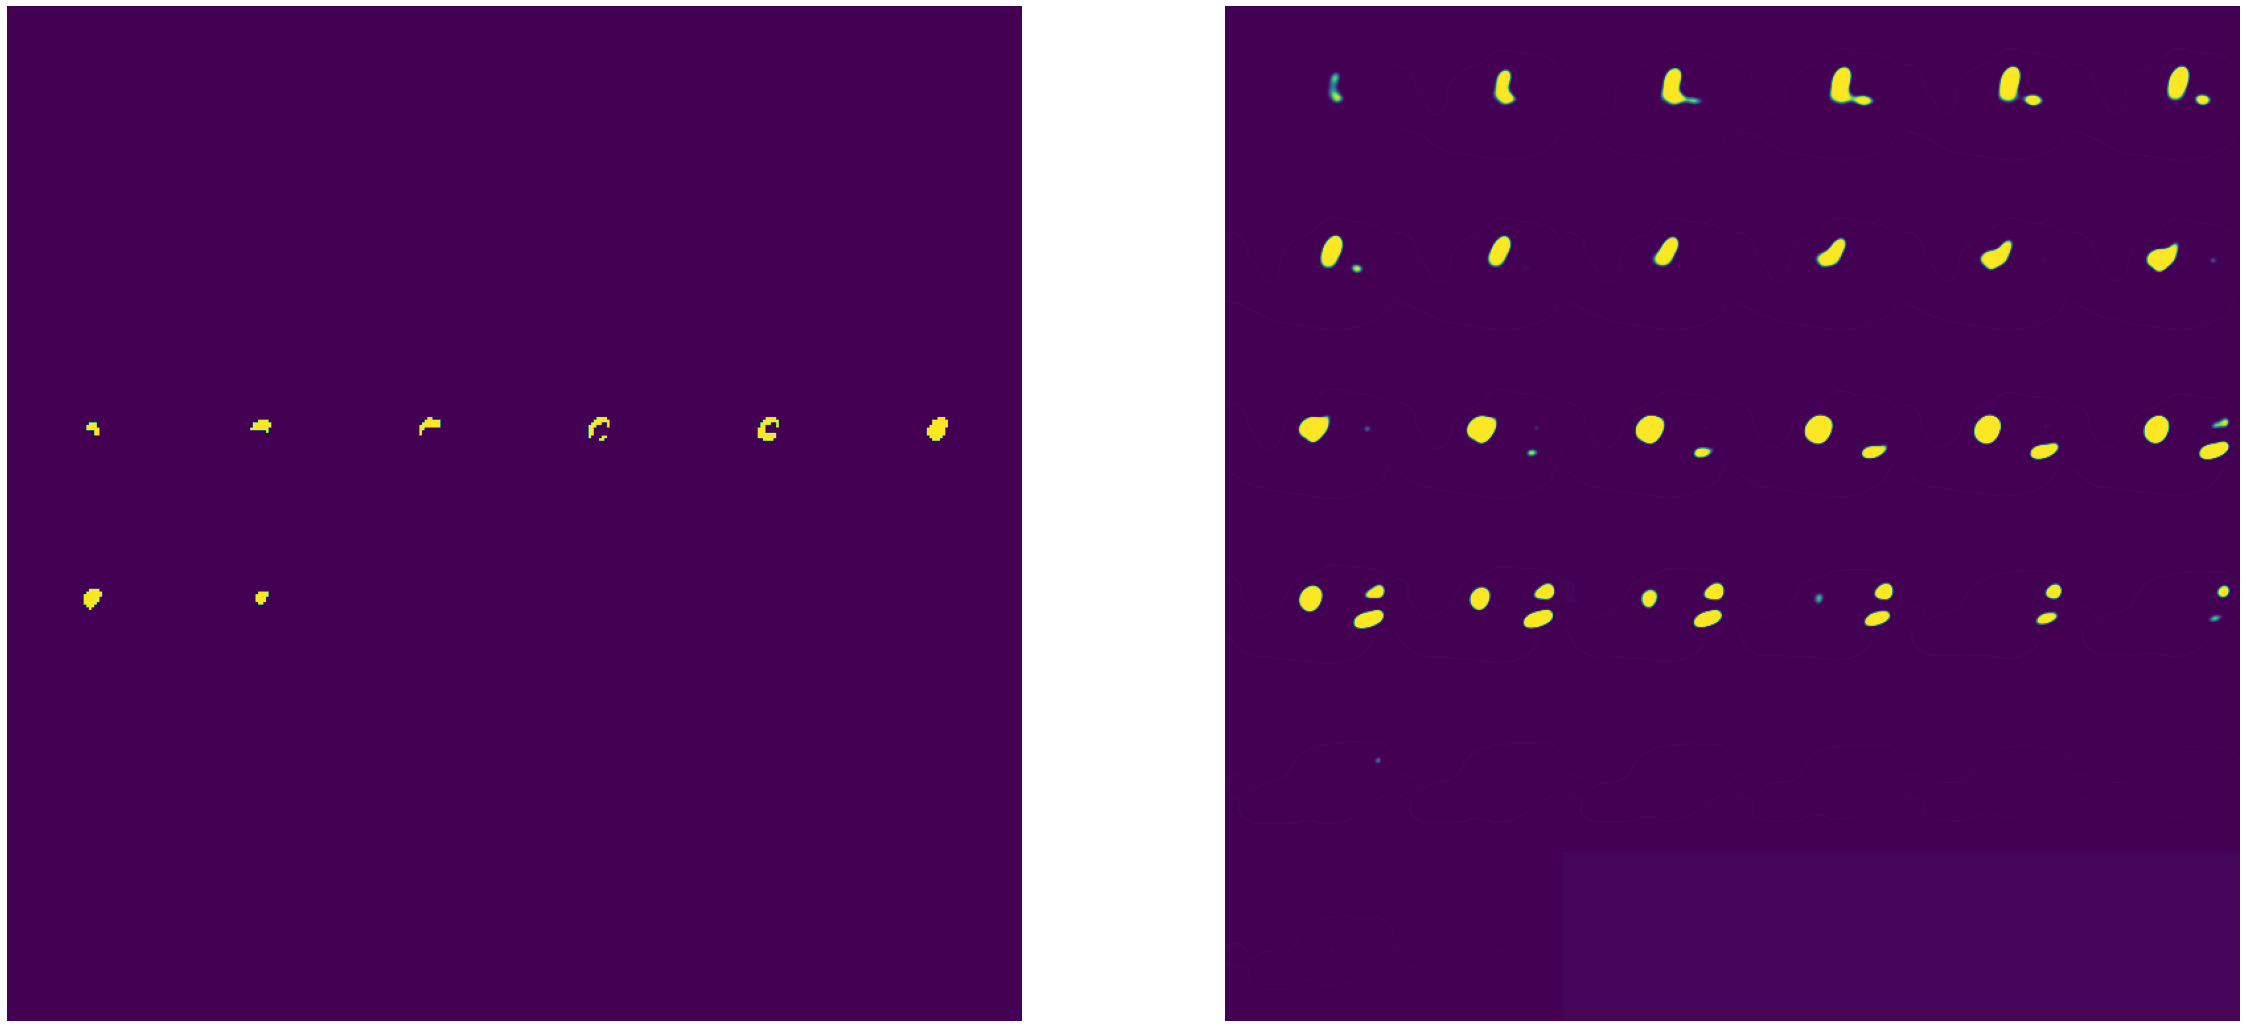

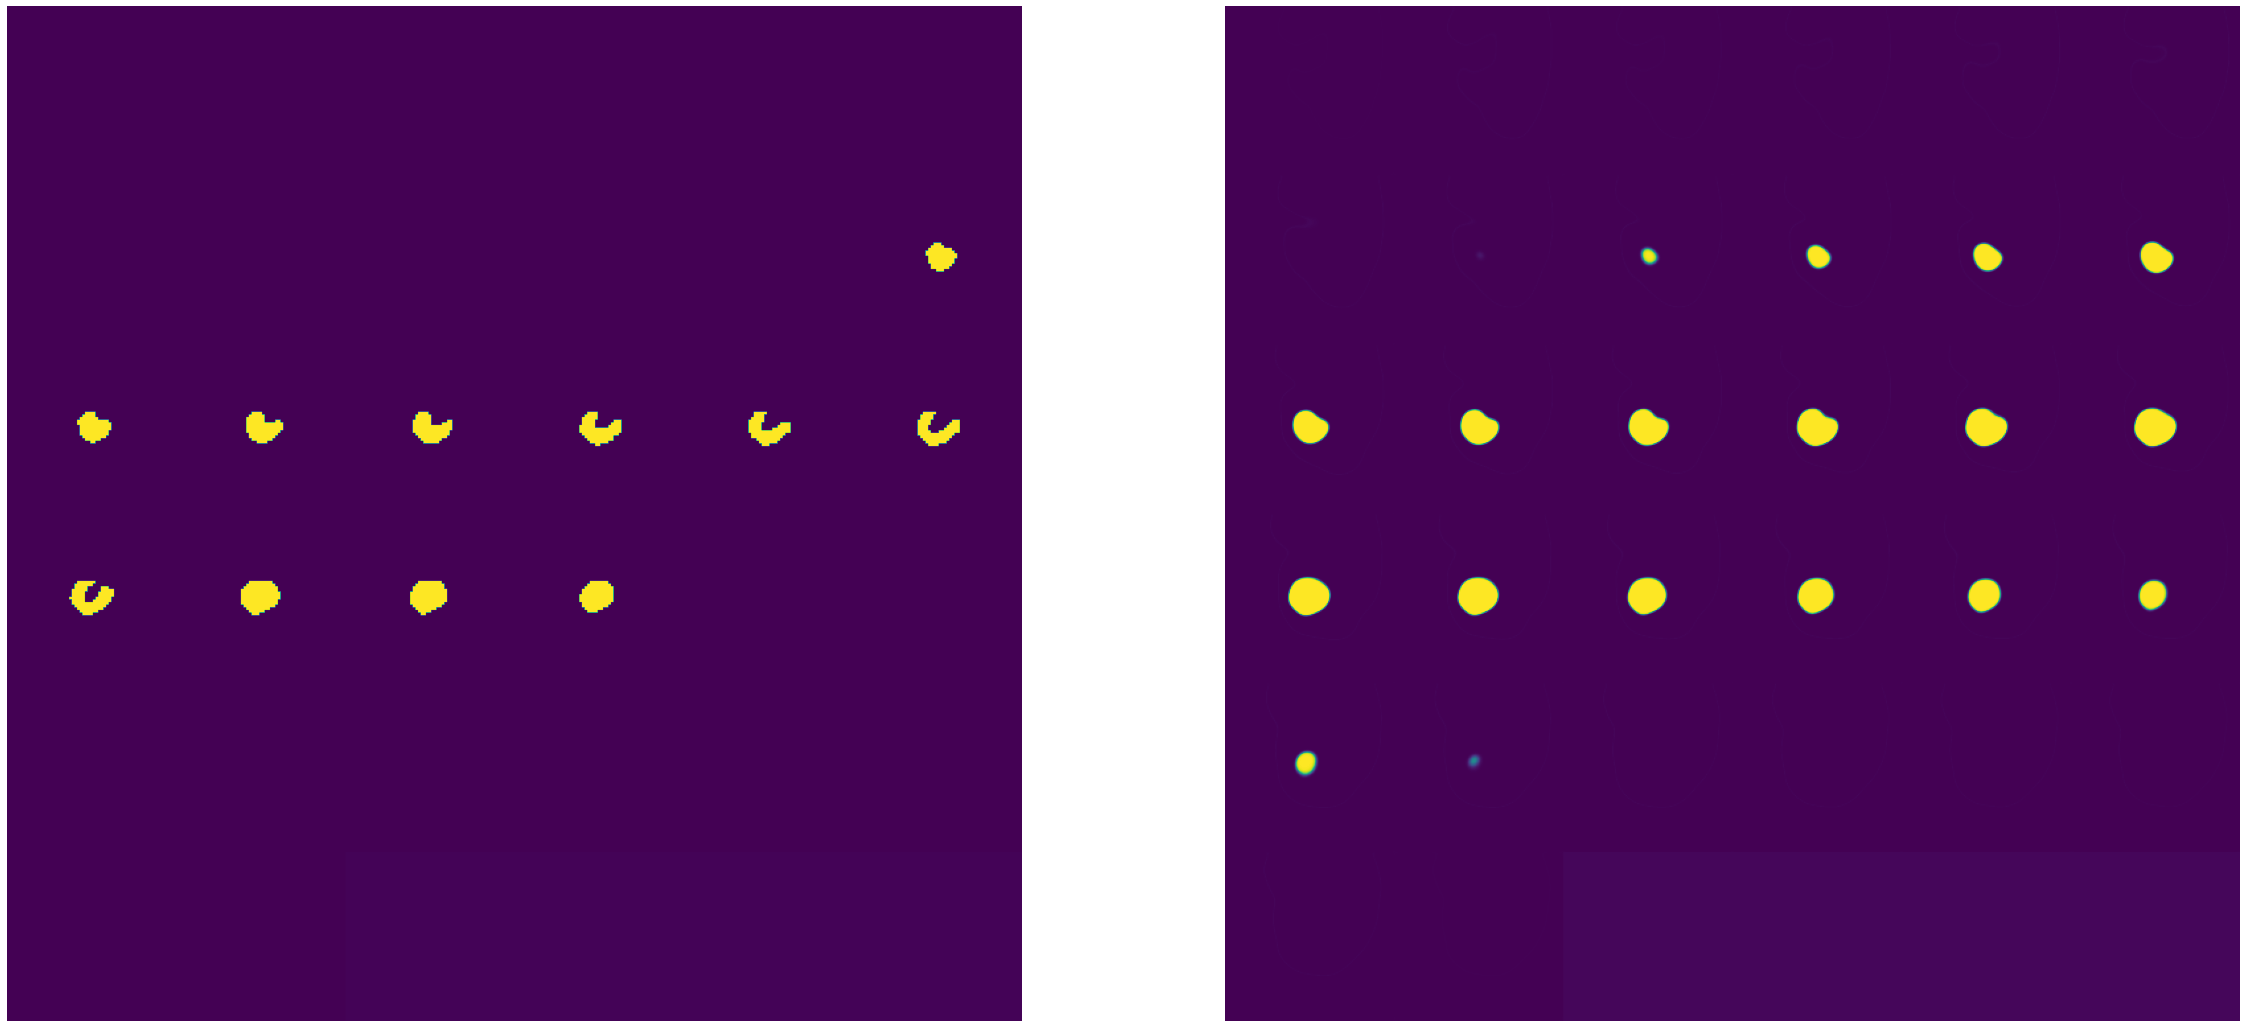

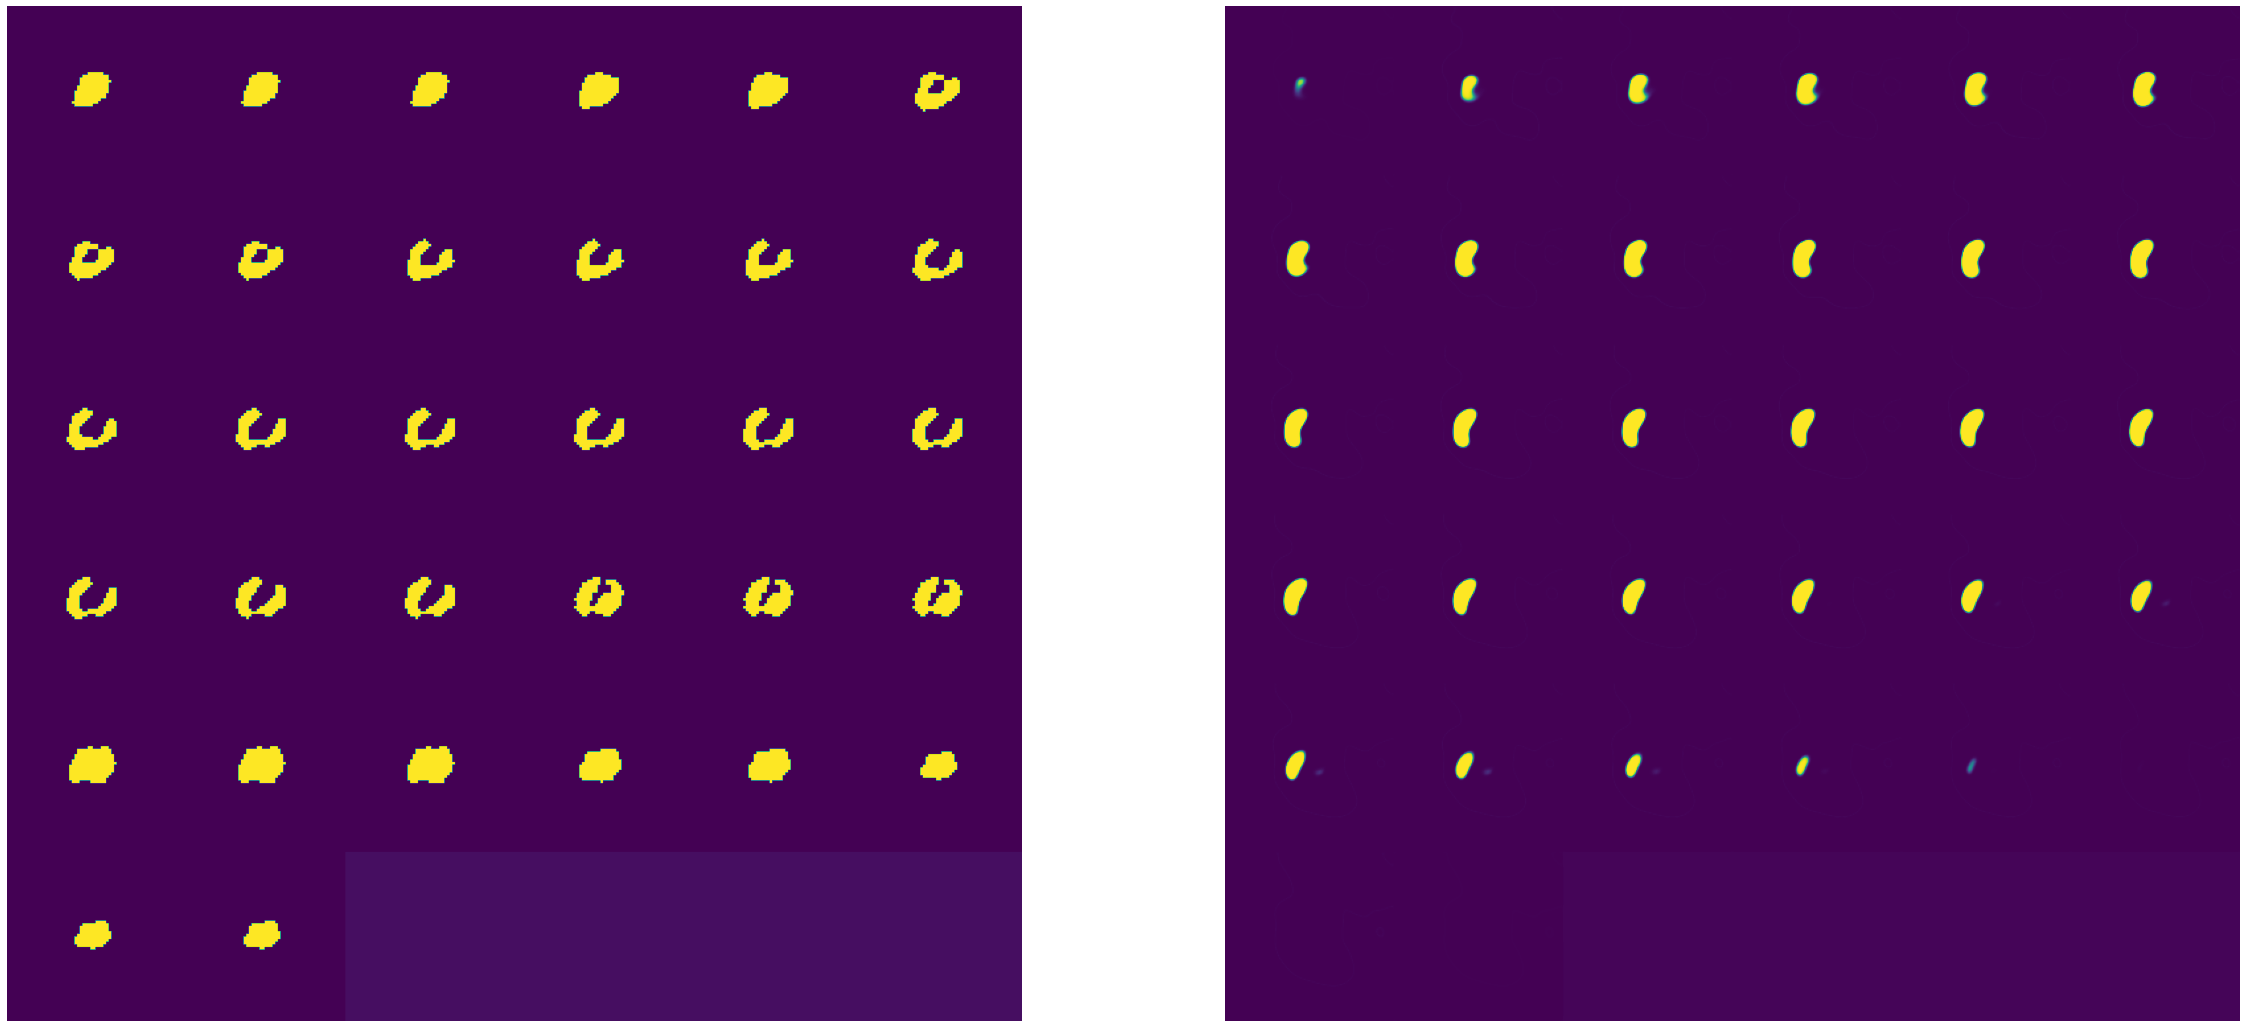

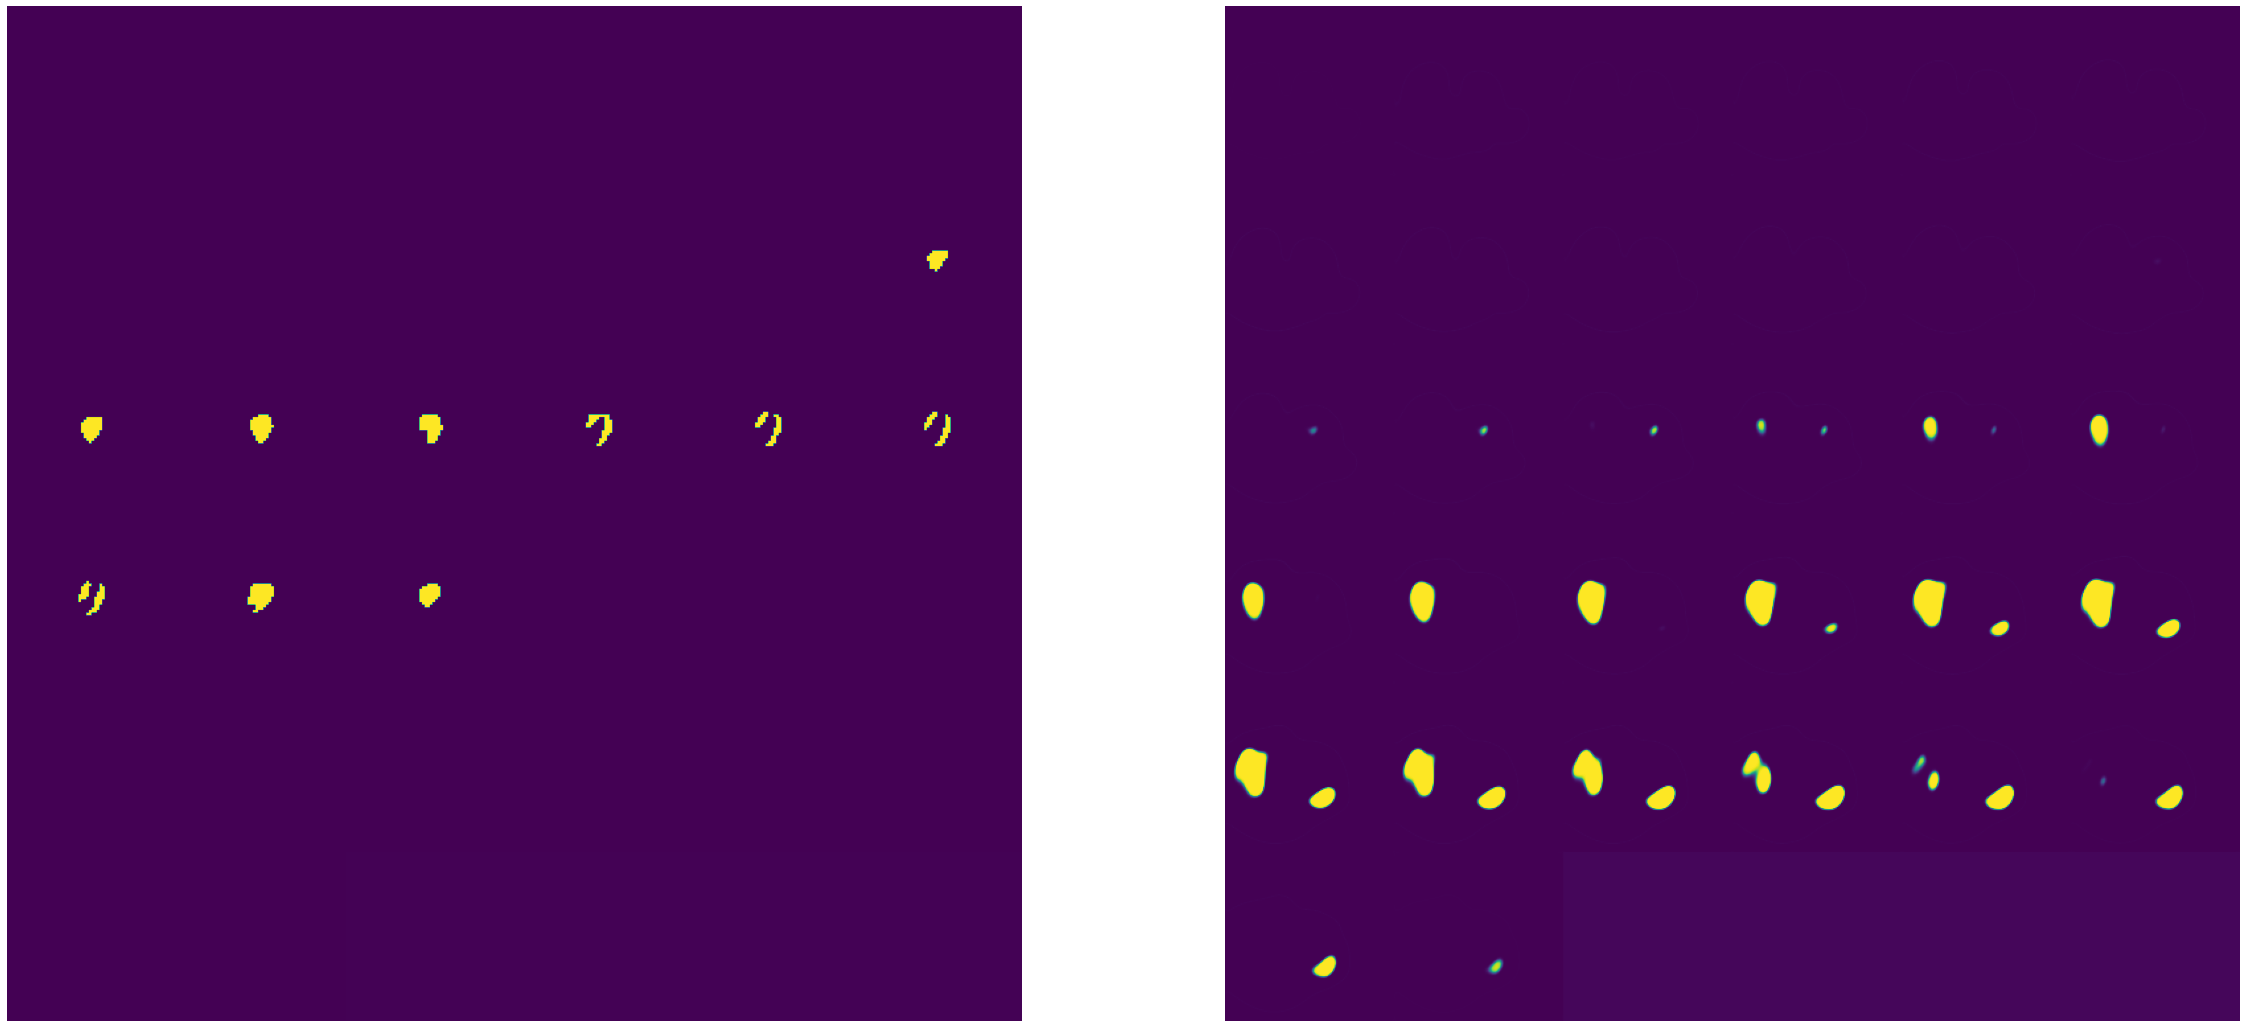

In [46]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

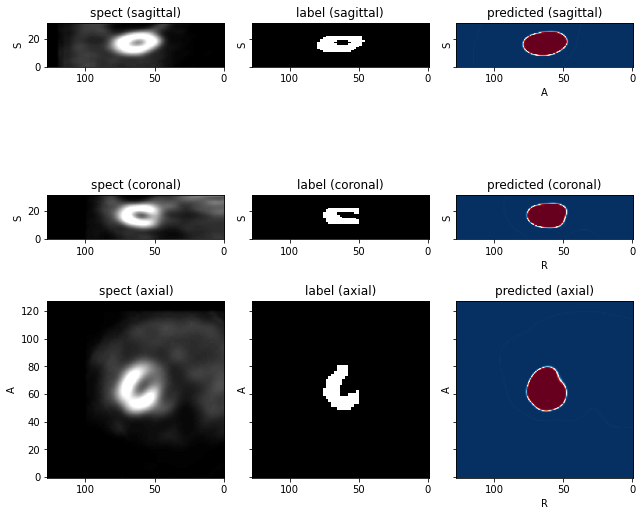

In [47]:
batch = next(iter(validation_loader))

model.eval()

inputs, targets = prepare_batch(batch, device)
FIRST = 1
FOREGROUND = 1

with torch.no_grad():

    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()

affine = batch['spect'][tio.AFFINE][0].numpy()

subject = tio.Subject(
    spect=tio.ScalarImage(tensor=batch['spect'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['left_ventricle'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

In [30]:
precision, recall, iou = compute_metrics(predictions, targets)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"IoU: {iou:.4f}")

Precision: 0.6405
Recall: 0.7472
IoU: 0.4829


In [ ]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 600
learning_rate = 1e-3
dropout = 0.5

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=dropout
).to(device)

model.encoder.load_state_dict(encoder_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

## Focal loss

In [32]:
def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler):
    
    is_training = action == Action.TRAIN
    epoch_losses = []
    precisions, recalls, ious = [], [], []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
    
        with torch.set_grad_enabled(is_training):
        
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            #batch_losses = sigmoid_focal_loss(probabilities, targets)
            batch_losses = sigmoid_focal_loss(logits, targets, gamma=1.0)
            batch_loss = batch_losses.mean()
            
            if is_training:
            
                batch_loss.backward()
                optimizer.step()
            
            epoch_losses.append(batch_loss.item())
            
            prec, rec, iou = compute_metrics(probabilities, targets)
            precisions.append(prec)
            recalls.append(rec)
            ious.append(iou)
    
    if scheduler is not None:
        scheduler.step()
    epoch_losses = np.array(epoch_losses).mean()
    
    print(
        f'{action.value} mean loss: {epoch_losses.mean():0.3f}'
        f'\tPrecision: {np.array(precisions).mean():.2f}'
        f'\tRecall: {np.array(recalls).mean():.2f}\tIoU: {np.array(ious).mean():.2f}'
    )
    
    return time.time(), epoch_losses

In [34]:
n_permutations = 1000
exp_name = f'jiggsaw_puzzle_{n_permutations}_instance_norm_aug_dropout_higher'

checkpoint = torch.load(os.path.join(path_saved_models, f'{exp_name}.pth'))

encoder_weights = {k.replace('encoder.', ''): v for k, v in checkpoint['weights'].items() if k.startswith('encoder')}

num_epochs = 400
learning_rate = 1e-3
dropout = 0.5

model = UNet(
    in_channels=1,
    out_classes=2,
    dimensions=3,
    num_encoding_blocks=3,
    out_channels_first_layer=8,
    normalization='instance',
    upsampling_type='linear',
    padding=True,
    activation='PReLU',
    dropout=dropout
).to(device)

model.encoder.load_state_dict(encoder_weights)


for name, param in model.named_parameters():
    
    if name.startswith('encoder'):
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
exp_name = f'ssl_jiggsaw_{n_permutations}_instance_norm_aug'    

train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler=None)
checkpoint = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'weights': model.state_dict(),
}
#torch.save(checkpoint, os.path.join(path_saved_models, f'{exp_name}.pth'))

Starting epoch 1


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.204	Precision: 0.01	Recall: 0.67	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.183	Precision: 0.02	Recall: 0.58	IoU: 0.02
Starting epoch 2


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.188	Precision: 0.01	Recall: 0.78	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.177	Precision: 0.05	Recall: 0.94	IoU: 0.05
Starting epoch 3


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.187	Precision: 0.02	Recall: 0.54	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.172	Precision: 0.08	Recall: 1.00	IoU: 0.08
Starting epoch 4


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.198	Precision: 0.01	Recall: 0.82	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.165	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 5


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.172	Precision: 0.03	Recall: 0.82	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.161	Precision: 0.11	Recall: 1.00	IoU: 0.11
Starting epoch 6


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.183	Precision: 0.01	Recall: 0.89	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.159	Precision: 0.14	Recall: 1.00	IoU: 0.14
Starting epoch 7


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.190	Precision: 0.01	Recall: 0.85	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.156	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 8


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.164	Precision: 0.03	Recall: 0.70	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.155	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 9


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.161	Precision: 0.04	Recall: 0.75	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.152	Precision: 0.16	Recall: 1.00	IoU: 0.16
Starting epoch 10


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.167	Precision: 0.05	Recall: 0.41	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.150	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 11


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.151	Precision: 0.03	Recall: 0.35	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.147	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 12


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.164	Precision: 0.02	Recall: 0.41	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.144	Precision: 0.17	Recall: 1.00	IoU: 0.17
Starting epoch 13


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.161	Precision: 0.02	Recall: 0.59	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.142	Precision: 0.19	Recall: 0.99	IoU: 0.19
Starting epoch 14


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.158	Precision: 0.04	Recall: 0.67	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.139	Precision: 0.25	Recall: 0.96	IoU: 0.24
Starting epoch 15


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.155	Precision: 0.04	Recall: 0.56	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.139	Precision: 0.30	Recall: 0.93	IoU: 0.28
Starting epoch 16


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.143	Precision: 0.03	Recall: 0.45	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.137	Precision: 0.33	Recall: 0.90	IoU: 0.30
Starting epoch 17


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.170	Precision: 0.02	Recall: 0.60	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.135	Precision: 0.33	Recall: 0.90	IoU: 0.30
Starting epoch 18


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.143	Precision: 0.03	Recall: 0.65	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.134	Precision: 0.34	Recall: 0.90	IoU: 0.30
Starting epoch 19


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.146	Precision: 0.05	Recall: 0.70	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.131	Precision: 0.35	Recall: 0.89	IoU: 0.31
Starting epoch 20


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.151	Precision: 0.00	Recall: 0.20	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.129	Precision: 0.35	Recall: 0.88	IoU: 0.32
Starting epoch 21


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.149	Precision: 0.04	Recall: 0.56	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.127	Precision: 0.37	Recall: 0.87	IoU: 0.32
Starting epoch 22


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.129	Precision: nan	Recall: 0.07	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.124	Precision: 0.37	Recall: 0.89	IoU: 0.33
Starting epoch 23


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.149	Precision: 0.04	Recall: 0.65	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.122	Precision: 0.38	Recall: 0.89	IoU: 0.34
Starting epoch 24


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.130	Precision: 0.03	Recall: 0.37	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.119	Precision: 0.40	Recall: 0.87	IoU: 0.35
Starting epoch 25


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.142	Precision: 0.04	Recall: 0.38	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.117	Precision: 0.41	Recall: 0.86	IoU: 0.35
Starting epoch 26


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.134	Precision: 0.06	Recall: 0.54	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.115	Precision: 0.41	Recall: 0.86	IoU: 0.35
Starting epoch 27


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.141	Precision: nan	Recall: 0.64	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.113	Precision: 0.37	Recall: 0.89	IoU: 0.33
Starting epoch 28


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.143	Precision: 0.02	Recall: 0.50	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.111	Precision: 0.35	Recall: 0.91	IoU: 0.32
Starting epoch 29


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.122	Precision: nan	Recall: 0.64	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.108	Precision: 0.35	Recall: 0.91	IoU: 0.32
Starting epoch 30


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.132	Precision: nan	Recall: 0.50	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.106	Precision: 0.38	Recall: 0.88	IoU: 0.33
Starting epoch 31


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: nan	Recall: 0.51	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.103	Precision: 0.43	Recall: 0.81	IoU: 0.36
Starting epoch 32


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: nan	Recall: 0.30	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.100	Precision: 0.46	Recall: 0.74	IoU: 0.38
Starting epoch 33


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.102	Precision: nan	Recall: 0.37	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.097	Precision: 0.50	Recall: 0.69	IoU: 0.40
Starting epoch 34


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.124	Precision: 0.07	Recall: 0.68	IoU: 0.07


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.095	Precision: 0.55	Recall: 0.63	IoU: 0.41
Starting epoch 35


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.120	Precision: 0.07	Recall: 0.23	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.093	Precision: 0.58	Recall: 0.59	IoU: 0.42
Starting epoch 36


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.096	Precision: 0.16	Recall: 0.48	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.091	Precision: 0.61	Recall: 0.54	IoU: 0.41
Starting epoch 37


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.112	Precision: 0.06	Recall: 0.44	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.090	Precision: 0.66	Recall: 0.33	IoU: 0.29
Starting epoch 38


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: 0.15	Recall: 0.65	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.088	Precision: 0.70	Recall: 0.18	IoU: 0.16
Starting epoch 39


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.110	Precision: 0.11	Recall: 0.50	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.086	Precision: nan	Recall: 0.13	IoU: 0.12
Starting epoch 40


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.092	Precision: nan	Recall: 0.03	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.085	Precision: nan	Recall: 0.17	IoU: 0.15
Starting epoch 41


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.114	Precision: nan	Recall: 0.32	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.083	Precision: 0.69	Recall: 0.23	IoU: 0.20
Starting epoch 42


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.108	Precision: nan	Recall: 0.32	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.081	Precision: 0.68	Recall: 0.29	IoU: 0.24
Starting epoch 43


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.087	Precision: nan	Recall: 0.19	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.080	Precision: 0.69	Recall: 0.29	IoU: 0.25
Starting epoch 44


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.105	Precision: 0.24	Recall: 0.65	IoU: 0.21


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.078	Precision: 0.69	Recall: 0.30	IoU: 0.26
Starting epoch 45


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.093	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.076	Precision: 0.69	Recall: 0.29	IoU: 0.26
Starting epoch 46


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: nan	Recall: 0.38	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.075	Precision: 0.70	Recall: 0.24	IoU: 0.22
Starting epoch 47


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.100	Precision: nan	Recall: 0.18	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.074	Precision: 0.71	Recall: 0.20	IoU: 0.18
Starting epoch 48


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.084	Precision: nan	Recall: 0.16	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.072	Precision: 0.69	Recall: 0.27	IoU: 0.25
Starting epoch 49


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.090	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.070	Precision: 0.68	Recall: 0.36	IoU: 0.32
Starting epoch 50


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: nan	Recall: 0.14	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.069	Precision: 0.67	Recall: 0.51	IoU: 0.41
Starting epoch 51


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: nan	Recall: 0.32	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.067	Precision: 0.65	Recall: 0.63	IoU: 0.45
Starting epoch 52


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.072	Precision: nan	Recall: 0.10	IoU: 0.04


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.065	Precision: 0.65	Recall: 0.64	IoU: 0.46
Starting epoch 53


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.081	Precision: nan	Recall: 0.37	IoU: 0.11


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.064	Precision: 0.66	Recall: 0.62	IoU: 0.45
Starting epoch 54


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.059	Precision: nan	Recall: 0.01	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.062	Precision: 0.66	Recall: 0.62	IoU: 0.44
Starting epoch 55


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.077	Precision: nan	Recall: 0.29	IoU: 0.16


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.061	Precision: 0.64	Recall: 0.62	IoU: 0.43
Starting epoch 56


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.068	Precision: nan	Recall: 0.34	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.059	Precision: 0.65	Recall: 0.58	IoU: 0.41
Starting epoch 57


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.081	Precision: nan	Recall: 0.43	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.058	Precision: 0.67	Recall: 0.43	IoU: 0.34
Starting epoch 58


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.073	Precision: nan	Recall: 0.09	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.056	Precision: 0.65	Recall: 0.26	IoU: 0.23
Starting epoch 59


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.064	Precision: nan	Recall: 0.47	IoU: 0.15


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.055	Precision: 0.70	Recall: 0.19	IoU: 0.17
Starting epoch 60


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.081	Precision: nan	Recall: 0.49	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.054	Precision: nan	Recall: 0.14	IoU: 0.13
Starting epoch 61


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.057	Precision: nan	Recall: 0.27	IoU: 0.12


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.053	Precision: nan	Recall: 0.09	IoU: 0.09
Starting epoch 62


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.060	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.052	Precision: nan	Recall: 0.05	IoU: 0.05
Starting epoch 63


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.058	Precision: nan	Recall: 0.05	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.051	Precision: nan	Recall: 0.04	IoU: 0.04
Starting epoch 64


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.059	Precision: nan	Recall: 0.17	IoU: 0.03


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.050	Precision: nan	Recall: 0.07	IoU: 0.07
Starting epoch 65


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.058	Precision: nan	Recall: 0.09	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.049	Precision: nan	Recall: 0.08	IoU: 0.08
Starting epoch 66


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.059	Precision: nan	Recall: 0.29	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.048	Precision: nan	Recall: 0.09	IoU: 0.09
Starting epoch 67


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.058	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.047	Precision: nan	Recall: 0.12	IoU: 0.12
Starting epoch 68


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.055	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.046	Precision: 0.72	Recall: 0.16	IoU: 0.15
Starting epoch 69


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.061	Precision: nan	Recall: 0.28	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.045	Precision: 0.66	Recall: 0.19	IoU: 0.17
Starting epoch 70


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.060	Precision: nan	Recall: 0.35	IoU: 0.13


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.044	Precision: 0.64	Recall: 0.21	IoU: 0.19
Starting epoch 71


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.054	Precision: nan	Recall: 0.05	IoU: 0.05


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.043	Precision: 0.71	Recall: 0.17	IoU: 0.16
Starting epoch 72


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.054	Precision: nan	Recall: 0.06	IoU: 0.06


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.043	Precision: nan	Recall: 0.12	IoU: 0.12
Starting epoch 73


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.052	Precision: nan	Recall: 0.29	IoU: 0.14


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.042	Precision: nan	Recall: 0.05	IoU: 0.05
Starting epoch 74


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.048	Precision: nan	Recall: 0.10	IoU: 0.10


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.041	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 75


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.049	Precision: nan	Recall: 0.36	IoU: 0.20


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.040	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 76


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.053	Precision: nan	Recall: 0.16	IoU: 0.08


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.040	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 77


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.055	Precision: nan	Recall: 0.29	IoU: 0.18


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.039	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 78


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.051	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.039	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 79


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.049	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.038	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 80


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.056	Precision: nan	Recall: 0.02	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.037	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 81


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.052	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.036	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 82


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.044	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.036	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 83


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.049	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.035	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 84


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.046	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.034	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 85


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.050	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.034	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 86


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.046	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.033	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 87


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.031	Precision: nan	Recall: 0.10	IoU: 0.09


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.032	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 88


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.036	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.032	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 89


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.046	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.031	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 90


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.040	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.031	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 91


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.029	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.030	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 92


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.035	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.029	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 93


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.048	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.029	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 94


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.038	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.029	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 95


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.026	Precision: nan	Recall: 0.02	IoU: 0.02


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.028	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 96


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.043	Precision: nan	Recall: 0.01	IoU: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.028	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 97


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.036	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.027	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 98


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.056	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.027	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 99


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.030	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.027	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 100


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.030	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.026	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 101


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.048	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.026	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 102


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.032	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.026	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 103


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.042	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.026	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 104


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.028	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.025	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 105


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.031	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.024	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 106


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.042	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.024	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 107


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.034	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.024	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 108


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.035	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.023	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 109


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.026	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.023	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 110


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.025	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.023	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 111


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.028	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.023	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 112


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.037	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.022	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 113


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.022	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 114


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.025	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.022	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 115


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.034	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.021	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 116


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.021	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 117


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.021	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 118


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.044	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 119


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.034	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 120


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.021	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 121


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.017	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 122


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.027	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 123


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.029	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 124


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.022	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 125


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.020	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 126


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.031	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.019	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 127


  0%|          | 0/3 [00:00<?, ?it/s]

Training mean loss: 0.028	Precision: nan	Recall: 0.00	IoU: 0.00


  0%|          | 0/1 [00:00<?, ?it/s]

Validation mean loss: 0.018	Precision: nan	Recall: 0.00	IoU: 0.00
Starting epoch 128


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
plot_epochs(ax, train_losses, 'Training')
plot_epochs(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Focal loss')
ax.set_title(f'Training on {len(training_subjects)} subjects, Validation on {len(validation_subjects)} subjects')
ax.legend()
fig.autofmt_xdate()

  0%|          | 0/1 [00:00<?, ?it/s]

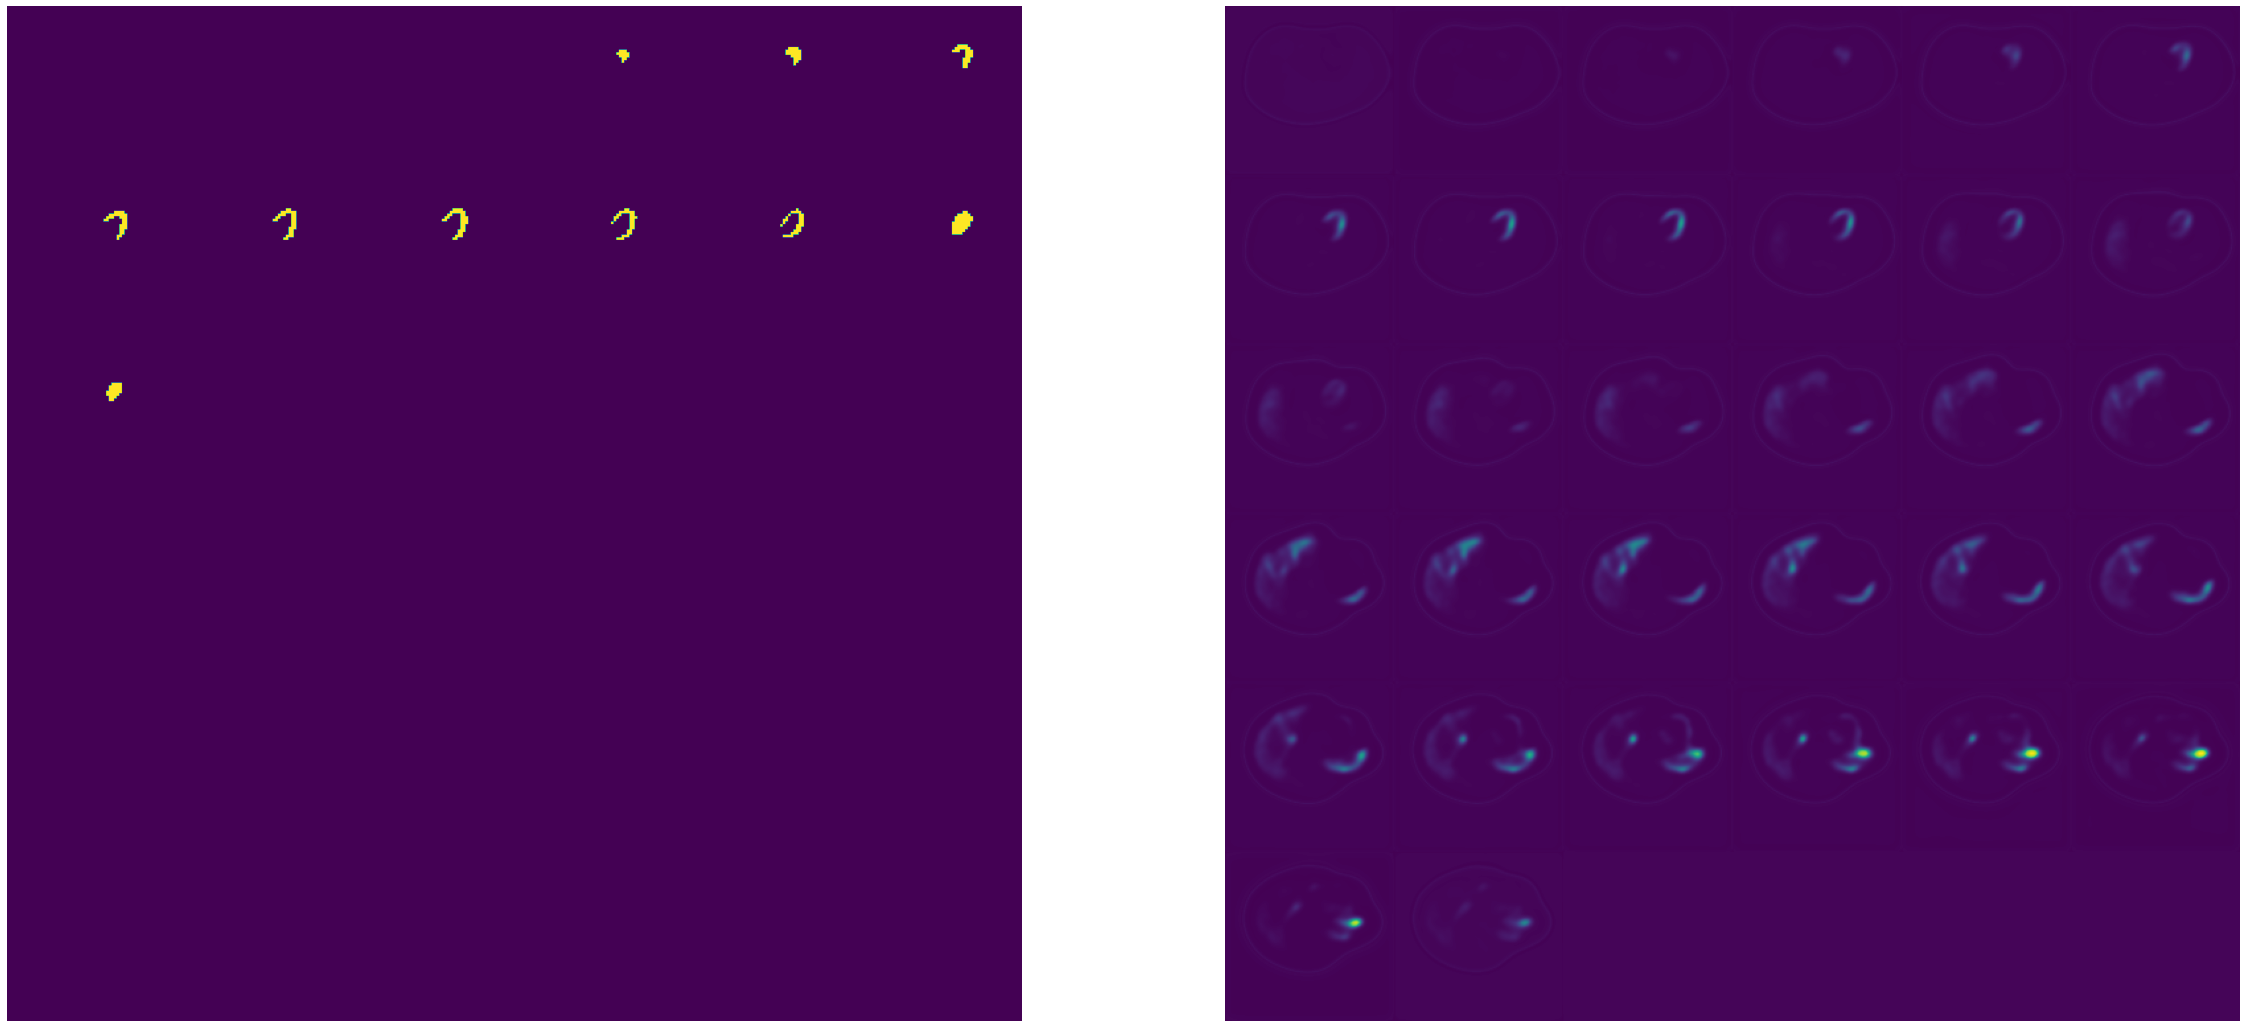

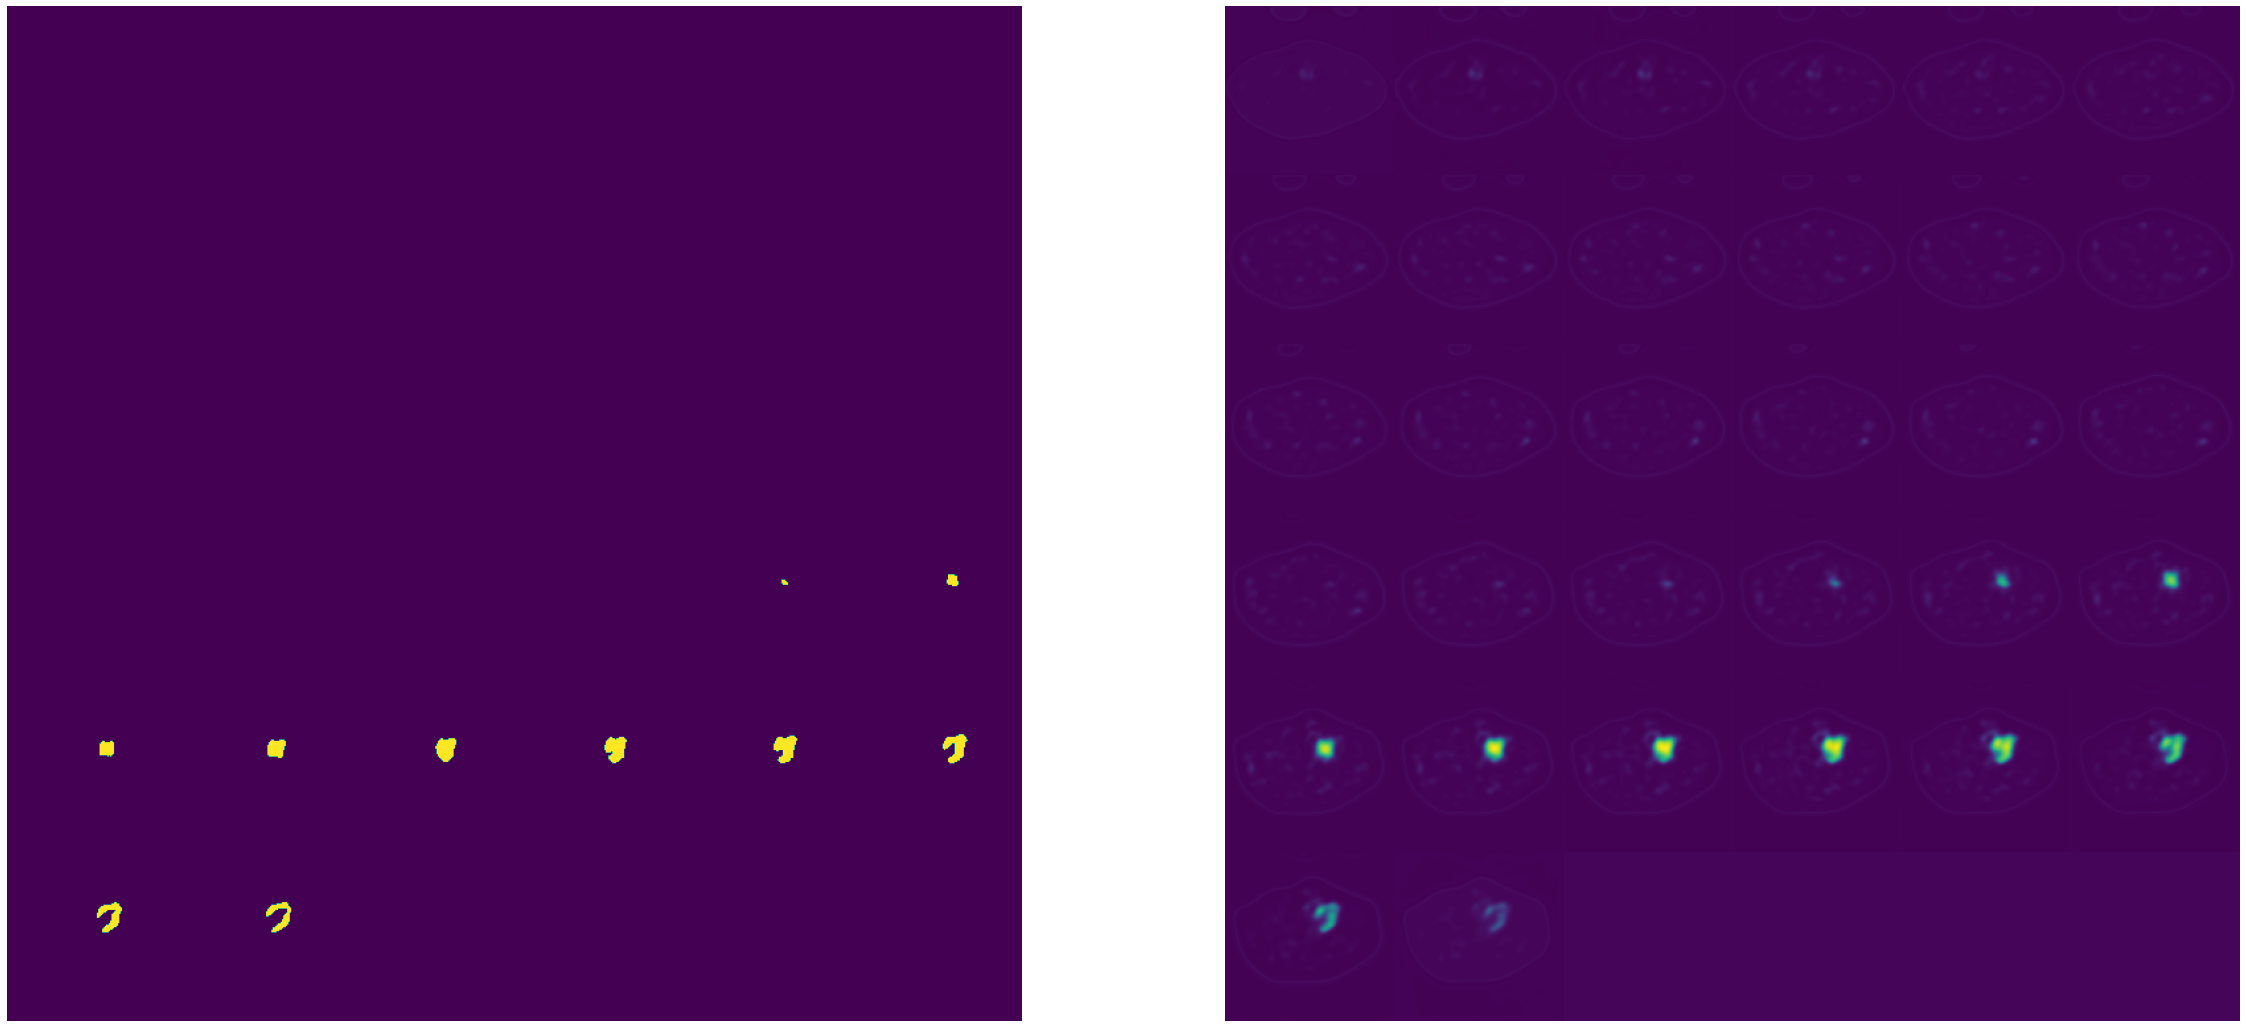

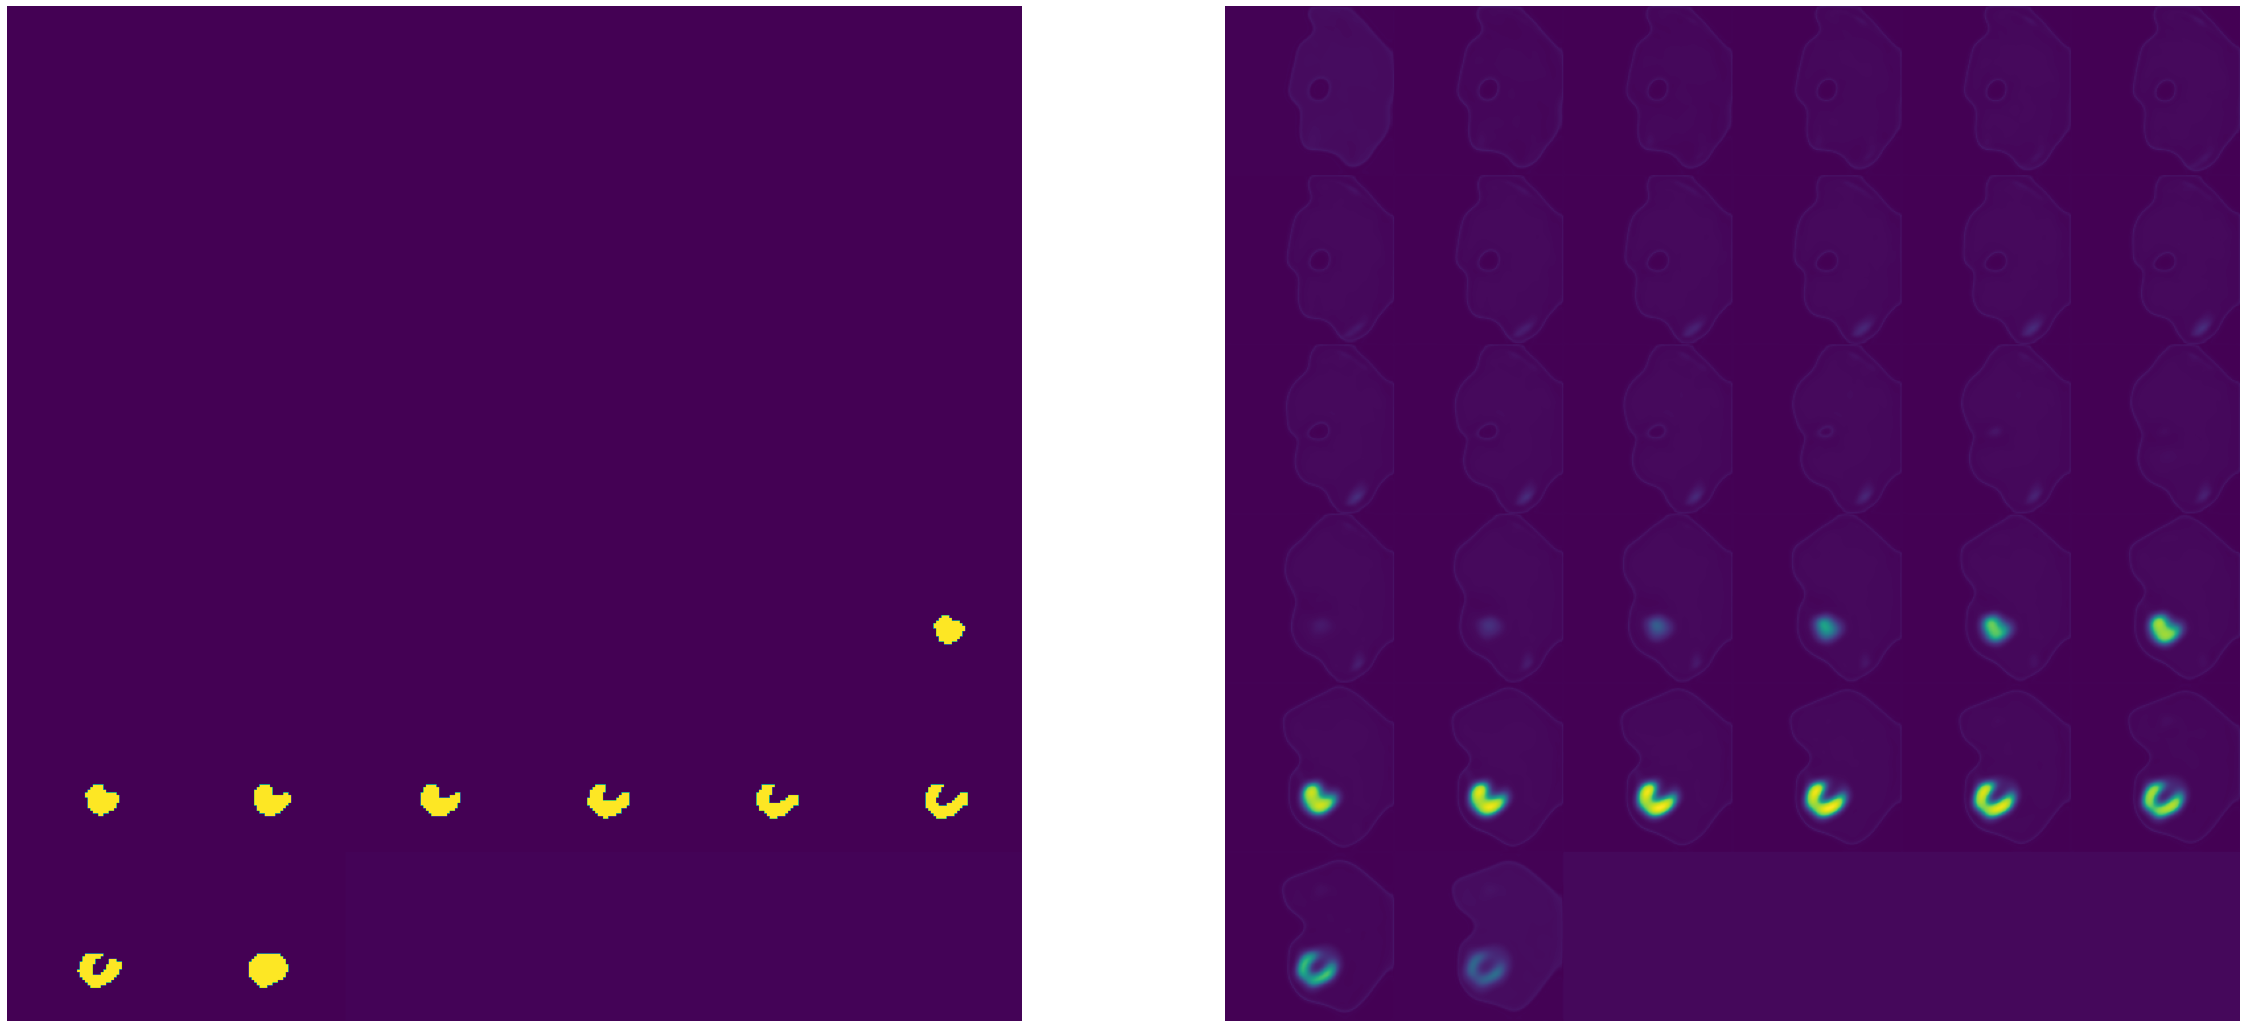

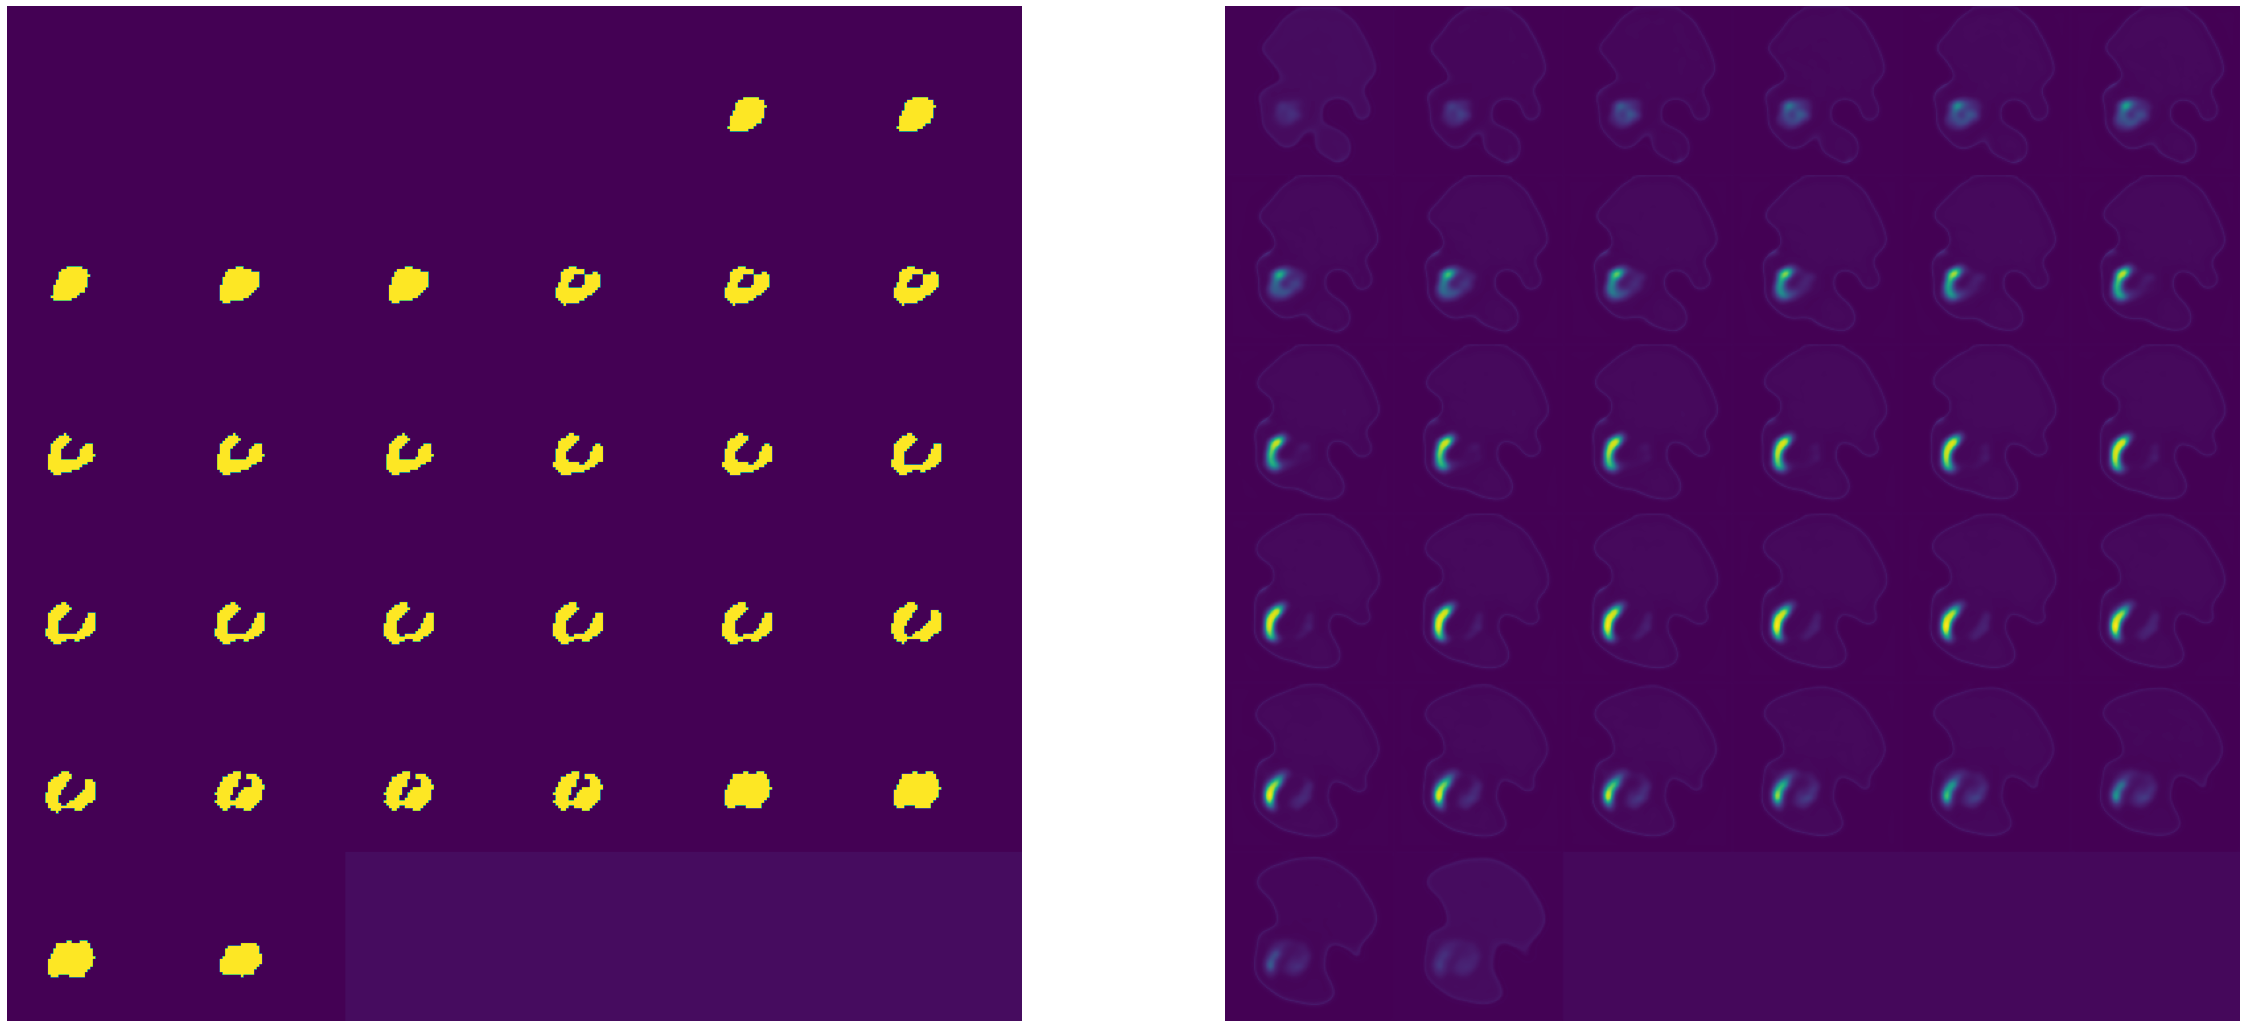

In [49]:
model.eval()

for batch_idx, batch in enumerate(tqdm(validation_loader)):

    inputs, targets = prepare_batch(batch, device)
    
    with torch.no_grad():

        predictions = model(inputs).softmax(dim=1)
        probabilities = predictions[:, FOREGROUND:].cpu()
    
    for i in range(len(batch['spect'][tio.DATA])):
    
        spect = batch['spect'][tio.DATA][i].permute(3, 0, 1, 2)
        label = batch['left_ventricle'][tio.DATA][i][1:, ...].permute(3, 0, 1, 2)
        pred = probabilities[i].permute(3, 0, 1, 2)
        
        vis.visualize(
            np.squeeze(label.permute(1,0,2,3).numpy(), axis=0),
            np.squeeze(pred.permute(1,0,2,3).numpy(), axis=0)
        )

In [51]:
model.encoder

Encoder(
  (encoding_blocks): ModuleList(
    (0): EncodingBlock(
      (conv1): ConvolutionalBlock(
        (conv_layer): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (activation_layer): PReLU(num_parameters=1)
        (dropout_layer): Dropout3d(p=0.5, inplace=False)
        (block): Sequential(
          (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): PReLU(num_parameters=1)
          (2): Dropout3d(p=0.5, inplace=False)
        )
      )
      (conv2): ConvolutionalBlock(
        (conv_layer): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (norm_layer): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (activation_layer): PReLU(num_parameters=1)
        (dropout_layer): Dropout3d(p=0.5, inplace=False)
        (block): Sequential(
          (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1